In [2]:
import h5py
import gzip
from Bio import SeqIO
import os
from mimetypes import guess_type
from functools import partial
import time
import json
import numpy as np
from refGenome import refGenome_h5
import seaborn as sb

import matplotlib.backends.backend_tkagg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from Dataset import SubIntervalDataset
import pandas as pd
from io import StringIO
import cv2

from utils import *

In [18]:
df = pd.read_csv('input.txt', sep='\t')
df['seq_len'] =  df['end'] - df['start']
df['seq_midpoint'] = df['start'] + ((df['end'] - df['start'])//2)

df['chrom'] = df['chrom'].apply(lambda x: f"{x[:3]}_{x[3:]}")
df.columns

Index(['chrom', 'start', 'end', 'AA1_strength', 'AA2_strength', 'AB1_strength',
       'AB2_strength', 'AC_strength', 'AA1_hotspots', 'AA2_hotspots',
       'AB1_hotspots', 'AB2_hotspots', 'AC_hotspots', 'AA_hotspots',
       'AB_hotspots', 'A_hotspots_intersect', 'A_hotspots_union',
       'A_hotspots_in_AC', 'C_hotspots', 'AA1_down', 'AA1_up', 'AA2_down',
       'AA2_up', 'AB1_down', 'AB1_up', 'at_LCR',
       'Stronger_than_Berg_et_al_Hotspots', 'Unnamed: 27', 'seq_len',
       'seq_midpoint'],
      dtype='object')

In [19]:
df

chrom     start       end  AA1_strength  AA2_strength  AB1_strength  \
0      chr_1     12769     13928             9            20             6   
1      chr_1     15497     18631           145           130           144   
2      chr_1     36224     37432            33            17            18   
3      chr_1     38426     40527           158           203           183   
4      chr_1     90761     91987             8            16            32   
...      ...       ...       ...           ...           ...           ...   
62105  chr_Y  59303490  59305269             3             0             4   
62106  chr_Y  59307439  59308324             2            11            25   
62107  chr_Y  59330278  59332422           105            87           237   
62108  chr_Y  59338519  59340632            23            26            46   
62109  chr_Y  59354663  59356272            36            87            96   

       AB2_strength  AC_strength  AA1_hotspots  AA2_hotspots  ...  AA1_up  \
0                23            2             0             0  ...       0   
1                83           98             1             1  ...       0   
2                16           12             1             0  ...       0   
3                56          192             1             1  ...       0   
4                 0           22             0             0  ...       0   
...             ...          ...           ...           ...  ...     ...   
62105             8          131             0             0  ...       0   
62106             6           20             0             0  ...       0   
62107            29          102             1             1  ...       0   
62108             4           35             0             0  ...       0   
62109            17           30             1             1  ...       0   

       AA2_down  AA2_up  AB1_down  AB1_up  at_LCR  \
0             0       0         0       0       0   
1             1       0         0       0       0   
2             0       0         0       0       0   
3             0       0         0       0       0   
4             0       0         0       0       1   
...         ...     ...       ...     ...     ...   
62105         0       0         0       0       0   
62106         0       0         0       0       0   
62107         0       0         0       0       0   
62108         0       0         0       0       0   
62109         0       0         0       0       0   

       Stronger_than_Berg_et_al_Hotspots  Unnamed: 27  seq_len  seq_midpoint  
0                                      0          NaN     1159         13348  
1                                      0          NaN     3134         17064  
2                                      0          NaN     1208         36828  
3                                      0          NaN     2101         39476  
4                                      0          NaN     1226         91374  
...                                  ...          ...      ...           ...  
62105                                  0          NaN     1779      59304379  
62106                                  0          NaN      885      59307881  
62107                                  0          NaN     2144      59331350  
62108                                  0          NaN     2113      59339575  
62109                                  0          NaN     1609      59355467  

[62110 rows x 30 columns]

In [20]:
individuals = ['AA1', 'AA2', 'AB1', 'AC']
outputs = ['AA1_hotspots','AA2_hotspots','AB1_hotspots','AB2_hotspots','AC_hotspots','AA_hotspots','AB_hotspots']

seq_lens  = [800, 2000, 3500]
chroms_to_use = list(range(1,23)) + ['X','Y','MT']

negative_sampling_intervals=[(1000,5000), (5000,10000), (10000, 20000), (20000,100000)]

random_seed=123

binarize_output = True

grch37_ds = refGenome_h5('../../../ref/ref_by_chr/h5/grch37_genome.h5')
chroms_lens_dict = grch37_ds.metadata['chr_lengths']

chr_1
chr_10
chr_11
chr_12
chr_13
chr_14
chr_15
chr_16
chr_17
chr_18
chr_19
chr_2
chr_20
chr_21
chr_22
chr_3
chr_4
chr_5
chr_6
chr_7
chr_8
chr_9
chr_MT
chr_X
chr_Y
Object Metadata:
{'encoding_dict': {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4, 'M': 4, 'R': 4}, 'available_chromosomes': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT'], 'chr_lengths': {'chr_1': 249250621, 'chr_2': 243199373, 'chr_3': 198022430, 'chr_4': 191154276, 'chr_5': 180915260, 'chr_6': 171115067, 'chr_7': 159138663, 'chr_8': 146364022, 'chr_9': 141213431, 'chr_10': 135534747, 'chr_11': 135006516, 'chr_12': 133851895, 'chr_13': 115169878, 'chr_14': 107349540, 'chr_15': 102531392, 'chr_16': 90354753, 'chr_17': 81195210, 'chr_18': 78077248, 'chr_19': 59128983, 'chr_20': 63025520, 'chr_21': 48129895, 'chr_22': 51304566, 'chr_X': 155270560, 'chr_Y': 59373566, 'chr_MT': 16569}, 'time created': 1666128811.6267376, 'num_2_base_dict': {0:

In [ ]:
for output in outputs:
    for seq_len in seq_lens:
        
        # If it's a multioutput dataset
        if isinstance(output, list):
            output_name = output
            
            cols = ['chrom', 'start', 'end']
            cols += output_name
            cols += ['seq_len', 'seq_midpoint']
            
            masks = [df[c] == 1 for c in output]
            masks = np.array(masks).T
            masks = masks.any(axis=1)
            
            df_output = df.loc[masks, cols].copy().reset_index(drop=True)
            
            meta_cols = ['chrom', 'start', 'end', 'seq_len', 'seq_midpoint'] + output_name
            outs_name = ".".join(output)
            output_fname = f"datasets/{outs_name}_seqlen={seq_len}_multnegs"
            
        else:
            
            output_name = [output]
            cols = ['chrom', 'start', 'end', f"{output}", 'seq_len', 'seq_midpoint'] 
            
            
            df_output = df.loc[df[output] == 1, cols].copy().reset_index(drop=True)
            
            meta_cols = ['chrom', 'start', 'end', 'seq_len', 'seq_midpoint', f"{output}"]

            output_fname = f"datasets/{output}_seqlen={seq_len}_multnegs"
        
        print(f"OUTPUT DATAFRAME AFTER FILTERING {output}")
        print(df_output)
        print(output_name, seq_len)
        print("\n\n\n")
        
        create_h5_dataset_by_chromosome(df=df_output,
                                        output_fname=output_fname,
                                        grch_obj=grch37_ds,
                                        chroms_lens_dict=chroms_lens_dict,
                                        seq_len=seq_len,
                                        negative_sampling_intervals=negative_sampling_intervals,
                                        chr_col='chrom',
                                        start_col='start',
                                        end_col='end',
                                        seq_midpoint_col='seq_midpoint',
                                        output_cols_list=output_name, #always pass a list, even for a single out

                                        binarize_output=binarize_output,

                                        pos_suffix='pos',
                                        neg_suffix='neg',

                                        seq_suffix='seq',
                                        metadata_suffix='meta',
                                        output_suffix='out',
                                        
                                        random_seed=random_seed,

                                        test_set_size=0.1,
                                        test_set_sampling='uniform')
        
        print("*"*80)
        print("*"*80)
        print("*"*80)

OUTPUT DATAFRAME AFTER FILTERING AA1_hotspots
       chrom     start       end  AA1_hotspots  seq_len  seq_midpoint
0      chr_1     15497     18631             1     3134         17064
1      chr_1     36224     37432             1     1208         36828
2      chr_1     38426     40527             1     2101         39476
3      chr_1    353112    354479             1     1367        353795
4      chr_1    424174    426058             1     1884        425116
...      ...       ...       ...           ...      ...           ...
28161  chr_Y  59206329  59207964             1     1635      59207146
28162  chr_Y  59274648  59276224             1     1576      59275436
28163  chr_Y  59290791  59292847             1     2056      59291819
28164  chr_Y  59330278  59332422             1     2144      59331350
28165  chr_Y  59354663  59356272             1     1609      59355467

[28166 rows x 6 columns]
['AA1_hotspots'] 800




Creating dataset for chromosome chr_1:
	Constructing Positive D

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2140 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16664      17464         17064           15497         18631   
1         36428      37228         36828           36224         37432   
2         39076      39876         39476           38426         40527   
3        353395     354195        353795          353112        354479   
4        424716     425516        425116          424174        426058   
...         ...        ...           ...             ...           ...   
2135  249130386  249131186     249130786       249130129     249131444   
2136  249165546  249166346     249165946       249164514     249167379   
2137  249172098  249172898     249172498       249172098     249172899   
2138  249200680  249201480     249201080       249199812     249202349   


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4103 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4048, 6) is 189.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4041 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3757, 6) is 175.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3747 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1786, 6) is 83.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1771 examples
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_seq, shape=(2140, 800)
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_out, shape=(2140, 1)
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_meta, shape=(2140, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1095 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        148606     149406        149006          148209        149803   
1        161414     162214        161814          160729        162900   
2        307832     308632        308232          307688        308777   
3        316591     317391        316991          316313        317670   
4        330147     330947        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1090  135287247  135288047     135287647       135286393     135288902   
1091  135292980  135293780     135293380       135290424     135296337   
1092  135423366  135424166     135423766       135423003     135424529   
1093  135435604  135436404     135436004       135434912 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2073 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2054, 6) is 187.58% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2050 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1920, 6) is 175.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1916 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (904, 6) is 82.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 896 examples
	Splitting train\test, data length = 1095
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_10_pos_seq, shape=(1095, 800)
	Splitting train\test, data length = 1095
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_10_pos_out, shape=(1095, 1)
	Splitting train\test, data length = 1095
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1020 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        101585     102385        101985          101140        102830   
1        106468     107268        106868          106414        107323   
2        200952     201752        201352          200318        202386   
3        222993     223793        223393          222749        224037   
4        247529     248329        247929          246731        249127   
...         ...        ...           ...             ...           ...   
1015  134852031  134852831     134852431       134851843     134853020   
1016  134858681  134859481     134859081       134858318     134859845   
1017  134886124  134886924     134886524       134885930     134887118   
1018  134899937  134900737     134900337       134899471     134901204   
1019  134916327  134917127     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1894 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1868, 6) is 183.14% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1865 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1736, 6) is 170.20% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1731 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (893, 6) is 87.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 887 examples
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_seq, shape=(1020, 800)
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_out, shape=(1020, 1)
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_meta, shape=(1020, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1091 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61600      62400         62000           61152         62849   
1         64213      65013         64613           63914         65312   
2         87869      88669         88269           87204         89334   
3        150047     150847        150447          149697        151198   
4        152143     152943        152543          151319        153768   
...         ...        ...           ...             ...           ...   
1086  133672158  133672958     133672558       133671906     133673211   
1087  133766270  133767070     133766670       133765994     133767347   
1088  133795044  133795844     133795444       133794035     133796853   
1089  133801476  133802276     133801876       133800654     133803099   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2036, 6) is 186.62% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2033 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2004, 6) is 183.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1999 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1876, 6) is 171.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1872 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (954, 6) is 87.44% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 951 examples
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_seq, shape=(1091, 800)
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_out, shape=(1091, 1)
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_meta, shape=(1091, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1012 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19512998   19513798      19513398        19512811      19513986   
1      19596530   19597330      19596930        19596336      19597525   
2      19646513   19647313      19646913        19646035      19647791   
3      19664716   19665516      19665116        19664356      19665876   
4      19693583   19694383      19693983        19693492      19694475   
...         ...        ...           ...             ...           ...   
1007  115010299  115011099     115010699       115010122     115011276   
1008  115052360  115053160     115052760       115051916     115053604   
1009  115060816  115061616     115061216       115059977     115062456   
1010  115100057  115100857     115100457       115099932     115100982   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1946, 6) is 192.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1942 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1922, 6) is 189.92% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1917 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1804, 6) is 178.26% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1799 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (766, 6) is 75.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 758 examples
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_seq, shape=(1012, 800)
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_out, shape=(1012, 1)
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_meta, shape=(1012, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1009 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19113110   19113910      19113510        19113106      19113914   
1      19683303   19684103      19683703        19682774      19684633   
2      19717406   19718206      19717806        19717102      19718510   
3      19891318   19892118      19891718        19890689      19892747   
4      20344173   20344973      20344573        20343910      20345237   
...         ...        ...           ...             ...           ...   
1004  107070967  107071767     107071367       107070374     107072360   
1005  107107040  107107840     107107440       107106688     107108192   
1006  107165426  107166226     107165826       107164552     107167101   
1007  107220677  107221477     107221077       107220414 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1926 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1894, 6) is 187.71% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1892 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1748, 6) is 173.24% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1746 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (712, 6) is 70.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 710 examples
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_seq, shape=(1009, 800)
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_out, shape=(1009, 1)
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_meta, shape=(1009, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 844 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     20734967   20735767      20735367        20734850      20735885   
1     20946018   20946818      20946418        20945962      20946874   
2     20951684   20952484      20952084        20951631      20952537   
3     20966754   20967554      20967154        20965816      20968493   
4     21930719   21931519      21931119        21930436      21931802   
..         ...        ...           ...             ...           ...   
839  102250632  102251432     102251032       102250241     102251824   
840  102328867  102329667     102329267       102328757     102329777   
841  102375576  102376376     102375976       102375418     102376535   
842  102491352  102492152     102491752       102490728     10249277

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1596 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1574, 6) is 186.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1570 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1485, 6) is 175.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1482 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (628, 6) is 74.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 622 examples
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_seq, shape=(844, 800)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_out, shape=(844, 1)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_meta, shape=(844, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 724 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        66598     67398         66998           65848         68149   
1        93588     94388         93988           93365         94611   
2       115174    115974        115574          114786        116362   
3       131266    132066        131666          129602        133731   
4       139188    139988        139588          138725        140451   
..         ...       ...           ...             ...           ...   
719   90069836  90070636      90070236        90069139      90071333   
720   90080388  90081188      90080788        90079853      90081724   
721   90107914  90108714      90108314        90106696      90109933   
722   90123577  90124377      90123977        90122712      90125242   
723   90258148  902589

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1350 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1326, 6) is 183.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1321 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1246, 6) is 172.10% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1241 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (525, 6) is 72.51% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 525 examples
	Splitting train\test, data length = 724
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_seq, shape=(724, 800)
	Splitting train\test, data length = 724
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_out, shape=(724, 1)
	Splitting train\test, data length = 724
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_meta, shape=(724, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 641 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         5306      6106          5706            5091          6322   
1        25807     26607         26207           24604         27811   
2        30268     31068         30668           29539         31798   
3        35813     36613         36213           35444         36983   
4        50796     51596         51196           50029         52363   
..         ...       ...           ...             ...           ...   
636   81048209  81049009      81048609        81047638      81049580   
637   81069686  81070486      81070086        81068478      81071694   
638   81084879  81085679      81085279        81084668      81085891   
639   81108603  81109403      81109003        81108592      81109415   
640   81124683  81125483      81125083

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1196 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1175, 6) is 183.31% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1175 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1074, 6) is 167.55% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1073 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (482, 6) is 75.20% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 479 examples
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_seq, shape=(641, 800)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_out, shape=(641, 1)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_meta, shape=(641, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 738 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        99158     99958         99558           98565        100551   
1       125083    125883        125483          124912        126054   
2       152083    152883        152483          151650        153316   
3       172921    173721        173321          172762        173881   
4       248990    249790        249390          248403        250377   
..         ...       ...           ...             ...           ...   
733   77928965  77929765      77929365        77928652      77930078   
734   77959101  77959901      77959501        77958959      77960044   
735   77961935  77962735      77962335        77961621      77963050   
736   77968188  77968988      77968588        77968005      77969171   
737   77974104  77974904      77974504 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1374 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1354, 6) is 183.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1352 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1256, 6) is 170.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1254 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (563, 6) is 76.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 559 examples
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_seq, shape=(738, 800)
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_out, shape=(738, 1)
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_meta, shape=(738, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 533 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        78402     79202         78802           78199         79405   
1        80548     81348         80948           79852         82045   
2       131567    132367        131967          131358        132577   
3       170928    171728        171328          170566        172090   
4       176389    177189        176789          176168        177410   
..         ...       ...           ...             ...           ...   
528   58604273  58605073      58604673        58603846      58605500   
529   58745313  58746113      58745713        58744907      58746520   
530   58806548  58807348      58806948        58806143      58807754   
531   58911302  58912102      58911702        58911034      58912370   
532   59027984  590287

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1005 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (992, 6) is 186.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 989 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (924, 6) is 173.36% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 922 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (378, 6) is 70.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 376 examples
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_seq, shape=(533, 800)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_out, shape=(533, 1)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_meta, shape=(533, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2168 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72596      73396         72996           72239         73754   
1         76004      76804         76404           75456         77352   
2        101553     102353        101953          100431        103476   
3        122009     122809        122409          121739        123079   
4        170995     171795        171395          170590        172200   
...         ...        ...           ...             ...           ...   
2163  242941489  242942289     242941889       242941489     242942289   
2164  242950556  242951356     242950956       242948405     242953507   
2165  242961555  242962355     242961955       242961274     242962636   
2166  242979468  242980268     242979868       242979144 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4157 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4112, 6) is 189.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4107 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3864, 6) is 178.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3859 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1890, 6) is 87.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1877 examples
	Splitting train\test, data length = 2168
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_seq, shape=(2168, 800)
	Splitting train\test, data length = 2168
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_out, shape=(2168, 1)
	Splitting train\test, data length = 2168
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_meta, shape=(2168, 15)
	Splitting train\test, dat

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 499 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68744     69544         69144           67982         70307   
1        81905     82705         82305           81386         83225   
2       133758    134558        134158          133641        134675   
3       247023    247823        247423          246512        248334   
4       254367    255167        254767          254136        255399   
..         ...       ...           ...             ...           ...   
494   62825762  62826562      62826162        62825431      62826893   
495   62856279  62857079      62856679        62855736      62857622   
496   62879207  62880007      62879607        62878978      62880236   
497   62884206  62885006      62884606        62883896      62885317   
498   62947704  62948504      62948104 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 928 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (918, 6) is 183.97% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 915 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (852, 6) is 170.74% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 848 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (360, 6) is 72.14% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 356 examples
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_seq, shape=(499, 800)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_out, shape=(499, 1)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_meta, shape=(499, 15)
	Splitting train\test, data length = 928
 test fi

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 500 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9483617   9484417       9484017         9482858       9485177   
1      9826288   9827088       9826688         9825203       9828173   
2     14398343  14399143      14398743        14398084      14399402   
3     14596286  14597086      14596686        14595465      14597907   
4     14599831  14600631      14600231        14599322      14601140   
..         ...       ...           ...             ...           ...   
495   47970148  47970948      47970548        47969295      47971802   
496   47974189  47974989      47974589        47974108      47975071   
497   48022969  48023769      48023369        48022698      48024041   
498   48054545  48055345      48054945        48054295      48055596   
499   48093710  48094510      48094110        48092857      48095364   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 913 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (902, 6) is 180.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 898 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (808, 6) is 161.60% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 803 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (306, 6) is 61.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 301 examples
	Splitting train\test, data length = 500
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_seq, shape=(500, 800)
	Splitting train\test, data length = 500
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_out, shape=(500, 1)
	Splitting train\test, data length = 500
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_meta, shape=(500, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 478 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17958115  17958915      17958515        17957873      17959157   
1     17985423  17986223      17985823        17985006      17986641   
2     17989543  17990343      17989943        17989014      17990873   
3     18053584  18054384      18053984        18053216      18054752   
4     18057346  18058146      18057746        18056691      18058802   
..         ...       ...           ...             ...           ...   
473   51153302  51154102      51153702        51151831      51155574   
474   51173602  51174402      51174002        51173142      51174862   
475   51176412  51177212      51176812        51176236      51177389   
476   51204294  51205094      51204694        51203917      51205472   
477   51206316  51207116      51206716        51205924 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 882 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (866, 6) is 181.17% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 863 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (798, 6) is 166.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 795 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (271, 6) is 56.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 267 examples
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_seq, shape=(478, 800)
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_out, shape=(478, 1)
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_meta, shape=(478, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1667 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72628      73428         73028           72167         73889   
1         91186      91986         91586           91169         92004   
2         92477      93277         92877           92276         93478   
3         96557      97357         96957           95820         98094   
4        107138     107938        107538          106433        108644   
...         ...        ...           ...             ...           ...   
1662  197775416  197776216     197775816       197774643     197776990   
1663  197791798  197792598     197792198       197791697     197792700   
1664  197851293  197852093     197851693       197851180     197852207   
1665  197863173  197863973     197863573       197863071 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3186, 6) is 191.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3184 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3138, 6) is 188.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3136 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2922, 6) is 175.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2919 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1446, 6) is 86.74% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1445 examples
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_seq, shape=(1667, 800)
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_out, shape=(1667, 1)
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_meta, shape=(1667, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1753 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19156      19956         19556           18794         20318   
1        109878     110678        110278          109242        111315   
2        167533     168333        167933          167352        168514   
3        203124     203924        203524          202531        204517   
4        317992     318792        318392          317524        319260   
...         ...        ...           ...             ...           ...   
1748  190899171  190899971     190899571       190898758     190900385   
1749  190901514  190902314     190901914       190901286     190902542   
1750  190962219  190963019     190962619       190961583     190963655   
1751  191027545  191028345     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3346, 6) is 190.87% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3343 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3302, 6) is 188.36% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3297 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3095, 6) is 176.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3090 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1508, 6) is 86.02% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1504 examples
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_seq, shape=(1753, 800)
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_out, shape=(1753, 1)
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_meta, shape=(1753, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1582 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         13599      14399         13999           13568         14430   
1         20255      21055         20655           19518         21793   
2         74612      75412         75012           74462         75563   
3         78534      79334         78934           77355         80514   
4         84540      85340         84940           82757         87124   
...         ...        ...           ...             ...           ...   
1577  180685307  180686107     180685707       180684609     180686805   
1578  180774310  180775110     180774710       180774136     180775284   
1579  180780064  180780864     180780464       180779657     180781271   
1580  180851243  180852043     180851643       180850827     180852460   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3003 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2956, 6) is 186.85% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2952 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2755, 6) is 174.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2755 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1240, 6) is 78.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1239 examples
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_seq, shape=(1582, 800)
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_out, shape=(1582, 1)
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_meta, shape=(1582, 15)
	Splitting train\test, dat

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1515 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         79838      80638         80238           79690         80786   
1        120210     121010        120610          119794        121427   
2        188644     189444        189044          188012        190077   
3        205416     206216        205816          204827        206806   
4        209287     210087        209687          208702        210673   
...         ...        ...           ...             ...           ...   
1510  170918368  170919168     170918768       170918098     170919439   
1511  170929153  170929953     170929553       170929034     170930072   
1512  170934510  170935310     170934910       170934107     170935714   
1513  170978829  170979629     170979229       170978642     170979816   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2888, 6) is 190.50% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2884 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2852, 6) is 188.13% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2848 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2668, 6) is 175.99% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2662 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1246, 6) is 82.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1241 examples
	Splitting train\test, data length = 1515
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_seq, shape=(1515, 800)
	Splitting train\test, data length = 1515
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_out, shape=(1515, 1)
	Splitting train\test, data length = 1515
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_meta, shape=(1515, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1345 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         67645      68445         68045           66661         69429   
1         77001      77801         77401           75738         79065   
2         79282      80082         79682           79275         80090   
3        110420     111220        110820          109901        111739   
4        115095     115895        115495          114332        116659   
...         ...        ...           ...             ...           ...   
1340  158991098  158991898     158991498       158990772     158992225   
1341  158995308  158996108     158995708       158994119     158997297   
1342  159017781  159018581     159018181       159016976     159019387   
1343  159054600  159055400     159055000       159054179     159055822   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2567 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2534, 6) is 188.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2530 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2386, 6) is 177.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2381 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1206, 6) is 89.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1202 examples
	Splitting train\test, data length = 1345
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_7_pos_seq, shape=(1345, 800)
	Splitting train\test, data length = 1345
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_7_pos_out, shape=(1345, 1)
	Splitting train\test, data length = 1345
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1245 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         57668      58468         58068           57158         58979   
1        130395     131195        130795          130015        131576   
2        136119     136919        136519          136110        136929   
3        161960     162760        162360          161565        163155   
4        202772     203572        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1240  146069186  146069986     146069586       146067867     146071306   
1241  146133094  146133894     146133494       146132363     146134626   
1242  146173167  146173967     146173567       146172783     146174352   
1243  146175687  146176487     146176087       146174808     146177366   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2356 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2320, 6) is 186.35% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2316 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2130, 6) is 171.08% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2126 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1022, 6) is 82.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1015 examples
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_seq, shape=(1245, 800)
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_out, shape=(1245, 1)
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_meta, shape=(1245, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1071 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16717      17517         17117           16132         18103   
1         38812      39612         39212           38158         40266   
2         72888      73688         73288           72750         73826   
3        100469     101269        100869           99625        102113   
4        103641     104441        104041          103162        104920   
...         ...        ...           ...             ...           ...   
1066  141005710  141006510     141006110       141005373     141006848   
1067  141011993  141012793     141012393       141010161     141014625   
1068  141015607  141016407     141016007       141015237     141016778   
1069  141092384  141093184     141092784       141090283 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2024, 6) is 188.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2020 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1990, 6) is 185.81% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1985 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1829, 6) is 170.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1825 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (824, 6) is 76.94% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 807 examples
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_seq, shape=(1071, 800)
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_out, shape=(1071, 1)
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_meta, shape=(1071, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3107 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         62446      63246         62846           61475         64217   
1        185943     186743        186343          185060        187627   
2        191622     192422        192022          191499        192546   
3        206467     207267        206867          206411        207324   
4        210321     211121        210721          210168        211274   
...         ...        ...           ...             ...           ...   
3102  155103638  155104438     155104038       155103231     155104845   
3103  155172203  155173003     155172603       155171907     155173299   
3104  155188434  155189234     155188834       155187810     155189858   
3105  155227847  155228647     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5570 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5420, 6) is 174.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5410 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4667, 6) is 150.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4654 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (958, 6) is 30.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 949 examples
	Splitting train\test, data length = 3107
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_seq, shape=(3107, 800)
	Splitting train\test, data length = 3107
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_out, shape=(3107, 1)
	Splitting train\test, data length = 3107
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_meta, shape=(3107, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 301 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2654740   2655540       2655140         2654504       2655777   
1      2657498   2658298       2657898         2657012       2658784   
2      2695588   2696388       2695988         2695505       2696472   
3      2703745   2704545       2704145         2703482       2704809   
4      2727581   2728381       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
296   28328547  28329347      28328947        28328547      28329347   
297   28347860  28348660      28348260        28346810      28349710   
298   28595630  28596430      28596030        28594857      28597204   
299   28631332  28632132      28631732        28630584      28632880   
300   59020074  59020874      59020474        59019571      59021377   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 564 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (694, 6) is 179.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 557 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (630, 6) is 162.79% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 511 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (188, 6) is 48.58% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 48% processed
	 58% processed
	 68% processed
	 77% processed
	 87% processed
	 96% processed
Negative (20000, 100000) constructed, total 169 examples
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_seq, shape=(301, 800)
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_out, shape=(301, 1)
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_meta, shape=(301, 15)
	Splitting train\test, data length = 564
 test first 20 indices: [ T

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2140 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16064      18064         17064           15497         18631   
1         35828      37828         36828           36224         37432   
2         38476      40476         39476           38426         40527   
3        352795     354795        353795          353112        354479   
4        424116     426116        425116          424174        426058   
...         ...        ...           ...             ...           ...   
2135  249129786  249131786     249130786       249130129     249131444   
2136  249164946  249166946     249165946       249164514     249167379   
2137  249171498  249173498     249172498       249172098     249172899   
2138  249200080  249202080     249201080       249199812     249202349   


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4106, 6) is 191.87% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4101 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4048, 6) is 189.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4040 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3757, 6) is 175.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3747 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1786, 6) is 83.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1776 examples
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_seq, shape=(2140, 2000)
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_out, shape=(2140, 1)
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_meta, shape=(2140, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1094 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        148006     150006        149006          148209        149803   
1        160814     162814        161814          160729        162900   
2        307232     309232        308232          307688        308777   
3        315991     317991        316991          316313        317670   
4        329547     331547        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1089  135286647  135288647     135287647       135286393     135288902   
1090  135292380  135294380     135293380       135290424     135296337   
1091  135422766  135424766     135423766       135423003     135424529   
1092  135435004  135437004     135436004       135434912     135437096   
1093  135453403

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2073 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2054, 6) is 187.58% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2050 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1920, 6) is 175.34% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1916 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (904, 6) is 82.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 899 examples
	Splitting train\test, data length = 1094
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_10_pos_seq, shape=(1094, 2000)
	Splitting train\test, data length = 1094
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_10_pos_out, shape=(1094, 1)
	Splitting train\test, data length = 1094
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_10_pos_meta, shape=(1094, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1020 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        100985     102985        101985          101140        102830   
1        105868     107868        106868          106414        107323   
2        200352     202352        201352          200318        202386   
3        222393     224393        223393          222749        224037   
4        246929     248929        247929          246731        249127   
...         ...        ...           ...             ...           ...   
1015  134851431  134853431     134852431       134851843     134853020   
1016  134858081  134860081     134859081       134858318     134859845   
1017  134885524  134887524     134886524       134885930     134887118   
1018  134899337  134901337     134900337       134899471     134901204   
1019  134915727  134917727     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1896, 6) is 185.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1894 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1868, 6) is 183.14% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1866 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1736, 6) is 170.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1731 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (893, 6) is 87.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 887 examples
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_seq, shape=(1020, 2000)
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_out, shape=(1020, 1)
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_meta, shape=(1020, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1091 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61000      63000         62000           61152         62849   
1         63613      65613         64613           63914         65312   
2         87269      89269         88269           87204         89334   
3        149447     151447        150447          149697        151198   
4        151543     153543        152543          151319        153768   
...         ...        ...           ...             ...           ...   
1086  133671558  133673558     133672558       133671906     133673211   
1087  133765670  133767670     133766670       133765994     133767347   
1088  133794444  133796444     133795444       133794035     133796853   
1089  133800876  133802876     133801876       133800654     133803099   
1090  133811714

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2036, 6) is 186.62% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2033 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2004, 6) is 183.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1999 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1876, 6) is 171.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1872 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (954, 6) is 87.44% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 950 examples
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_seq, shape=(1091, 2000)
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_out, shape=(1091, 1)
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_meta, shape=(1091, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1012 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19512398   19514398      19513398        19512811      19513986   
1      19595930   19597930      19596930        19596336      19597525   
2      19645913   19647913      19646913        19646035      19647791   
3      19664116   19666116      19665116        19664356      19665876   
4      19692983   19694983      19693983        19693492      19694475   
...         ...        ...           ...             ...           ...   
1007  115009699  115011699     115010699       115010122     115011276   
1008  115051760  115053760     115052760       115051916     115053604   
1009  115060216  115062216     115061216       115059977     115062456   
1010  115099457  115101457     115100457       115099932     115100982   
1011  115105012  115107012     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1942 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1922, 6) is 189.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1917 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1804, 6) is 178.26% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1797 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (766, 6) is 75.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 757 examples
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_seq, shape=(1012, 2000)
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_out, shape=(1012, 1)
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_meta, shape=(1012, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1009 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19112510   19114510      19113510        19113106      19113914   
1      19682703   19684703      19683703        19682774      19684633   
2      19716806   19718806      19717806        19717102      19718510   
3      19890718   19892718      19891718        19890689      19892747   
4      20343573   20345573      20344573        20343910      20345237   
...         ...        ...           ...             ...           ...   
1004  107070367  107072367     107071367       107070374     107072360   
1005  107106440  107108440     107107440       107106688     107108192   
1006  107164826  107166826     107165826       107164552     107167101   
1007  107220077  107222077     107221077       107220414     107221741   
1008  107229279  107231279     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1926 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1894, 6) is 187.71% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1892 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1748, 6) is 173.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1746 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (712, 6) is 70.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 709 examples
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_seq, shape=(1009, 2000)
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_out, shape=(1009, 1)
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_meta, shape=(1009, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 844 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     20734367   20736367      20735367        20734850      20735885   
1     20945418   20947418      20946418        20945962      20946874   
2     20951084   20953084      20952084        20951631      20952537   
3     20966154   20968154      20967154        20965816      20968493   
4     21930119   21932119      21931119        21930436      21931802   
..         ...        ...           ...             ...           ...   
839  102250032  102252032     102251032       102250241     102251824   
840  102328267  102330267     102329267       102328757     102329777   
841  102374976  102376976     102375976       102375418     102376535   
842  102490752  102492752     102491752       102490728     102492776   
843  102513055  102515055     102514055    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1595 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1574, 6) is 186.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1570 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1485, 6) is 175.95% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1481 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (628, 6) is 74.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 626 examples
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_seq, shape=(844, 2000)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_out, shape=(844, 1)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_meta, shape=(844, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 723 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        65998     67998         66998           65848         68149   
1        92988     94988         93988           93365         94611   
2       114574    116574        115574          114786        116362   
3       130666    132666        131666          129602        133731   
4       138588    140588        139588          138725        140451   
..         ...       ...           ...             ...           ...   
718   90069236  90071236      90070236        90069139      90071333   
719   90079788  90081788      90080788        90079853      90081724   
720   90107314  90109314      90108314        90106696      90109933   
721   90122977  90124977      90123977        90122712      90125242   
722   90257548  90259548      90258548        90257925      90259171  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1351 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1326, 6) is 183.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1321 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1246, 6) is 172.10% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1241 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (525, 6) is 72.51% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 525 examples
	Splitting train\test, data length = 723
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_seq, shape=(723, 2000)
	Splitting train\test, data length = 723
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_out, shape=(723, 1)
	Splitting train\test, data length = 723
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_meta, shape=(723, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 641 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         4706      6706          5706            5091          6322   
1        25207     27207         26207           24604         27811   
2        29668     31668         30668           29539         31798   
3        35213     37213         36213           35444         36983   
4        50196     52196         51196           50029         52363   
..         ...       ...           ...             ...           ...   
636   81047609  81049609      81048609        81047638      81049580   
637   81069086  81071086      81070086        81068478      81071694   
638   81084279  81086279      81085279        81084668      81085891   
639   81108003  81110003      81109003        81108592      81109415   
640   81124083  81126083      81125083        81124245      81125922  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1196, 6) is 186.58% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1196 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1175, 6) is 183.31% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1175 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1074, 6) is 167.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1074 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (482, 6) is 75.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 480 examples
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_seq, shape=(641, 2000)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_out, shape=(641, 1)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_meta, shape=(641, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (738, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 738 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        98558    100558         99558           98565        100551   
1       124483    126483        125483          124912        126054   
2       151483    153483        152483          151650        153316   
3       172321    174321        173321          172762        173881   
4       248390    250390        249390          248403        250377   
..         ...       ...           ...             ...           ...   
733   77928365  77930365      77929365        77928652      77930078   
734   77958501  77960501      77959501        77958959      77960044   
735   77961335  7796333

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1374 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1354, 6) is 183.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1352 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1256, 6) is 170.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1254 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (563, 6) is 76.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 559 examples
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_seq, shape=(738, 2000)
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_out, shape=(738, 1)
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_meta, shape=(738, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 533 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        77802     79802         78802           78199         79405   
1        79948     81948         80948           79852         82045   
2       130967    132967        131967          131358        132577   
3       170328    172328        171328          170566        172090   
4       175789    177789        176789          176168        177410   
..         ...       ...           ...             ...           ...   
528   58603673  58605673      58604673        58603846      58605500   
529   58744713  58746713      58745713        58744907      58746520   
530   58805948  58807948      58806948        58806143      58807754   
531   58910702  58912702      58911702        58911034      58912370   
532   59027384  59029384      59028384        59027721      59029048   

     original

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1005 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (992, 6) is 186.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 989 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (924, 6) is 173.36% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 922 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (378, 6) is 70.92% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 376 examples
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_seq, shape=(533, 2000)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_out, shape=(533, 1)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_meta, shape=(533, 15)
	Splitting train\test, data length = 1005
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2167 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71996      73996         72996           72239         73754   
1         75404      77404         76404           75456         77352   
2        100953     102953        101953          100431        103476   
3        121409     123409        122409          121739        123079   
4        170395     172395        171395          170590        172200   
...         ...        ...           ...             ...           ...   
2162  242940889  242942889     242941889       242941489     242942289   
2163  242949956  242951956     242950956       242948405     242953507   
2164  242960955  242962955     242961955       242961274     242962636   
2165  242978868  242980868     242979868       242979144     242980593   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4157 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4112, 6) is 189.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4107 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3864, 6) is 178.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3858 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1890, 6) is 87.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1879 examples
	Splitting train\test, data length = 2167
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_seq, shape=(2167, 2000)
	Splitting train\test, data length = 2167
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_out, shape=(2167, 1)
	Splitting train\test, data length = 2167
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_meta, shape=(2167, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 499 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68144     70144         69144           67982         70307   
1        81305     83305         82305           81386         83225   
2       133158    135158        134158          133641        134675   
3       246423    248423        247423          246512        248334   
4       253767    255767        254767          254136        255399   
..         ...       ...           ...             ...           ...   
494   62825162  62827162      62826162        62825431      62826893   
495   62855679  62857679      62856679        62855736      62857622   
496   62878607  62880607      62879607        62878978      62880236   
497   62883606  62885606      62884606        62883896      62885317   
498   62947104  62949104      62948104        62947560      62948648   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 928 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (918, 6) is 183.97% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 915 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (852, 6) is 170.74% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 847 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (360, 6) is 72.14% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 359 examples
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_seq, shape=(499, 2000)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_out, shape=(499, 1)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_meta, shape=(499, 15)
	Splitting train\test, data length = 928
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 499 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9483017   9485017       9484017         9482858       9485177   
1      9825688   9827688       9826688         9825203       9828173   
2     14397743  14399743      14398743        14398084      14399402   
3     14595686  14597686      14596686        14595465      14597907   
4     14599231  14601231      14600231        14599322      14601140   
..         ...       ...           ...             ...           ...   
494   47969548  47971548      47970548        47969295      47971802   
495   47973589  47975589      47974589        47974108      47975071   
496   48022369  48024369      48023369        48022698      48024041   
497   48053945  48055945      48054945        48054295      48055596   
498   48093110  48095110      48094110        48092857      48095364   

     original_seq_len  original_count_dict_A  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 913 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (902, 6) is 180.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 898 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (808, 6) is 161.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 803 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (306, 6) is 61.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 302 examples
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_seq, shape=(499, 2000)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_out, shape=(499, 1)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_meta, shape=(499, 15)
	Splitting train\test, data length = 913
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 478 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17957515  17959515      17958515        17957873      17959157   
1     17984823  17986823      17985823        17985006      17986641   
2     17988943  17990943      17989943        17989014      17990873   
3     18052984  18054984      18053984        18053216      18054752   
4     18056746  18058746      18057746        18056691      18058802   
..         ...       ...           ...             ...           ...   
473   51152702  51154702      51153702        51151831      51155574   
474   51173002  51175002      51174002        51173142      51174862   
475   51175812  51177812      51176812        51176236      51177389   
476   51203694  51205694      51204694        51203917      51205472   
477   51205716  5120771

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 882 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (866, 6) is 181.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 863 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (798, 6) is 166.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 795 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (271, 6) is 56.69% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 268 examples
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_seq, shape=(478, 2000)
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_out, shape=(478, 1)
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_meta, shape=(478, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1667 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72028      74028         73028           72167         73889   
1         90586      92586         91586           91169         92004   
2         91877      93877         92877           92276         93478   
3         95957      97957         96957           95820         98094   
4        106538     108538        107538          106433        108644   
...         ...        ...           ...             ...           ...   
1662  197774816  197776816     197775816       197774643     197776990   
1663  197791198  197793198     197792198       197791697     197792700   
1664  197850693  197852693     197851693       197851180     197852207   
1665  197862573  197864573     197863573       197863071 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3184 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3138, 6) is 188.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3136 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2922, 6) is 175.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2918 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1446, 6) is 86.74% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1444 examples
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_seq, shape=(1667, 2000)
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_out, shape=(1667, 1)
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_meta, shape=(1667, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1753 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         18556      20556         19556           18794         20318   
1        109278     111278        110278          109242        111315   
2        166933     168933        167933          167352        168514   
3        202524     204524        203524          202531        204517   
4        317392     319392        318392          317524        319260   
...         ...        ...           ...             ...           ...   
1748  190898571  190900571     190899571       190898758     190900385   
1749  190900914  190902914     190901914       190901286     190902542   
1750  190961619  190963619     190962619       190961583     190963655   
1751  191026945  191028945     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3343 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3302, 6) is 188.36% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3295 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3095, 6) is 176.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3090 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1508, 6) is 86.02% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1505 examples
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_seq, shape=(1753, 2000)
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_out, shape=(1753, 1)
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_meta, shape=(1753, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1582 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         12999      14999         13999           13568         14430   
1         19655      21655         20655           19518         21793   
2         74012      76012         75012           74462         75563   
3         77934      79934         78934           77355         80514   
4         83940      85940         84940           82757         87124   
...         ...        ...           ...             ...           ...   
1577  180684707  180686707     180685707       180684609     180686805   
1578  180773710  180775710     180774710       180774136     180775284   
1579  180779464  180781464     180780464       180779657     180781271   
1580  180850643  180852643     180851643       180850827     180852460   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3006, 6) is 190.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3004 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2956, 6) is 186.85% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2953 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2755, 6) is 174.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2753 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1240, 6) is 78.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1240 examples
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_seq, shape=(1582, 2000)
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_out, shape=(1582, 1)
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_meta, shape=(1582, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1514 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         79238      81238         80238           79690         80786   
1        119610     121610        120610          119794        121427   
2        188044     190044        189044          188012        190077   
3        204816     206816        205816          204827        206806   
4        208687     210687        209687          208702        210673   
...         ...        ...           ...             ...           ...   
1509  170917768  170919768     170918768       170918098     170919439   
1510  170928553  170930553     170929553       170929034     170930072   
1511  170933910  170935910     170934910       170934107     170935714   
1512  170978229  170980229     170979229       170978642     170979816   
1513  171008292

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2884 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2852, 6) is 188.13% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2848 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2668, 6) is 175.99% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2662 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1246, 6) is 82.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1240 examples
	Splitting train\test, data length = 1514
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_seq, shape=(1514, 2000)
	Splitting train\test, data length = 1514
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_out, shape=(1514, 1)
	Splitting train\test, data length = 1514
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_meta, shape=(1514, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1344 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         67045      69045         68045           66661         69429   
1         76401      78401         77401           75738         79065   
2         78682      80682         79682           79275         80090   
3        109820     111820        110820          109901        111739   
4        114495     116495        115495          114332        116659   
...         ...        ...           ...             ...           ...   
1339  158990498  158992498     158991498       158990772     158992225   
1340  158994708  158996708     158995708       158994119     158997297   
1341  159017181  159019181     159018181       159016976     159019387   
1342  159054000  159056000     159055000       159054179     159055822   
1343  159102665

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2567 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2534, 6) is 188.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2530 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2386, 6) is 177.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2381 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1206, 6) is 89.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1201 examples
	Splitting train\test, data length = 1344
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_7_pos_seq, shape=(1344, 2000)
	Splitting train\test, data length = 1344
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_7_pos_out, shape=(1344, 1)
	Splitting train\test, data length = 1344
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1245 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         57068      59068         58068           57158         58979   
1        129795     131795        130795          130015        131576   
2        135519     137519        136519          136110        136929   
3        161360     163360        162360          161565        163155   
4        202172     204172        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1240  146068586  146070586     146069586       146067867     146071306   
1241  146132494  146134494     146133494       146132363     146134626   
1242  146172567  146174567     146173567       146172783     146174352   
1243  146175087  146177087     146176087       146174808     146177366   
1244  146245942

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2356 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2320, 6) is 186.35% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2316 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2130, 6) is 171.08% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2126 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1022, 6) is 82.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1016 examples
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_seq, shape=(1245, 2000)
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_out, shape=(1245, 1)
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_meta, shape=(1245, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1071 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16117      18117         17117           16132         18103   
1         38212      40212         39212           38158         40266   
2         72288      74288         73288           72750         73826   
3         99869     101869        100869           99625        102113   
4        103041     105041        104041          103162        104920   
...         ...        ...           ...             ...           ...   
1066  141005110  141007110     141006110       141005373     141006848   
1067  141011393  141013393     141012393       141010161     141014625   
1068  141015007  141017007     141016007       141015237     141016778   
1069  141091784  141093784     141092784       141090283     141095286   
1070  141098050

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2024, 6) is 188.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2020 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1990, 6) is 185.81% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1985 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1829, 6) is 170.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1825 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (824, 6) is 76.94% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 808 examples
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_seq, shape=(1071, 2000)
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_out, shape=(1071, 1)
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_meta, shape=(1071, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3106 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61846      63846         62846           61475         64217   
1        185343     187343        186343          185060        187627   
2        191022     193022        192022          191499        192546   
3        205867     207867        206867          206411        207324   
4        209721     211721        210721          210168        211274   
...         ...        ...           ...             ...           ...   
3101  155103038  155105038     155104038       155103231     155104845   
3102  155171603  155173603     155172603       155171907     155173299   
3103  155187834  155189834     155188834       155187810     155189858   
3104  155227247  155229247     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5570 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5420, 6) is 174.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5408 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4667, 6) is 150.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4653 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (958, 6) is 30.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 946 examples
	Splitting train\test, data length = 3106
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_seq, shape=(3106, 2000)
	Splitting train\test, data length = 3106
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_out, shape=(3106, 1)
	Splitting train\test, data length = 3106
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_meta, shape=(3106, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 99% processed
Positive constructed, total 301 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2654140   2656140       2655140         2654504       2655777   
1      2656898   2658898       2657898         2657012       2658784   
2      2694988   2696988       2695988         2695505       2696472   
3      2703145   2705145       2704145         2703482       2704809   
4      2726981   2728981       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
296   28327947  28329947      28328947        28328547      28329347   
297   28347260  28349260      28348260        28346810      28349710   
298   28595030  28597030      28596030        28594857      28597204   
299   28630732  28632732      28631732        28630584      28632880   
300   59019474  59021474      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0      

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 564 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (694, 6) is 179.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 557 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (630, 6) is 162.79% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 512 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (188, 6) is 48.58% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 48% processed
	 58% processed
	 68% processed
	 77% processed
	 87% processed
	 96% processed
Negative (20000, 100000) constructed, total 170 examples
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_seq, shape=(301, 2000)
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_out, shape=(301, 1)
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_meta, shape=(301, 15)
	Splitting train\test, data length = 564
 test first 20 indices: [ 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2140 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15314      18814         17064           15497         18631   
1         35078      38578         36828           36224         37432   
2         37726      41226         39476           38426         40527   
3        352045     355545        353795          353112        354479   
4        423366     426866        425116          424174        426058   
...         ...        ...           ...             ...           ...   
2135  249129036  249132536     249130786       249130129     249131444   
2136  249164196  249167696     249165946       249164514     249167379   
2137  249170748  249174248     249172498       249172098     249172899   
2138  249199330  249202830     249201080       249199812     249202349   


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4101 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4048, 6) is 189.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4039 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3757, 6) is 175.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3747 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1786, 6) is 83.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1770 examples
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_seq, shape=(2140, 3500)
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_out, shape=(2140, 1)
	Splitting train\test, data length = 2140
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 214
		data field: chr_1_pos_meta, shape=(2140, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1094 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        147256     150756        149006          148209        149803   
1        160064     163564        161814          160729        162900   
2        306482     309982        308232          307688        308777   
3        315241     318741        316991          316313        317670   
4        328797     332297        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1089  135285897  135289397     135287647       135286393     135288902   
1090  135291630  135295130     135293380       135290424     135296337   
1091  135422016  135425516     135423766       135423003     135424529   
1092  135434254  135437754     135436004       135434912     135437096   
1093  135452653

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2072 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2054, 6) is 187.58% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2050 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1920, 6) is 175.34% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1916 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (904, 6) is 82.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 896 examples
	Splitting train\test, data length = 1094
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_10_pos_seq, shape=(1094, 3500)
	Splitting train\test, data length = 1094
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_10_pos_out, shape=(1094, 1)
	Splitting train\test, data length = 1094
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_10_pos_meta, shape=(1094, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1020 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        100235     103735        101985          101140        102830   
1        105118     108618        106868          106414        107323   
2        199602     203102        201352          200318        202386   
3        221643     225143        223393          222749        224037   
4        246179     249679        247929          246731        249127   
...         ...        ...           ...             ...           ...   
1015  134850681  134854181     134852431       134851843     134853020   
1016  134857331  134860831     134859081       134858318     134859845   
1017  134884774  134888274     134886524       134885930     134887118   
1018  134898587  134902087     134900337       134899471     134901204   
1019  134914977  134918477     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1896, 6) is 185.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1894 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1868, 6) is 183.14% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1865 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1736, 6) is 170.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1731 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (893, 6) is 87.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 890 examples
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_seq, shape=(1020, 3500)
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_out, shape=(1020, 1)
	Splitting train\test, data length = 1020
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_11_pos_meta, shape=(1020, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1091 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         60250      63750         62000           61152         62849   
1         62863      66363         64613           63914         65312   
2         86519      90019         88269           87204         89334   
3        148697     152197        150447          149697        151198   
4        150793     154293        152543          151319        153768   
...         ...        ...           ...             ...           ...   
1086  133670808  133674308     133672558       133671906     133673211   
1087  133764920  133768420     133766670       133765994     133767347   
1088  133793694  133797194     133795444       133794035     133796853   
1089  133800126  133803626     133801876       133800654     133803099   
1090  133810964

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2031 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2004, 6) is 183.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1999 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1876, 6) is 171.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1872 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (954, 6) is 87.44% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 951 examples
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_seq, shape=(1091, 3500)
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_out, shape=(1091, 1)
	Splitting train\test, data length = 1091
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 110
		data field: chr_12_pos_meta, shape=(1091, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1012 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19511648   19515148      19513398        19512811      19513986   
1      19595180   19598680      19596930        19596336      19597525   
2      19645163   19648663      19646913        19646035      19647791   
3      19663366   19666866      19665116        19664356      19665876   
4      19692233   19695733      19693983        19693492      19694475   
...         ...        ...           ...             ...           ...   
1007  115008949  115012449     115010699       115010122     115011276   
1008  115051010  115054510     115052760       115051916     115053604   
1009  115059466  115062966     115061216       115059977     115062456   
1010  115098707  115102207     115100457       115099932     115100982   
1011  115104262

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1946, 6) is 192.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1941 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1922, 6) is 189.92% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1917 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1804, 6) is 178.26% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1797 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (766, 6) is 75.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 759 examples
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_seq, shape=(1012, 3500)
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_out, shape=(1012, 1)
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_13_pos_meta, shape=(1012, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1009 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19111760   19115260      19113510        19113106      19113914   
1      19681953   19685453      19683703        19682774      19684633   
2      19716056   19719556      19717806        19717102      19718510   
3      19889968   19893468      19891718        19890689      19892747   
4      20342823   20346323      20344573        20343910      20345237   
...         ...        ...           ...             ...           ...   
1004  107069617  107073117     107071367       107070374     107072360   
1005  107105690  107109190     107107440       107106688     107108192   
1006  107164076  107167576     107165826       107164552     107167101   
1007  107219327  107222827     107221077       107220414     107221741   
1008  107228529

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1928, 6) is 191.08% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1926 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1894, 6) is 187.71% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1892 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1748, 6) is 173.24% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1746 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (712, 6) is 70.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 711 examples
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_seq, shape=(1009, 3500)
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_out, shape=(1009, 1)
	Splitting train\test, data length = 1009
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_14_pos_meta, shape=(1009, 15)
	Splitting train\test,

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 844 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     20733617   20737117      20735367        20734850      20735885   
1     20944668   20948168      20946418        20945962      20946874   
2     20950334   20953834      20952084        20951631      20952537   
3     20965404   20968904      20967154        20965816      20968493   
4     21929369   21932869      21931119        21930436      21931802   
..         ...        ...           ...             ...           ...   
839  102249282  102252782     102251032       102250241     102251824   
840  102327517  102331017     102329267       102328757     102329777   
841  102374226  102377726     102375976       102375418     102376535   
842  102490002  102493502     102491752       102490728     102492776   
843  102512305  102515805     102514055    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1595 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1574, 6) is 186.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1570 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1485, 6) is 175.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1480 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (628, 6) is 74.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 623 examples
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_seq, shape=(844, 3500)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_out, shape=(844, 1)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_15_pos_meta, shape=(844, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 723 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        65248     68748         66998           65848         68149   
1        92238     95738         93988           93365         94611   
2       113824    117324        115574          114786        116362   
3       129916    133416        131666          129602        133731   
4       137838    141338        139588          138725        140451   
..         ...       ...           ...             ...           ...   
718   90068486  90071986      90070236        90069139      90071333   
719   90079038  90082538      90080788        90079853      90081724   
720   90106564  90110064      90108314        90106696      90109933   
721   90122227  90125727      90123977        90122712      90125242   
722   90256798  90260298      90258548        90257925      90259171  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1350 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1326, 6) is 183.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1321 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1246, 6) is 172.10% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1241 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (525, 6) is 72.51% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 524 examples
	Splitting train\test, data length = 723
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_seq, shape=(723, 3500)
	Splitting train\test, data length = 723
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_out, shape=(723, 1)
	Splitting train\test, data length = 723
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 73
		data field: chr_16_pos_meta, shape=(723, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 641 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         3956      7456          5706            5091          6322   
1        24457     27957         26207           24604         27811   
2        28918     32418         30668           29539         31798   
3        34463     37963         36213           35444         36983   
4        49446     52946         51196           50029         52363   
..         ...       ...           ...             ...           ...   
636   81046859  81050359      81048609        81047638      81049580   
637   81068336  81071836      81070086        81068478      81071694   
638   81083529  81087029      81085279        81084668      81085891   
639   81107253  81110753      81109003        81108592      81109415   
640   81123333  81126833      81125083        81124245      81125922  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1196 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1175, 6) is 183.31% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1175 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1074, 6) is 167.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1074 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (482, 6) is 75.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 479 examples
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_seq, shape=(641, 3500)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_out, shape=(641, 1)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_17_pos_meta, shape=(641, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 738 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        97808    101308         99558           98565        100551   
1       123733    127233        125483          124912        126054   
2       150733    154233        152483          151650        153316   
3       171571    175071        173321          172762        173881   
4       247640    251140        249390          248403        250377   
..         ...       ...           ...             ...           ...   
733   77927615  77931115      77929365        77928652      77930078   
734   77957751  77961251      77959501        77958959      77960044   
735   77960585  77964085      77962335        77961621      77963050   
736   77966838  77970338      77968588        77968005      77969171   
737   77972754  77976254      77974504        77973513      77975495   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1374 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1354, 6) is 183.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1352 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1256, 6) is 170.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1254 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (564, 6) is 76.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 560 examples
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_seq, shape=(738, 3500)
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_out, shape=(738, 1)
	Splitting train\test, data length = 738
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_18_pos_meta, shape=(738, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 532 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        77052     80552         78802           78199         79405   
1        79198     82698         80948           79852         82045   
2       130217    133717        131967          131358        132577   
3       169578    173078        171328          170566        172090   
4       175039    178539        176789          176168        177410   
..         ...       ...           ...             ...           ...   
527   58602923  58606423      58604673        58603846      58605500   
528   58743963  58747463      58745713        58744907      58746520   
529   58805198  58808698      58806948        58806143      58807754   
530   58909952  58913452      58911702        58911034      58912370   
531   59026634  59030134      59028384        59027721      59029048   

     original

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1005 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (992, 6) is 186.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 989 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (924, 6) is 173.36% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 922 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (378, 6) is 70.92% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 377 examples
	Splitting train\test, data length = 532
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_seq, shape=(532, 3500)
	Splitting train\test, data length = 532
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_out, shape=(532, 1)
	Splitting train\test, data length = 532
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_19_pos_meta, shape=(532, 15)
	Splitting train\test, data length = 1005
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2167 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71246      74746         72996           72239         73754   
1         74654      78154         76404           75456         77352   
2        100203     103703        101953          100431        103476   
3        120659     124159        122409          121739        123079   
4        169645     173145        171395          170590        172200   
...         ...        ...           ...             ...           ...   
2162  242940139  242943639     242941889       242941489     242942289   
2163  242949206  242952706     242950956       242948405     242953507   
2164  242960205  242963705     242961955       242961274     242962636   
2165  242978118  242981618     242979868       242979144     242980593   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4157 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4112, 6) is 189.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4105 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3864, 6) is 178.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3859 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1890, 6) is 87.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1882 examples
	Splitting train\test, data length = 2167
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_seq, shape=(2167, 3500)
	Splitting train\test, data length = 2167
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_out, shape=(2167, 1)
	Splitting train\test, data length = 2167
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 217
		data field: chr_2_pos_meta, shape=(2167, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 499 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        67394     70894         69144           67982         70307   
1        80555     84055         82305           81386         83225   
2       132408    135908        134158          133641        134675   
3       245673    249173        247423          246512        248334   
4       253017    256517        254767          254136        255399   
..         ...       ...           ...             ...           ...   
494   62824412  62827912      62826162        62825431      62826893   
495   62854929  62858429      62856679        62855736      62857622   
496   62877857  62881357      62879607        62878978      62880236   
497   62882856  62886356      62884606        62883896      62885317   
498   62946354  62949854      62948104        62947560      62948648   

     original_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 928 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (918, 6) is 183.97% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 915 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (852, 6) is 170.74% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 848 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (360, 6) is 72.14% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 356 examples
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_seq, shape=(499, 3500)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_out, shape=(499, 1)
	Splitting train\test, data length = 499
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_20_pos_meta, shape=(499, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 497 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9482267   9485767       9484017         9482858       9485177   
1     14396993  14400493      14398743        14398084      14399402   
2     14594936  14598436      14596686        14595465      14597907   
3     14598481  14601981      14600231        14599322      14601140   
4     14709707  14713207      14711457        14710471      14712443   
..         ...       ...           ...             ...           ...   
492   47968798  47972298      47970548        47969295      47971802   
493   47972839  47976339      47974589        47974108      47975071   
494   48021619  48025119      48023369        48022698      48024041   
495   48053195  48056695      48054945        48054295      48055596   
496   48092360  48095860      48094110        48092857      48095364   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 913 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (902, 6) is 180.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 898 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (808, 6) is 161.60% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 802 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (306, 6) is 61.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 302 examples
	Splitting train\test, data length = 497
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_seq, shape=(497, 3500)
	Splitting train\test, data length = 497
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_out, shape=(497, 1)
	Splitting train\test, data length = 497
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_21_pos_meta, shape=(497, 15)
	Splitting train\test, data length = 913
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 478 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17956765  17960265      17958515        17957873      17959157   
1     17984073  17987573      17985823        17985006      17986641   
2     17988193  17991693      17989943        17989014      17990873   
3     18052234  18055734      18053984        18053216      18054752   
4     18055996  18059496      18057746        18056691      18058802   
..         ...       ...           ...             ...           ...   
473   51151952  51155452      51153702        51151831      51155574   
474   51172252  51175752      51174002        51173142      51174862   
475   51175062  51178562      51176812        51176236      51177389   
476   51202944  51206444      51204694        51203917      51205472   
477   51204966  51208466      51206716        51205924      51207509   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 882 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (866, 6) is 181.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 863 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (798, 6) is 166.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 795 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (271, 6) is 56.69% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 267 examples
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_seq, shape=(478, 3500)
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_out, shape=(478, 1)
	Splitting train\test, data length = 478
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 48
		data field: chr_22_pos_meta, shape=(478, 15)
	Splitting train\test, data length = 882
 test first 20 indices

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1667 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71278      74778         73028           72167         73889   
1         89836      93336         91586           91169         92004   
2         91127      94627         92877           92276         93478   
3         95207      98707         96957           95820         98094   
4        105788     109288        107538          106433        108644   
...         ...        ...           ...             ...           ...   
1662  197774066  197777566     197775816       197774643     197776990   
1663  197790448  197793948     197792198       197791697     197792700   
1664  197849943  197853443     197851693       197851180     197852207   
1665  197861823  197865323     197863573       197863071 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3184 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3138, 6) is 188.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3136 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2922, 6) is 175.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2918 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1446, 6) is 86.74% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1444 examples
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_seq, shape=(1667, 3500)
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_out, shape=(1667, 1)
	Splitting train\test, data length = 1667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 167
		data field: chr_3_pos_meta, shape=(1667, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1753 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         17806      21306         19556           18794         20318   
1        108528     112028        110278          109242        111315   
2        166183     169683        167933          167352        168514   
3        201774     205274        203524          202531        204517   
4        316642     320142        318392          317524        319260   
...         ...        ...           ...             ...           ...   
1748  190897821  190901321     190899571       190898758     190900385   
1749  190900164  190903664     190901914       190901286     190902542   
1750  190960869  190964369     190962619       190961583     190963655   
1751  191026195  191029695     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3342 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3302, 6) is 188.36% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3296 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3096, 6) is 176.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3088 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1508, 6) is 86.02% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1505 examples
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_seq, shape=(1753, 3500)
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_out, shape=(1753, 1)
	Splitting train\test, data length = 1753
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 176
		data field: chr_4_pos_meta, shape=(1753, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1582 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         12249      15749         13999           13568         14430   
1         18905      22405         20655           19518         21793   
2         73262      76762         75012           74462         75563   
3         77184      80684         78934           77355         80514   
4         83190      86690         84940           82757         87124   
...         ...        ...           ...             ...           ...   
1577  180683957  180687457     180685707       180684609     180686805   
1578  180772960  180776460     180774710       180774136     180775284   
1579  180778714  180782214     180780464       180779657     180781271   
1580  180849893  180853393     180851643       180850827     180852460   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3003 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2956, 6) is 186.85% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2952 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2755, 6) is 174.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2754 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1240, 6) is 78.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1238 examples
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_seq, shape=(1582, 3500)
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_out, shape=(1582, 1)
	Splitting train\test, data length = 1582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 159
		data field: chr_5_pos_meta, shape=(1582, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1514 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         78488      81988         80238           79690         80786   
1        118860     122360        120610          119794        121427   
2        187294     190794        189044          188012        190077   
3        204066     207566        205816          204827        206806   
4        207937     211437        209687          208702        210673   
...         ...        ...           ...             ...           ...   
1509  170917018  170920518     170918768       170918098     170919439   
1510  170927803  170931303     170929553       170929034     170930072   
1511  170933160  170936660     170934910       170934107     170935714   
1512  170977479  170980979     170979229       170978642     170979816   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2884 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2852, 6) is 188.13% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2848 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2668, 6) is 175.99% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2661 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1246, 6) is 82.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1239 examples
	Splitting train\test, data length = 1514
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_seq, shape=(1514, 3500)
	Splitting train\test, data length = 1514
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_out, shape=(1514, 1)
	Splitting train\test, data length = 1514
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_6_pos_meta, shape=(1514, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1344 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         66295      69795         68045           66661         69429   
1         75651      79151         77401           75738         79065   
2         77932      81432         79682           79275         80090   
3        109070     112570        110820          109901        111739   
4        113745     117245        115495          114332        116659   
...         ...        ...           ...             ...           ...   
1339  158989748  158993248     158991498       158990772     158992225   
1340  158993958  158997458     158995708       158994119     158997297   
1341  159016431  159019931     159018181       159016976     159019387   
1342  159053250  159056750     159055000       159054179     159055822   
1343  159101915

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2567 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2534, 6) is 188.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2529 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2386, 6) is 177.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2380 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1206, 6) is 89.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1199 examples
	Splitting train\test, data length = 1344
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_7_pos_seq, shape=(1344, 3500)
	Splitting train\test, data length = 1344
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_7_pos_out, shape=(1344, 1)
	Splitting train\test, data length = 1344
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1245 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         56318      59818         58068           57158         58979   
1        129045     132545        130795          130015        131576   
2        134769     138269        136519          136110        136929   
3        160610     164110        162360          161565        163155   
4        201422     204922        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1240  146067836  146071336     146069586       146067867     146071306   
1241  146131744  146135244     146133494       146132363     146134626   
1242  146171817  146175317     146173567       146172783     146174352   
1243  146174337  146177837     146176087       146174808     146177366   
1244  146245192

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2356 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2320, 6) is 186.35% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2316 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2130, 6) is 171.08% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2126 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1022, 6) is 82.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1015 examples
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_seq, shape=(1245, 3500)
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_out, shape=(1245, 1)
	Splitting train\test, data length = 1245
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 125
		data field: chr_8_pos_meta, shape=(1245, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1071 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15367      18867         17117           16132         18103   
1         37462      40962         39212           38158         40266   
2         71538      75038         73288           72750         73826   
3         99119     102619        100869           99625        102113   
4        102291     105791        104041          103162        104920   
...         ...        ...           ...             ...           ...   
1066  141004360  141007860     141006110       141005373     141006848   
1067  141010643  141014143     141012393       141010161     141014625   
1068  141014257  141017757     141016007       141015237     141016778   
1069  141091034  141094534     141092784       141090283     141095286   
1070  141097300

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2020 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1990, 6) is 185.81% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1985 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1829, 6) is 170.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1825 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (824, 6) is 76.94% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 808 examples
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_seq, shape=(1071, 3500)
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_out, shape=(1071, 1)
	Splitting train\test, data length = 1071
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_9_pos_meta, shape=(1071, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3105 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61096      64596         62846           61475         64217   
1        184593     188093        186343          185060        187627   
2        190272     193772        192022          191499        192546   
3        205117     208617        206867          206411        207324   
4        208971     212471        210721          210168        211274   
...         ...        ...           ...             ...           ...   
3100  155102288  155105788     155104038       155103231     155104845   
3101  155170853  155174353     155172603       155171907     155173299   
3102  155187084  155190584     155188834       155187810     155189858   
3103  155226497  155229997     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5570 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5420, 6) is 174.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5407 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4667, 6) is 150.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4652 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (958, 6) is 30.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 948 examples
	Splitting train\test, data length = 3105
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_seq, shape=(3105, 3500)
	Splitting train\test, data length = 3105
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_out, shape=(3105, 1)
	Splitting train\test, data length = 3105
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 311
		data field: chr_X_pos_meta, shape=(3105, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 89% processed
	 99% processed
Positive constructed, total 301 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2653390   2656890       2655140         2654504       2655777   
1      2656148   2659648       2657898         2657012       2658784   
2      2694238   2697738       2695988         2695505       2696472   
3      2702395   2705895       2704145         2703482       2704809   
4      2726231   2729731       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
296   28327197  28330697      28328947        28328547      28329347   
297   28346510  28350010      28348260        28346810      28349710   
298   28594280  28597780      28596030        28594857      28597204   
299   28629982  28633482      28631732        28630584      28632880   
300   59018724  59022224      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  original_count_d

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 564 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (694, 6) is 179.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 557 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (630, 6) is 162.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 511 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (188, 6) is 48.58% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 29% processed
	 39% processed
	 48% processed
	 58% processed
	 68% processed
	 77% processed
	 87% processed
	 96% processed
Negative (20000, 100000) constructed, total 171 examples
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_seq, shape=(301, 3500)
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_out, shape=(301, 1)
	Splitting train\test, data length = 301
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 31
		data field: chr_Y_pos_meta, shape=(301, 15)
	Splitting train\test, data length = 564
 test firs

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2879 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16664      17464         17064           15497         18631   
1         39076      39876         39476           38426         40527   
2        348188     348988        348588          348168        349009   
3        353395     354195        353795          353112        354479   
4        424716     425516        425116          424174        426058   
...         ...        ...           ...             ...           ...   
2874  249165546  249166346     249165946       249164514     249167379   
2875  249200680  249201480     249201080       249199812     249202349   
2876  249208479  249209279     249208879       249207944     249209814   
2877  249219086  249219886     249219486       249219045     249219927   
2878  249232841 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5433 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5338, 6) is 185.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5326 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4878, 6) is 169.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4865 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 62.78% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1794 examples
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_seq, shape=(2879, 800)
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_out, shape=(2879, 1)
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_meta, shape=(2879, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1456 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        148606     149406        149006          148209        149803   
1        161414     162214        161814          160729        162900   
2        307832     308632        308232          307688        308777   
3        316591     317391        316991          316313        317670   
4        330147     330947        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1451  135440770  135441570     135441170       135440475     135441865   
1452  135450657  135451457     135451057       135450452     135451662   
1453  135454003  135454803     135454403       135453499     135455307   
1454  135470606  135471406     135471006       135469880     135472132   
1455  135517818

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2716, 6) is 186.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2712 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2676, 6) is 183.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2671 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2439, 6) is 167.51% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2434 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (944, 6) is 64.84% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 937 examples
	Splitting train\test, data length = 1456
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_seq, shape=(1456, 800)
	Splitting train\test, data length = 1456
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_out, shape=(1456, 1)
	Splitting train\test, data length = 1456
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_meta, shape=(1456, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1332 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        101585     102385        101985          101140        102830   
1        200952     201752        201352          200318        202386   
2        222993     223793        223393          222749        224037   
3        247529     248329        247929          246731        249127   
4        284256     285056        284656          283613        285700   
...         ...        ...           ...             ...           ...   
1327  134769167  134769967     134769567       134768641     134770493   
1328  134775293  134776093     134775693       134775062     134776325   
1329  134811892  134812692     134812292       134811503     134813081   
1330  134826580  134827380     134826980       134826146     134827815   
1331  134943646

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2474 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2436, 6) is 182.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2432 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2210, 6) is 165.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2202 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (904, 6) is 67.87% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 897 examples
	Splitting train\test, data length = 1332
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_seq, shape=(1332, 800)
	Splitting train\test, data length = 1332
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_out, shape=(1332, 1)
	Splitting train\test, data length = 1332
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_meta, shape=(1332, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1403 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61600      62400         62000           61152         62849   
1         64213      65013         64613           63914         65312   
2         83258      84058         83658           82968         84348   
3         87869      88669         88269           87204         89334   
4         91881      92681         92281           91660         92902   
...         ...        ...           ...             ...           ...   
1398  133667262  133668062     133667662       133667055     133668269   
1399  133672158  133672958     133672558       133671906     133673211   
1400  133766270  133767070     133766670       133765994     133767347   
1401  133801476  133802276     133801876       133800654     133803099   
1402  133812314

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2582, 6) is 184.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2578 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2528, 6) is 180.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2523 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2314, 6) is 164.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2310 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (992, 6) is 70.71% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 991 examples
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_12_pos_seq, shape=(1403, 800)
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_12_pos_out, shape=(1403, 1)
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_12_pos_meta, shape=(1403, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1220 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19512998   19513798      19513398        19512811      19513986   
1      19527819   19528619      19528219        19527693      19528745   
2      19538381   19539181      19538781        19538346      19539217   
3      19591905   19592705      19592305        19591394      19593216   
4      19618399   19619199      19618799        19618376      19619223   
...         ...        ...           ...             ...           ...   
1215  114947230  114948030     114947630       114946749     114948512   
1216  115052360  115053160     115052760       115051916     115053604   
1217  115060816  115061616     115061216       115059977     115062456   
1218  115100057  115100857     115100457       115099932     115100982   


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2289 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2252, 6) is 184.59% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2245 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2058, 6) is 168.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2049 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (728, 6) is 59.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 720 examples
	Splitting train\test, data length = 1220
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_seq, shape=(1220, 800)
	Splitting train\test, data length = 1220
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_out, shape=(1220, 1)
	Splitting train\test, data length = 1220
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_meta, shape=(1220, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1050 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19460192   19460992      19460592        19459721      19461463   
1      19470083   19470883      19470483        19469889      19471077   
2      19683303   19684103      19683703        19682774      19684633   
3      19717406   19718206      19717806        19717102      19718510   
4      19848980   19849780      19849380        19848890      19849870   
...         ...        ...           ...             ...           ...   
1045  107165426  107166226     107165826       107164552     107167101   
1046  107179149  107179949     107179549       107179037     107180062   
1047  107220677  107221477     107221077       107220414     107221741   
1048  107229879  107230679     107230279       107228753     107231806   


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1998 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1958, 6) is 186.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1956 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1784, 6) is 169.90% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1782 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (695, 6) is 66.19% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 694 examples
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_seq, shape=(1050, 800)
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_out, shape=(1050, 1)
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_meta, shape=(1050, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1077 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20731646   20732446      20732046        20731629      20732464   
1      20734967   20735767      20735367        20734850      20735885   
2      20826329   20827129      20826729        20826317      20827142   
3      20946018   20946818      20946418        20945962      20946874   
4      20966754   20967554      20967154        20965816      20968493   
...         ...        ...           ...             ...           ...   
1072  102382140  102382940     102382540       102382138     102382942   
1073  102401798  102402598     102402198       102401445     102402951   
1074  102442784  102443584     102443184       102442708     102443661   
1075  102491352  102492152     102491752       102490728 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2000 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1974, 6) is 183.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1971 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1829, 6) is 169.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1825 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (648, 6) is 60.17% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 644 examples
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_seq, shape=(1077, 800)
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_out, shape=(1077, 1)
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_meta, shape=(1077, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 947 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        66598     67398         66998           65848         68149   
1        93588     94388         93988           93365         94611   
2       115174    115974        115574          114786        116362   
3       131266    132066        131666          129602        133731   
4       139188    139988        139588          138725        140451   
..         ...       ...           ...             ...           ...   
942   90069836  90070636      90070236        90069139      90071333   
943   90107914  90108714      90108314        90106696      90109933   
944   90160217  90161017      90160617        90160123      90161112   
945   90274074  90274874      90274474        90274050      90274899   
946   90281607  902824

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1745 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1712, 6) is 180.78% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1707 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1578, 6) is 166.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1572 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (518, 6) is 54.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 517 examples
	Splitting train\test, data length = 947
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_seq, shape=(947, 800)
	Splitting train\test, data length = 947
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_out, shape=(947, 1)
	Splitting train\test, data length = 947
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_meta, shape=(947, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 870 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         5306      6106          5706            5091          6322   
1        25807     26607         26207           24604         27811   
2        30268     31068         30668           29539         31798   
3        35813     36613         36213           35444         36983   
4        50796     51596         51196           50029         52363   
..         ...       ...           ...             ...           ...   
865   81069686  81070486      81070086        81068478      81071694   
866   81084879  81085679      81085279        81084668      81085891   
867   81124683  81125483      81125083        81124245      81125922   
868   81176329  81177129      81176729        81176329      81177129   
869   81190546  81191346      81190946

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1581 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1557, 6) is 178.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1556 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1393, 6) is 159.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1391 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (524, 6) is 60.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 520 examples
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 87
		data field: chr_17_pos_seq, shape=(870, 800)
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 87
		data field: chr_17_pos_out, shape=(870, 1)
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 934 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0       221289    222089        221689          221187        222191   
1       274762    275562        275162          274462        275863   
2       295257    296057        295657          294300        297014   
3       317450    318250        317850          317221        318479   
4       325192    325992        325592          324909        326276   
..         ...       ...           ...             ...           ...   
929   77928965  77929765      77929365        77928652      77930078   
930   77959101  77959901      77959501        77958959      77960044   
931   77961935  77962735      77962335        77961621      77963050   
932   77968188  77968988      77968588        77968005      77969171   
933   77974104  779749

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1682 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1638, 6) is 175.37% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1636 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1478, 6) is 158.24% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1475 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (566, 6) is 60.60% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 564 examples
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_seq, shape=(934, 800)
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_out, shape=(934, 1)
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_meta, shape=(934, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Positive constructed, total 698 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        80548     81348         80948           79852         82045   
1       131567    132367        131967          131358        132577   
2       170928    171728        171328          170566        172090   
3       176389    177189        176789          176168        177410   
4       289615    290415        290015          289432        290599   
..         ...       ...           ...             ...           ...   
693   58816823  58817623      58817223        58816580      58817867   
694   58911302  58912102      58911702        58911034      58912370   
695   58992647  58993447      58993047        58992482      58993613   
696   59027984  59028784      59028384        59027721      59029048   
697   59112269  59113069      59112669 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1288 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1270, 6) is 181.95% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1267 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1163, 6) is 166.62% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1162 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (396, 6) is 56.73% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 396 examples
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_seq, shape=(698, 800)
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_out, shape=(698, 1)
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_meta, shape=(698, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2864 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72596      73396         72996           72239         73754   
1         76004      76804         76404           75456         77352   
2        101553     102353        101953          100431        103476   
3        122009     122809        122409          121739        123079   
4        193232     194032        193632          192657        194607   
...         ...        ...           ...             ...           ...   
2859  242950556  242951356     242950956       242948405     242953507   
2860  242961555  242962355     242961955       242961274     242962636   
2861  242979468  242980268     242979868       242979144     242980593   
2862  243052278  243053078     243052678       243051679     243053677   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5402, 6) is 188.62% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5398 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5330, 6) is 186.10% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5323 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4940, 6) is 172.49% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 4934 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1942, 6) is 67.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1933 examples
	Splitting train\test, data length = 2864
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_seq, shape=(2864, 800)
	Splitting train\test, data length = 2864
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_out, shape=(2864, 1)
	Splitting train\test, data length = 2864
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_meta, shape=(2864, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 660 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68744     69544         69144           67982         70307   
1        81905     82705         82305           81386         83225   
2       144186    144986        144586          144186        144986   
3       247023    247823        247423          246512        248334   
4       254367    255167        254767          254136        255399   
..         ...       ...           ...             ...           ...   
655   62825762  62826562      62826162        62825431      62826893   
656   62856279  62857079      62856679        62855736      62857622   
657   62879207  62880007      62879607        62878978      62880236   
658   62884206  62885006      62884606        62883896      62885317   
659   62940329  62941129      62940729        62940156      62941302   

     original_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1222 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1200, 6) is 181.82% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1198 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1084, 6) is 164.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1079 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (401, 6) is 60.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 397 examples
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_seq, shape=(660, 800)
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_out, shape=(660, 1)
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_meta, shape=(660, 15)
	Splitting train\test, data length = 1222
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 582 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9436987   9437787       9437387         9436792       9437983   
1      9483617   9484417       9484017         9482858       9485177   
2      9826288   9827088       9826688         9825203       9828173   
3     14398343  14399143      14398743        14398084      14399402   
4     14596286  14597086      14596686        14595465      14597907   
..         ...       ...           ...             ...           ...   
577   47966194  47966994      47966594        47965265      47967923   
578   47970148  47970948      47970548        47969295      47971802   
579   48022969  48023769      48023369        48022698      48024041   
580   48093710  48094510      48094110        48092857      48095364   
581   48112322  48113122      48112722        48112022

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1043 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1016, 6) is 174.57% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1010 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (897, 6) is 154.12% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 893 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (276, 6) is 47.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 270 examples
	Splitting train\test, data length = 582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 59
		data field: chr_21_pos_seq, shape=(582, 800)
	Splitting train\test, data length = 582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 59
		data field: chr_21_pos_out, shape=(582, 1)
	Splitting train\test, data length = 582
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 59
		data field: chr_21_pos_meta, shape=(582, 15)
	Splitting train\test, data length = 1043
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 598 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17942619  17943419      17943019        17942518      17943520   
1     17985423  17986223      17985823        17985006      17986641   
2     17989543  17990343      17989943        17989014      17990873   
3     18032698  18033498      18033098        18032689      18033508   
4     18053584  18054384      18053984        18053216      18054752   
..         ...       ...           ...             ...           ...   
593   51153302  51154102      51153702        51151831      51155574   
594   51173602  51174402      51174002        51173142      51174862   
595   51176412  51177212      51176812        51176236      51177389   
596   51204294  51205094      51204694        51203917      51205472   
597   51239284  51240084      51239684        51239123      51240245   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1098, 6) is 183.61% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1096 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1070, 6) is 178.93% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1066 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (950, 6) is 158.86% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 946 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (260, 6) is 43.48% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 256 examples
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_seq, shape=(598, 800)
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_out, shape=(598, 1)
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_meta, shape=(598, 15)
	Splitting train\test, data length = 1096
 test first 20 indices:

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2173 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72628      73428         73028           72167         73889   
1         80905      81705         81305           80727         81883   
2         92477      93277         92877           92276         93478   
3         96557      97357         96957           95820         98094   
4        107138     107938        107538          106433        108644   
...         ...        ...           ...             ...           ...   
2168  197791798  197792598     197792198       197791697     197792700   
2169  197832697  197833497     197833097       197832601     197833593   
2170  197863173  197863973     197863573       197863071     197864075   
2171  197866038  197866838     197866438       197864786     197868091   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4092 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4028, 6) is 185.37% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4026 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3686, 6) is 169.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3682 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1492, 6) is 68.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1492 examples
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_seq, shape=(2173, 800)
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_out, shape=(2173, 1)
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_meta, shape=(2173, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2111 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19156      19956         19556           18794         20318   
1        109878     110678        110278          109242        111315   
2        167533     168333        167933          167352        168514   
3        203124     203924        203524          202531        204517   
4        317992     318792        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2106  190948969  190949769     190949369       190948758     190949981   
2107  190958873  190959673     190959273       190958725     190959822   
2108  190962219  190963019     190962619       190961583     190963655   
2109  191027545  191028345     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3939 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3876, 6) is 183.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3869 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3559, 6) is 168.59% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3552 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1470, 6) is 69.64% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1468 examples
	Splitting train\test, data length = 2111
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 212
		data field: chr_4_pos_seq, shape=(2111, 800)
	Splitting train\test, data length = 2111
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 212
		data field: chr_4_pos_out, shape=(2111, 1)
	Splitting train\test, data length = 2111
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 212
		data field: chr_4_pos_meta, shape=(2111, 15)
	Splitting train\test, dat

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1906 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20255      21055         20655           19518         21793   
1         74612      75412         75012           74462         75563   
2         78534      79334         78934           77355         80514   
3         84540      85340         84940           82757         87124   
4        118585     119385        118985          117954        120017   
...         ...        ...           ...             ...           ...   
1901  180774310  180775110     180774710       180774136     180775284   
1902  180780064  180780864     180780464       180779657     180781271   
1903  180851243  180852043     180851643       180850827     180852460   
1904  180889633  180890433     180890033       180889413     180890653   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3530 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3456, 6) is 181.32% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3453 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3160, 6) is 165.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3159 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1296, 6) is 68.00% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1295 examples
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_seq, shape=(1906, 800)
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_out, shape=(1906, 1)
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_meta, shape=(1906, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1866 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         79838      80638         80238           79690         80786   
1        120210     121010        120610          119794        121427   
2        171149     171949        171549          171037        172061   
3        173033     173833        173433          173021        173846   
4        188644     189444        189044          188012        190077   
...         ...        ...           ...             ...           ...   
1861  170929153  170929953     170929553       170929034     170930072   
1862  170934510  170935310     170934910       170934107     170935714   
1863  170978829  170979629     170979229       170978642     170979816   
1864  171008892  171009692     171009292       171008400     171010185   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3511 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3448, 6) is 184.68% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3445 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3182, 6) is 170.43% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3176 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1244, 6) is 66.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1237 examples
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_seq, shape=(1866, 800)
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_out, shape=(1866, 1)
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_meta, shape=(1866, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1711 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         50371      51171         50771           49878         51665   
1         58541      59341         58941           57589         60294   
2         65462      66262         65862           65306         66419   
3         67645      68445         68045           66661         69429   
4         71545      72345         71945           71538         72352   
...         ...        ...           ...             ...           ...   
1706  158928608  158929408     158929008       158928241     158929775   
1707  158956536  158957336     158956936       158955757     158958116   
1708  158995308  158996108     158995708       158994119     158997297   
1709  159017781  159018581     159018181       159016976     159019387   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3208 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3160, 6) is 184.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3154 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2934, 6) is 171.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2925 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1282, 6) is 74.93% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1273 examples
	Splitting train\test, data length = 1711
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_7_pos_seq, shape=(1711, 800)
	Splitting train\test, data length = 1711
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_7_pos_out, shape=(1711, 1)
	Splitting train\test, data length = 1711
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_7_pos_meta, shape=(1711, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1498 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20660      21460         21060           20529         21591   
1         57668      58468         58068           57158         58979   
2        130395     131195        130795          130015        131576   
3        161960     162760        162360          161565        163155   
4        202772     203572        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1493  146073584  146074384     146073984       146073573     146074395   
1494  146173167  146173967     146173567       146172783     146174352   
1495  146175687  146176487     146176087       146174808     146177366   
1496  146246542  146247342     146246942       146246154     146247731   
1497  146253277

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2773 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2710, 6) is 180.79% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2706 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2462, 6) is 164.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2458 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1020, 6) is 68.05% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1014 examples
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_8_pos_seq, shape=(1498, 800)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_8_pos_out, shape=(1498, 1)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False]

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1390 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16717      17517         17117           16132         18103   
1         36443      37243         36843           36221         37465   
2         38812      39612         39212           38158         40266   
3         72888      73688         73288           72750         73826   
4        100469     101269        100869           99625        102113   
...         ...        ...           ...             ...           ...   
1385  141015607  141016407     141016007       141015237     141016778   
1386  141031725  141032525     141032125       141031399     141032851   
1387  141075130  141075930     141075530       141074806     141076255   
1388  141092384  141093184     141092784       141090283 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2592 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2552, 6) is 183.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2547 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2305, 6) is 165.71% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2299 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (848, 6) is 60.96% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 835 examples
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 139
		data field: chr_9_pos_seq, shape=(1390, 800)
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 139
		data field: chr_9_pos_out, shape=(1390, 1)
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 139
		data field: chr_9_pos_meta, shape=(1390, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2647 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         62446      63246         62846           61475         64217   
1        185943     186743        186343          185060        187627   
2        191622     192422        192022          191499        192546   
3        229457     230257        229857          228209        231506   
4        292328     293128        292728          290824        294633   
...         ...        ...           ...             ...           ...   
2642  155103638  155104438     155104038       155103231     155104845   
2643  155172203  155173003     155172603       155171907     155173299   
2644  155188434  155189234     155188834       155187810     155189858   
2645  155227847  155228647     155228247       155227223     155229272   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4764 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4646, 6) is 175.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4636 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4031, 6) is 152.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4016 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (988, 6) is 37.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 976 examples
	Splitting train\test, data length = 2647
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_seq, shape=(2647, 800)
	Splitting train\test, data length = 2647
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_out, shape=(2647, 1)
	Splitting train\test, data length = 2647
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_meta, shape=(2647, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (402, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 276 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2654740   2655540       2655140         2654504       2655777   
1      2657498   2658298       2657898         2657012       2658784   
2      2695588   2696388       2695988         2695505       2696472   
3      2703745   2704545       2704145         2703482       2704809   
4      2727581   2728381       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
271   28631332  28632132      28631732        28630584      28632880   
272   58853856  58854656      58854256        58853755      58854757   
273   58868718  588695

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (702, 6) is 174.63% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 510 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (684, 6) is 170.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 502 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (596, 6) is 148.26% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 461 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (174, 6) is 43.28% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 161 examples
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_seq, shape=(276, 800)
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_out, shape=(276, 1)
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_meta, shape=(276, 15)
	Splitting train\test, data length = 510
 test first 20 indices: [ True False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2879 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16064      18064         17064           15497         18631   
1         38476      40476         39476           38426         40527   
2        347588     349588        348588          348168        349009   
3        352795     354795        353795          353112        354479   
4        424116     426116        425116          424174        426058   
...         ...        ...           ...             ...           ...   
2874  249164946  249166946     249165946       249164514     249167379   
2875  249200080  249202080     249201080       249199812     249202349   
2876  249207879  249209879     249208879       249207944     249209814   
2877  249218486  249220486     249219486       249219045     249219927   
2878  249232241 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5432 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5338, 6) is 185.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5325 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4878, 6) is 169.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4864 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 62.78% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1796 examples
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_seq, shape=(2879, 2000)
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_out, shape=(2879, 1)
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_meta, shape=(2879, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1455 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        148006     150006        149006          148209        149803   
1        160814     162814        161814          160729        162900   
2        307232     309232        308232          307688        308777   
3        315991     317991        316991          316313        317670   
4        329547     331547        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1450  135440170  135442170     135441170       135440475     135441865   
1451  135450057  135452057     135451057       135450452     135451662   
1452  135453403  135455403     135454403       135453499     135455307   
1453  135470006  135472006     135471006       135469880     135472132   
1454  135517218

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2713 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2676, 6) is 183.79% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2671 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2439, 6) is 167.51% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2435 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (944, 6) is 64.84% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 937 examples
	Splitting train\test, data length = 1455
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_seq, shape=(1455, 2000)
	Splitting train\test, data length = 1455
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_out, shape=(1455, 1)
	Splitting train\test, data length = 1455
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_meta, shape=(1455, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1331 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        100985     102985        101985          101140        102830   
1        200352     202352        201352          200318        202386   
2        222393     224393        223393          222749        224037   
3        246929     248929        247929          246731        249127   
4        283656     285656        284656          283613        285700   
...         ...        ...           ...             ...           ...   
1326  134768567  134770567     134769567       134768641     134770493   
1327  134774693  134776693     134775693       134775062     134776325   
1328  134811292  134813292     134812292       134811503     134813081   
1329  134825980  134827980     134826980       134826146     134827815   
1330  134943046

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2474 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2436, 6) is 182.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2430 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2210, 6) is 165.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2202 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (904, 6) is 67.87% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 899 examples
	Splitting train\test, data length = 1331
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_seq, shape=(1331, 2000)
	Splitting train\test, data length = 1331
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_out, shape=(1331, 1)
	Splitting train\test, data length = 1331
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_meta, shape=(1331, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1403 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61000      63000         62000           61152         62849   
1         63613      65613         64613           63914         65312   
2         82658      84658         83658           82968         84348   
3         87269      89269         88269           87204         89334   
4         91281      93281         92281           91660         92902   
...         ...        ...           ...             ...           ...   
1398  133666662  133668662     133667662       133667055     133668269   
1399  133671558  133673558     133672558       133671906     133673211   
1400  133765670  133767670     133766670       133765994     133767347   
1401  133800876  133802876     133801876       133800654     133803099   
1402  133811714

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2577 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2528, 6) is 180.19% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2523 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2314, 6) is 164.93% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2310 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (992, 6) is 70.71% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 989 examples
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_12_pos_seq, shape=(1403, 2000)
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_12_pos_out, shape=(1403, 1)
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1219 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19512398   19514398      19513398        19512811      19513986   
1      19527219   19529219      19528219        19527693      19528745   
2      19537781   19539781      19538781        19538346      19539217   
3      19591305   19593305      19592305        19591394      19593216   
4      19617799   19619799      19618799        19618376      19619223   
...         ...        ...           ...             ...           ...   
1214  114946630  114948630     114947630       114946749     114948512   
1215  115051760  115053760     115052760       115051916     115053604   
1216  115060216  115062216     115061216       115059977     115062456   
1217  115099457  115101457     115100457       115099932     115100982   
1218  115105012  115107012     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2288 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2252, 6) is 184.59% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2245 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2058, 6) is 168.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2048 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (728, 6) is 59.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 721 examples
	Splitting train\test, data length = 1219
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_seq, shape=(1219, 2000)
	Splitting train\test, data length = 1219
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_out, shape=(1219, 1)
	Splitting train\test, data length = 1219
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_meta, shape=(1219, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1050 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19459592   19461592      19460592        19459721      19461463   
1      19469483   19471483      19470483        19469889      19471077   
2      19682703   19684703      19683703        19682774      19684633   
3      19716806   19718806      19717806        19717102      19718510   
4      19848380   19850380      19849380        19848890      19849870   
...         ...        ...           ...             ...           ...   
1045  107164826  107166826     107165826       107164552     107167101   
1046  107178549  107180549     107179549       107179037     107180062   
1047  107220077  107222077     107221077       107220414     107221741   
1048  107229279  107231279     107230279       107228753     107231806   
1049  107251843  107253843     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2000, 6) is 190.48% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1998 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1958, 6) is 186.48% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1956 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1784, 6) is 169.90% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1782 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (695, 6) is 66.19% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 693 examples
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_seq, shape=(1050, 2000)
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_out, shape=(1050, 1)
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_meta, shape=(1050, 15)
	Splitting train\test,

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1077 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20731046   20733046      20732046        20731629      20732464   
1      20734367   20736367      20735367        20734850      20735885   
2      20825729   20827729      20826729        20826317      20827142   
3      20945418   20947418      20946418        20945962      20946874   
4      20966154   20968154      20967154        20965816      20968493   
...         ...        ...           ...             ...           ...   
1072  102381540  102383540     102382540       102382138     102382942   
1073  102401198  102403198     102402198       102401445     102402951   
1074  102442184  102444184     102443184       102442708     102443661   
1075  102490752  102492752     102491752       102490728     102492776   
1076  102513055

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2000 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1974, 6) is 183.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1971 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1829, 6) is 169.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1826 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (648, 6) is 60.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 644 examples
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_seq, shape=(1077, 2000)
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_out, shape=(1077, 1)
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_meta, shape=(1077, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 946 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        65998     67998         66998           65848         68149   
1        92988     94988         93988           93365         94611   
2       114574    116574        115574          114786        116362   
3       130666    132666        131666          129602        133731   
4       138588    140588        139588          138725        140451   
..         ...       ...           ...             ...           ...   
941   90069236  90071236      90070236        90069139      90071333   
942   90107314  90109314      90108314        90106696      90109933   
943   90159617  90161617      90160617        90160123      90161112   
944   90273474  90275474      90274474        90274050      90274899   
945   90281007  90283007      90282007        90281261

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1745 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1712, 6) is 180.78% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1707 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1578, 6) is 166.63% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1572 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (518, 6) is 54.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 518 examples
	Splitting train\test, data length = 946
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_seq, shape=(946, 2000)
	Splitting train\test, data length = 946
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_out, shape=(946, 1)
	Splitting train\test, data length = 946
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_meta, shape=(946, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 870 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         4706      6706          5706            5091          6322   
1        25207     27207         26207           24604         27811   
2        29668     31668         30668           29539         31798   
3        35213     37213         36213           35444         36983   
4        50196     52196         51196           50029         52363   
..         ...       ...           ...             ...           ...   
865   81069086  81071086      81070086        81068478      81071694   
866   81084279  81086279      81085279        81084668      81085891   
867   81124083  81126083      81125083        81124245      81125922   
868   81175729  81177729      81176729        81176329      81177129   
869   81189946  81191946      81190946        81190489

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1581 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1557, 6) is 178.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1556 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1393, 6) is 159.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1391 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (524, 6) is 60.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 520 examples
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 87
		data field: chr_17_pos_seq, shape=(870, 2000)
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 87
		data field: chr_17_pos_out, shape=(870, 1)
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 934 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0       220689    222689        221689          221187        222191   
1       274162    276162        275162          274462        275863   
2       294657    296657        295657          294300        297014   
3       316850    318850        317850          317221        318479   
4       324592    326592        325592          324909        326276   
..         ...       ...           ...             ...           ...   
929   77928365  77930365      77929365        77928652      77930078   
930   77958501  77960501      77959501        77958959      77960044   
931   77961335  77963335      77962335        77961621      77963050   
932   77967588  77969588      77968588        77968005      77969171   
933   77973504  77975504      77974504        77973513

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1682 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1638, 6) is 175.37% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1636 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1478, 6) is 158.24% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1476 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (566, 6) is 60.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 563 examples
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_seq, shape=(934, 2000)
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_out, shape=(934, 1)
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_meta, shape=(934, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Positive constructed, total 698 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        79948     81948         80948           79852         82045   
1       130967    132967        131967          131358        132577   
2       170328    172328        171328          170566        172090   
3       175789    177789        176789          176168        177410   
4       289015    291015        290015          289432        290599   
..         ...       ...           ...             ...           ...   
693   58816223  58818223      58817223        58816580      58817867   
694   58910702  58912702      58911702        58911034      58912370   
695   58992047  58994047      58993047        58992482      58993613   
696   59027384  59029384      59028384        59027721      59029048   
697   59111669  59113669      59112669        59112147      59113192   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1288 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1270, 6) is 181.95% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1267 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1163, 6) is 166.62% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1162 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (396, 6) is 56.73% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 395 examples
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_seq, shape=(698, 2000)
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_out, shape=(698, 1)
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_meta, shape=(698, 15)
	Splitting train\test, data length = 1288
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2863 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71996      73996         72996           72239         73754   
1         75404      77404         76404           75456         77352   
2        100953     102953        101953          100431        103476   
3        121409     123409        122409          121739        123079   
4        192632     194632        193632          192657        194607   
...         ...        ...           ...             ...           ...   
2858  242949956  242951956     242950956       242948405     242953507   
2859  242960955  242962955     242961955       242961274     242962636   
2860  242978868  242980868     242979868       242979144     242980593   
2861  243051678  243053678     243052678       243051679 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5397 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5330, 6) is 186.10% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5322 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4940, 6) is 172.49% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 4933 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1942, 6) is 67.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1931 examples
	Splitting train\test, data length = 2863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_seq, shape=(2863, 2000)
	Splitting train\test, data length = 2863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_out, shape=(2863, 1)
	Splitting train\test, data length = 2863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_meta, shape=(2863, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 660 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68144     70144         69144           67982         70307   
1        81305     83305         82305           81386         83225   
2       143586    145586        144586          144186        144986   
3       246423    248423        247423          246512        248334   
4       253767    255767        254767          254136        255399   
..         ...       ...           ...             ...           ...   
655   62825162  62827162      62826162        62825431      62826893   
656   62855679  62857679      62856679        62855736      62857622   
657   62878607  62880607      62879607        62878978      62880236   
658   62883606  62885606      62884606        62883896      62885317   
659   62939729  62941729      62940729        62940156      62941302   

     original_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1224, 6) is 185.45% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1222 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1200, 6) is 181.82% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1197 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1084, 6) is 164.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1078 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (401, 6) is 60.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 396 examples
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_seq, shape=(660, 2000)
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_out, shape=(660, 1)
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_meta, shape=(660, 15)
	Splitting train\test, data length = 1222
 test

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 581 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9436387   9438387       9437387         9436792       9437983   
1      9483017   9485017       9484017         9482858       9485177   
2      9825688   9827688       9826688         9825203       9828173   
3     14397743  14399743      14398743        14398084      14399402   
4     14595686  14597686      14596686        14595465      14597907   
..         ...       ...           ...             ...           ...   
576   47965594  47967594      47966594        47965265      47967923   
577   47969548  47971548      47970548        47969295      47971802   
578   48022369  48024369      48023369        48022698      48024041   
579   48093110  48095110      48094110        48092857      48095364   
580   48111722  481137

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1042 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1016, 6) is 174.57% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1011 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (897, 6) is 154.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 892 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (276, 6) is 47.42% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 272 examples
	Splitting train\test, data length = 581
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 59
		data field: chr_21_pos_seq, shape=(581, 2000)
	Splitting train\test, data length = 581
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 59
		data field: chr_21_pos_out, shape=(581, 1)
	Splitting train\test, data length = 581
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 59
		data field: chr_21_pos_meta, shape=(581, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 598 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17942019  17944019      17943019        17942518      17943520   
1     17984823  17986823      17985823        17985006      17986641   
2     17988943  17990943      17989943        17989014      17990873   
3     18032098  18034098      18033098        18032689      18033508   
4     18052984  18054984      18053984        18053216      18054752   
..         ...       ...           ...             ...           ...   
593   51152702  51154702      51153702        51151831      51155574   
594   51173002  51175002      51174002        51173142      51174862   
595   51175812  51177812      51176812        51176236      51177389   
596   51203694  51205694      51204694        51203917      51205472   
597   51238684  5124068

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1096 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1070, 6) is 178.93% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1066 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (950, 6) is 158.86% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 946 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (260, 6) is 43.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 256 examples
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_seq, shape=(598, 2000)
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_out, shape=(598, 1)
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_meta, shape=(598, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2173 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72028      74028         73028           72167         73889   
1         80305      82305         81305           80727         81883   
2         91877      93877         92877           92276         93478   
3         95957      97957         96957           95820         98094   
4        106538     108538        107538          106433        108644   
...         ...        ...           ...             ...           ...   
2168  197791198  197793198     197792198       197791697     197792700   
2169  197832097  197834097     197833097       197832601     197833593   
2170  197862573  197864573     197863573       197863071     197864075   
2171  197865438  197867438     197866438       197864786 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4094, 6) is 188.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4092 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4028, 6) is 185.37% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4026 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3686, 6) is 169.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3682 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1492, 6) is 68.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1489 examples
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_seq, shape=(2173, 2000)
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_out, shape=(2173, 1)
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_meta, shape=(2173, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2109 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         18556      20556         19556           18794         20318   
1        109278     111278        110278          109242        111315   
2        166933     168933        167933          167352        168514   
3        202524     204524        203524          202531        204517   
4        317392     319392        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2104  190948369  190950369     190949369       190948758     190949981   
2105  190958273  190960273     190959273       190958725     190959822   
2106  190961619  190963619     190962619       190961583     190963655   
2107  191026945  191028945     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3939 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3876, 6) is 183.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3868 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3559, 6) is 168.59% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3552 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1470, 6) is 69.64% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1468 examples
	Splitting train\test, data length = 2109
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 211
		data field: chr_4_pos_seq, shape=(2109, 2000)
	Splitting train\test, data length = 2109
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 211
		data field: chr_4_pos_out, shape=(2109, 1)
	Splitting train\test, data length = 2109
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 211
		data field: chr_4_pos_meta, shape=(2109, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1906 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19655      21655         20655           19518         21793   
1         74012      76012         75012           74462         75563   
2         77934      79934         78934           77355         80514   
3         83940      85940         84940           82757         87124   
4        117985     119985        118985          117954        120017   
...         ...        ...           ...             ...           ...   
1901  180773710  180775710     180774710       180774136     180775284   
1902  180779464  180781464     180780464       180779657     180781271   
1903  180850643  180852643     180851643       180850827     180852460   
1904  180889033  180891033     180890033       180889413     180890653   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3529 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3456, 6) is 181.32% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3452 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3161, 6) is 165.84% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3159 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1296, 6) is 68.00% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1295 examples
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_seq, shape=(1906, 2000)
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_out, shape=(1906, 1)
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_meta, shape=(1906, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1866 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         79238      81238         80238           79690         80786   
1        119610     121610        120610          119794        121427   
2        170549     172549        171549          171037        172061   
3        172433     174433        173433          173021        173846   
4        188044     190044        189044          188012        190077   
...         ...        ...           ...             ...           ...   
1861  170928553  170930553     170929553       170929034     170930072   
1862  170933910  170935910     170934910       170934107     170935714   
1863  170978229  170980229     170979229       170978642     170979816   
1864  171008292  171010292     171009292       171008400     171010185   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3511 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3448, 6) is 184.68% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3445 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3182, 6) is 170.43% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3175 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1244, 6) is 66.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1239 examples
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_seq, shape=(1866, 2000)
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_out, shape=(1866, 1)
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_meta, shape=(1866, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1710 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         49771      51771         50771           49878         51665   
1         57941      59941         58941           57589         60294   
2         64862      66862         65862           65306         66419   
3         67045      69045         68045           66661         69429   
4         70945      72945         71945           71538         72352   
...         ...        ...           ...             ...           ...   
1705  158928008  158930008     158929008       158928241     158929775   
1706  158955936  158957936     158956936       158955757     158958116   
1707  158994708  158996708     158995708       158994119     158997297   
1708  159017181  159019181     159018181       159016976     159019387   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3208 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3160, 6) is 184.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3153 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2934, 6) is 171.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2924 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1282, 6) is 74.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1270 examples
	Splitting train\test, data length = 1710
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 171
		data field: chr_7_pos_seq, shape=(1710, 2000)
	Splitting train\test, data length = 1710
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 171
		data field: chr_7_pos_out, shape=(1710, 1)
	Splitting train\test, data length = 1710
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1498 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20060      22060         21060           20529         21591   
1         57068      59068         58068           57158         58979   
2        129795     131795        130795          130015        131576   
3        161360     163360        162360          161565        163155   
4        202172     204172        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1493  146072984  146074984     146073984       146073573     146074395   
1494  146172567  146174567     146173567       146172783     146174352   
1495  146175087  146177087     146176087       146174808     146177366   
1496  146245942  146247942     146246942       146246154     146247731   
1497  146252677

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2773 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2710, 6) is 180.79% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2705 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2462, 6) is 164.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2458 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1020, 6) is 68.05% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1018 examples
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_8_pos_seq, shape=(1498, 2000)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_8_pos_out, shape=(1498, 1)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1390 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16117      18117         17117           16132         18103   
1         35843      37843         36843           36221         37465   
2         38212      40212         39212           38158         40266   
3         72288      74288         73288           72750         73826   
4         99869     101869        100869           99625        102113   
...         ...        ...           ...             ...           ...   
1385  141015007  141017007     141016007       141015237     141016778   
1386  141031125  141033125     141032125       141031399     141032851   
1387  141074530  141076530     141075530       141074806     141076255   
1388  141091784  141093784     141092784       141090283     141095286   
1389  141098050

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2592 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2552, 6) is 183.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2546 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2305, 6) is 165.71% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2299 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (848, 6) is 60.96% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 834 examples
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 139
		data field: chr_9_pos_seq, shape=(1390, 2000)
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 139
		data field: chr_9_pos_out, shape=(1390, 1)
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2646 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61846      63846         62846           61475         64217   
1        185343     187343        186343          185060        187627   
2        191022     193022        192022          191499        192546   
3        228857     230857        229857          228209        231506   
4        291728     293728        292728          290824        294633   
...         ...        ...           ...             ...           ...   
2641  155103038  155105038     155104038       155103231     155104845   
2642  155171603  155173603     155172603       155171907     155173299   
2643  155187834  155189834     155188834       155187810     155189858   
2644  155227247  155229247     155228247       155227223     155229272   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4764 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4646, 6) is 175.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4636 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4031, 6) is 152.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4018 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (988, 6) is 37.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 976 examples
	Splitting train\test, data length = 2646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_seq, shape=(2646, 2000)
	Splitting train\test, data length = 2646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_out, shape=(2646, 1)
	Splitting train\test, data length = 2646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_meta, shape=(2646, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 100% processed
Positive constructed, total 276 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2654140   2656140       2655140         2654504       2655777   
1      2656898   2658898       2657898         2657012       2658784   
2      2694988   2696988       2695988         2695505       2696472   
3      2703145   2705145       2704145         2703482       2704809   
4      2726981   2728981       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
271   28630732  28632732      28631732        28630584      28632880   
272   58853256  58855256      58854256        58853755      58854757   
273   58868118  58870118      58869118        58868368      58869869   
274   58882348  58884348      58883348        58882885      58883811   
275   59019474  59021474      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 510 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (684, 6) is 170.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 501 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (596, 6) is 148.26% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 461 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (174, 6) is 43.28% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 161 examples
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_seq, shape=(276, 2000)
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_out, shape=(276, 1)
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_meta, shape=(276, 15)
	Splitting train\test, data length = 510
 test first 20 indices: [ True False False

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2879 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15314      18814         17064           15497         18631   
1         37726      41226         39476           38426         40527   
2        346838     350338        348588          348168        349009   
3        352045     355545        353795          353112        354479   
4        423366     426866        425116          424174        426058   
...         ...        ...           ...             ...           ...   
2874  249164196  249167696     249165946       249164514     249167379   
2875  249199330  249202830     249201080       249199812     249202349   
2876  249207129  249210629     249208879       249207944     249209814   
2877  249217736  249221236     249219486       249219045     249219927   


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5438, 6) is 188.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5431 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5338, 6) is 185.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5324 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4878, 6) is 169.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4866 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 62.78% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1795 examples
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_seq, shape=(2879, 3500)
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_out, shape=(2879, 1)
	Splitting train\test, data length = 2879
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 288
		data field: chr_1_pos_meta, shape=(2879, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1455 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        147256     150756        149006          148209        149803   
1        160064     163564        161814          160729        162900   
2        306482     309982        308232          307688        308777   
3        315241     318741        316991          316313        317670   
4        328797     332297        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1450  135439420  135442920     135441170       135440475     135441865   
1451  135449307  135452807     135451057       135450452     135451662   
1452  135452653  135456153     135454403       135453499     135455307   
1453  135469256  135472756     135471006       135469880     135472132   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2716, 6) is 186.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2712 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2676, 6) is 183.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2671 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2439, 6) is 167.51% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2434 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (944, 6) is 64.84% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 937 examples
	Splitting train\test, data length = 1455
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_seq, shape=(1455, 3500)
	Splitting train\test, data length = 1455
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_out, shape=(1455, 1)
	Splitting train\test, data length = 1455
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 146
		data field: chr_10_pos_meta, shape=(1455, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1331 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        100235     103735        101985          101140        102830   
1        199602     203102        201352          200318        202386   
2        221643     225143        223393          222749        224037   
3        246179     249679        247929          246731        249127   
4        282906     286406        284656          283613        285700   
...         ...        ...           ...             ...           ...   
1326  134767817  134771317     134769567       134768641     134770493   
1327  134773943  134777443     134775693       134775062     134776325   
1328  134810542  134814042     134812292       134811503     134813081   
1329  134825230  134828730     134826980       134826146     134827815   
1330  134942296

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2474 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2436, 6) is 182.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2431 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2210, 6) is 165.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2201 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (904, 6) is 67.87% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 901 examples
	Splitting train\test, data length = 1331
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_seq, shape=(1331, 3500)
	Splitting train\test, data length = 1331
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_out, shape=(1331, 1)
	Splitting train\test, data length = 1331
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_11_pos_meta, shape=(1331, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1403 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         60250      63750         62000           61152         62849   
1         62863      66363         64613           63914         65312   
2         81908      85408         83658           82968         84348   
3         86519      90019         88269           87204         89334   
4         90531      94031         92281           91660         92902   
...         ...        ...           ...             ...           ...   
1398  133665912  133669412     133667662       133667055     133668269   
1399  133670808  133674308     133672558       133671906     133673211   
1400  133764920  133768420     133766670       133765994     133767347   
1401  133800126  133803626     133801876       133800654     133803099   
1402  133810964

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2577 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2528, 6) is 180.19% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2523 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2314, 6) is 164.93% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2310 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (992, 6) is 70.71% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 988 examples
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_12_pos_seq, shape=(1403, 3500)
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_12_pos_out, shape=(1403, 1)
	Splitting train\test, data length = 1403
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1219 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19511648   19515148      19513398        19512811      19513986   
1      19526469   19529969      19528219        19527693      19528745   
2      19537031   19540531      19538781        19538346      19539217   
3      19590555   19594055      19592305        19591394      19593216   
4      19617049   19620549      19618799        19618376      19619223   
...         ...        ...           ...             ...           ...   
1214  114945880  114949380     114947630       114946749     114948512   
1215  115051010  115054510     115052760       115051916     115053604   
1216  115059466  115062966     115061216       115059977     115062456   
1217  115098707  115102207     115100457       115099932     115100982   
1218  115104262  115107762     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2287 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2252, 6) is 184.59% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2245 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2058, 6) is 168.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2048 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (728, 6) is 59.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 720 examples
	Splitting train\test, data length = 1219
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_seq, shape=(1219, 3500)
	Splitting train\test, data length = 1219
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_out, shape=(1219, 1)
	Splitting train\test, data length = 1219
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 122
		data field: chr_13_pos_meta, shape=(1219, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1050 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19458842   19462342      19460592        19459721      19461463   
1      19468733   19472233      19470483        19469889      19471077   
2      19681953   19685453      19683703        19682774      19684633   
3      19716056   19719556      19717806        19717102      19718510   
4      19847630   19851130      19849380        19848890      19849870   
...         ...        ...           ...             ...           ...   
1045  107164076  107167576     107165826       107164552     107167101   
1046  107177799  107181299     107179549       107179037     107180062   
1047  107219327  107222827     107221077       107220414     107221741   
1048  107228529  107232029     107230279       107228753     107231806   
1049  107251093  107254593     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1998 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1958, 6) is 186.48% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1956 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1784, 6) is 169.90% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1782 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (695, 6) is 66.19% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 693 examples
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_seq, shape=(1050, 3500)
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_out, shape=(1050, 1)
	Splitting train\test, data length = 1050
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 105
		data field: chr_14_pos_meta, shape=(1050, 15)
	Splitting train\test,

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1077 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20730296   20733796      20732046        20731629      20732464   
1      20733617   20737117      20735367        20734850      20735885   
2      20824979   20828479      20826729        20826317      20827142   
3      20944668   20948168      20946418        20945962      20946874   
4      20965404   20968904      20967154        20965816      20968493   
...         ...        ...           ...             ...           ...   
1072  102380790  102384290     102382540       102382138     102382942   
1073  102400448  102403948     102402198       102401445     102402951   
1074  102441434  102444934     102443184       102442708     102443661   
1075  102490002  102493502     102491752       102490728     102492776   
1076  102512305

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2000 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1974, 6) is 183.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1971 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1829, 6) is 169.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1826 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (648, 6) is 60.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 643 examples
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_seq, shape=(1077, 3500)
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_out, shape=(1077, 1)
	Splitting train\test, data length = 1077
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 108
		data field: chr_15_pos_meta, shape=(1077, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 946 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        65248     68748         66998           65848         68149   
1        92238     95738         93988           93365         94611   
2       113824    117324        115574          114786        116362   
3       129916    133416        131666          129602        133731   
4       137838    141338        139588          138725        140451   
..         ...       ...           ...             ...           ...   
941   90068486  90071986      90070236        90069139      90071333   
942   90106564  90110064      90108314        90106696      90109933   
943   90158867  90162367      90160617        90160123      90161112   
944   90272724  90276224      90274474        90274050      90274899   
945   90280257  90283757      90282007        90281261

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1744 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1712, 6) is 180.78% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1707 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1578, 6) is 166.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1572 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (518, 6) is 54.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 517 examples
	Splitting train\test, data length = 946
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_seq, shape=(946, 3500)
	Splitting train\test, data length = 946
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_out, shape=(946, 1)
	Splitting train\test, data length = 946
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_16_pos_meta, shape=(946, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 870 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         3956      7456          5706            5091          6322   
1        24457     27957         26207           24604         27811   
2        28918     32418         30668           29539         31798   
3        34463     37963         36213           35444         36983   
4        49446     52946         51196           50029         52363   
..         ...       ...           ...             ...           ...   
865   81068336  81071836      81070086        81068478      81071694   
866   81083529  81087029      81085279        81084668      81085891   
867   81123333  81126833      81125083        81124245      81125922   
868   81174979  81178479      81176729        81176329      81177129   
869   81189196  81192696      81190946        81190489

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1581 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1557, 6) is 178.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1556 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1393, 6) is 159.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1391 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (524, 6) is 60.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 521 examples
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 87
		data field: chr_17_pos_seq, shape=(870, 3500)
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 87
		data field: chr_17_pos_out, shape=(870, 1)
	Splitting train\test, data length = 870
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 934 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0       219939    223439        221689          221187        222191   
1       273412    276912        275162          274462        275863   
2       293907    297407        295657          294300        297014   
3       316100    319600        317850          317221        318479   
4       323842    327342        325592          324909        326276   
..         ...       ...           ...             ...           ...   
929   77927615  77931115      77929365        77928652      77930078   
930   77957751  77961251      77959501        77958959      77960044   
931   77960585  77964085      77962335        77961621      77963050   
932   77966838  77970338      77968588        77968005      77969171   
933   77972754  77976254      77974504        77973513

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1682 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1638, 6) is 175.37% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1636 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1478, 6) is 158.24% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1476 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (566, 6) is 60.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 563 examples
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_seq, shape=(934, 3500)
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_out, shape=(934, 1)
	Splitting train\test, data length = 934
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_18_pos_meta, shape=(934, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Positive constructed, total 698 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        79198     82698         80948           79852         82045   
1       130217    133717        131967          131358        132577   
2       169578    173078        171328          170566        172090   
3       175039    178539        176789          176168        177410   
4       288265    291765        290015          289432        290599   
..         ...       ...           ...             ...           ...   
693   58815473  58818973      58817223        58816580      58817867   
694   58909952  58913452      58911702        58911034      58912370   
695   58991297  58994797      58993047        58992482      58993613   
696   59026634  59030134      59028384        59027721      59029048   
697   59110919  59114419      59112669        59112147      59113192   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1288 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1270, 6) is 181.95% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1267 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1163, 6) is 166.62% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1162 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (396, 6) is 56.73% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 394 examples
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_seq, shape=(698, 3500)
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_out, shape=(698, 1)
	Splitting train\test, data length = 698
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_meta, shape=(698, 15)
	Splitting train\test, data length = 1288
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2863 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71246      74746         72996           72239         73754   
1         74654      78154         76404           75456         77352   
2        100203     103703        101953          100431        103476   
3        120659     124159        122409          121739        123079   
4        191882     195382        193632          192657        194607   
...         ...        ...           ...             ...           ...   
2858  242949206  242952706     242950956       242948405     242953507   
2859  242960205  242963705     242961955       242961274     242962636   
2860  242978118  242981618     242979868       242979144     242980593   
2861  243050928  243054428     243052678       243051679     243053677   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5397 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5330, 6) is 186.10% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5322 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4940, 6) is 172.49% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 4934 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1942, 6) is 67.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1935 examples
	Splitting train\test, data length = 2863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_seq, shape=(2863, 3500)
	Splitting train\test, data length = 2863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_out, shape=(2863, 1)
	Splitting train\test, data length = 2863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 287
		data field: chr_2_pos_meta, shape=(2863, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 660 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        67394     70894         69144           67982         70307   
1        80555     84055         82305           81386         83225   
2       142836    146336        144586          144186        144986   
3       245673    249173        247423          246512        248334   
4       253017    256517        254767          254136        255399   
..         ...       ...           ...             ...           ...   
655   62824412  62827912      62826162        62825431      62826893   
656   62854929  62858429      62856679        62855736      62857622   
657   62877857  62881357      62879607        62878978      62880236   
658   62882856  62886356      62884606        62883896      62885317   
659   62938979  62942479      62940729        62940156      62941302   

     original_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1222 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1200, 6) is 181.82% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1197 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1084, 6) is 164.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1079 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (401, 6) is 60.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 396 examples
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_seq, shape=(660, 3500)
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_out, shape=(660, 1)
	Splitting train\test, data length = 660
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 66
		data field: chr_20_pos_meta, shape=(660, 15)
	Splitting train\test, data length = 1222
 test

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 578 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9435637   9439137       9437387         9436792       9437983   
1      9482267   9485767       9484017         9482858       9485177   
2     14396993  14400493      14398743        14398084      14399402   
3     14594936  14598436      14596686        14595465      14597907   
4     14598481  14601981      14600231        14599322      14601140   
..         ...       ...           ...             ...           ...   
573   47964844  47968344      47966594        47965265      47967923   
574   47968798  47972298      47970548        47969295      47971802   
575   48021619  48025119      48023369        48022698      48024041   
576   48092360  48095860      48094110        48092857      48095364   
577   48110972  48114472      48112722        48112022      48113422   

     original

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1041 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1016, 6) is 174.57% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1009 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (897, 6) is 154.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 893 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (276, 6) is 47.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 271 examples
	Splitting train\test, data length = 578
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 58
		data field: chr_21_pos_seq, shape=(578, 3500)
	Splitting train\test, data length = 578
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 58
		data field: chr_21_pos_out, shape=(578, 1)
	Splitting train\test, data length = 578
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 598 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17941269  17944769      17943019        17942518      17943520   
1     17984073  17987573      17985823        17985006      17986641   
2     17988193  17991693      17989943        17989014      17990873   
3     18031348  18034848      18033098        18032689      18033508   
4     18052234  18055734      18053984        18053216      18054752   
..         ...       ...           ...             ...           ...   
593   51151952  51155452      51153702        51151831      51155574   
594   51172252  51175752      51174002        51173142      51174862   
595   51175062  51178562      51176812        51176236      51177389   
596   51202944  51206444      51204694        51203917      51205472   
597   51237934  51241434      51239684        51239123      51240245   

     original_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1094 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1070, 6) is 178.93% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1066 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (950, 6) is 158.86% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 946 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (260, 6) is 43.48% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 256 examples
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_seq, shape=(598, 3500)
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_out, shape=(598, 1)
	Splitting train\test, data length = 598
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 60
		data field: chr_22_pos_meta, shape=(598, 15)
	Splitting train\test, data length = 1094
 test first 20 indices

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2173 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71278      74778         73028           72167         73889   
1         79555      83055         81305           80727         81883   
2         91127      94627         92877           92276         93478   
3         95207      98707         96957           95820         98094   
4        105788     109288        107538          106433        108644   
...         ...        ...           ...             ...           ...   
2168  197790448  197793948     197792198       197791697     197792700   
2169  197831347  197834847     197833097       197832601     197833593   
2170  197861823  197865323     197863573       197863071     197864075   
2171  197864688  197868188     197866438       197864786 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4094, 6) is 188.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4092 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4028, 6) is 185.37% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4025 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3686, 6) is 169.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3683 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1492, 6) is 68.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1491 examples
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_seq, shape=(2173, 3500)
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_out, shape=(2173, 1)
	Splitting train\test, data length = 2173
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 218
		data field: chr_3_pos_meta, shape=(2173, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2109 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         17806      21306         19556           18794         20318   
1        108528     112028        110278          109242        111315   
2        166183     169683        167933          167352        168514   
3        201774     205274        203524          202531        204517   
4        316642     320142        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2104  190947619  190951119     190949369       190948758     190949981   
2105  190957523  190961023     190959273       190958725     190959822   
2106  190960869  190964369     190962619       190961583     190963655   
2107  191026195  191029695     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3938 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3876, 6) is 183.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3868 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3560, 6) is 168.64% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3551 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1470, 6) is 69.64% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1468 examples
	Splitting train\test, data length = 2109
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 211
		data field: chr_4_pos_seq, shape=(2109, 3500)
	Splitting train\test, data length = 2109
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 211
		data field: chr_4_pos_out, shape=(2109, 1)
	Splitting train\test, data length = 2109
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 211
		data field: chr_4_pos_meta, shape=(2109, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1906 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         18905      22405         20655           19518         21793   
1         73262      76762         75012           74462         75563   
2         77184      80684         78934           77355         80514   
3         83190      86690         84940           82757         87124   
4        117235     120735        118985          117954        120017   
...         ...        ...           ...             ...           ...   
1901  180772960  180776460     180774710       180774136     180775284   
1902  180778714  180782214     180780464       180779657     180781271   
1903  180849893  180853393     180851643       180850827     180852460   
1904  180888283  180891783     180890033       180889413     180890653   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3529 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3456, 6) is 181.32% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3451 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3161, 6) is 165.84% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3158 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1296, 6) is 68.00% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1295 examples
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_seq, shape=(1906, 3500)
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_out, shape=(1906, 1)
	Splitting train\test, data length = 1906
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 191
		data field: chr_5_pos_meta, shape=(1906, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1866 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         78488      81988         80238           79690         80786   
1        118860     122360        120610          119794        121427   
2        169799     173299        171549          171037        172061   
3        171683     175183        173433          173021        173846   
4        187294     190794        189044          188012        190077   
...         ...        ...           ...             ...           ...   
1861  170927803  170931303     170929553       170929034     170930072   
1862  170933160  170936660     170934910       170934107     170935714   
1863  170977479  170980979     170979229       170978642     170979816   
1864  171007542  171011042     171009292       171008400     171010185   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3511 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3448, 6) is 184.68% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3444 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3182, 6) is 170.43% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3176 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1244, 6) is 66.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1238 examples
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_seq, shape=(1866, 3500)
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_out, shape=(1866, 1)
	Splitting train\test, data length = 1866
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_6_pos_meta, shape=(1866, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1709 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         49021      52521         50771           49878         51665   
1         57191      60691         58941           57589         60294   
2         64112      67612         65862           65306         66419   
3         66295      69795         68045           66661         69429   
4         70195      73695         71945           71538         72352   
...         ...        ...           ...             ...           ...   
1704  158927258  158930758     158929008       158928241     158929775   
1705  158955186  158958686     158956936       158955757     158958116   
1706  158993958  158997458     158995708       158994119     158997297   
1707  159016431  159019931     159018181       159016976     159019387   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3207 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3160, 6) is 184.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3153 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2934, 6) is 171.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2924 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1282, 6) is 74.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1273 examples
	Splitting train\test, data length = 1709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 171
		data field: chr_7_pos_seq, shape=(1709, 3500)
	Splitting train\test, data length = 1709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 171
		data field: chr_7_pos_out, shape=(1709, 1)
	Splitting train\test, data length = 1709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1498 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19310      22810         21060           20529         21591   
1         56318      59818         58068           57158         58979   
2        129045     132545        130795          130015        131576   
3        160610     164110        162360          161565        163155   
4        201422     204922        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1493  146072234  146075734     146073984       146073573     146074395   
1494  146171817  146175317     146173567       146172783     146174352   
1495  146174337  146177837     146176087       146174808     146177366   
1496  146245192  146248692     146246942       146246154     146247731   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2776, 6) is 185.19% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2773 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2710, 6) is 180.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2705 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2462, 6) is 164.24% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2458 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1020, 6) is 68.05% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1015 examples
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_8_pos_seq, shape=(1498, 3500)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_8_pos_out, shape=(1498, 1)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1390 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15367      18867         17117           16132         18103   
1         35093      38593         36843           36221         37465   
2         37462      40962         39212           38158         40266   
3         71538      75038         73288           72750         73826   
4         99119     102619        100869           99625        102113   
...         ...        ...           ...             ...           ...   
1385  141014257  141017757     141016007       141015237     141016778   
1386  141030375  141033875     141032125       141031399     141032851   
1387  141073780  141077280     141075530       141074806     141076255   
1388  141091034  141094534     141092784       141090283     141095286   
1389  141097300

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2592 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2552, 6) is 183.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2547 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2305, 6) is 165.71% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2299 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (848, 6) is 60.96% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 829 examples
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 139
		data field: chr_9_pos_seq, shape=(1390, 3500)
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 139
		data field: chr_9_pos_out, shape=(1390, 1)
	Splitting train\test, data length = 1390
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 139
		data field: chr_9_pos_meta, shape=(1390, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2645 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61096      64596         62846           61475         64217   
1        184593     188093        186343          185060        187627   
2        190272     193772        192022          191499        192546   
3        290978     294478        292728          290824        294633   
4        309999     313499        311749          311087        312412   
...         ...        ...           ...             ...           ...   
2640  155102288  155105788     155104038       155103231     155104845   
2641  155170853  155174353     155172603       155171907     155173299   
2642  155187084  155190584     155188834       155187810     155189858   
2643  155226497  155229997     155228247       155227223     155229272   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4764 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4646, 6) is 175.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4634 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4031, 6) is 152.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4016 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (988, 6) is 37.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 978 examples
	Splitting train\test, data length = 2645
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_seq, shape=(2645, 3500)
	Splitting train\test, data length = 2645
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_out, shape=(2645, 1)
	Splitting train\test, data length = 2645
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 265
		data field: chr_X_pos_meta, shape=(2645, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 100% processed
Positive constructed, total 276 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2653390   2656890       2655140         2654504       2655777   
1      2656148   2659648       2657898         2657012       2658784   
2      2694238   2697738       2695988         2695505       2696472   
3      2702395   2705895       2704145         2703482       2704809   
4      2726231   2729731       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
271   28629982  28633482      28631732        28630584      28632880   
272   58852506  58856006      58854256        58853755      58854757   
273   58867368  58870868      58869118        58868368      58869869   
274   58881598  58885098      58883348        58882885      58883811   
275   59018724  59022224      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 510 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (684, 6) is 170.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 501 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (596, 6) is 148.26% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 460 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (174, 6) is 43.28% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 162 examples
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_seq, shape=(276, 3500)
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_out, shape=(276, 1)
	Splitting train\test, data length = 276
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_Y_pos_meta, shape=(276, 15)
	Splitting train\test, data length = 510
 test first 20 indices: [ True False False

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2147 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16664      17464         17064           15497         18631   
1         39076      39876         39476           38426         40527   
2         90974      91774         91374           90761         91987   
3        424716     425516        425116          424174        426058   
4        457011     457811        457411          456925        457897   
...         ...        ...           ...             ...           ...   
2142  249165546  249166346     249165946       249164514     249167379   
2143  249192035  249192835     249192435       249191999     249192872   
2144  249200680  249201480     249201080       249199812     249202349   
2145  249208479  249209279     249208879       249207944     249209814   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4084 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4028, 6) is 187.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4019 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3708, 6) is 172.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3699 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1706, 6) is 79.42% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1699 examples
	Splitting train\test, data length = 2147
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_seq, shape=(2147, 800)
	Splitting train\test, data length = 2147
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_out, shape=(2147, 1)
	Splitting train\test, data length = 2147
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_meta, shape=(2147, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 966 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        73724      74524         74124           73694         74554   
1        94686      95486         95086           94244         95928   
2       128944     129744        129344          128904        129785   
3       148606     149406        149006          148209        149803   
4       161414     162214        161814          160729        162900   
..         ...        ...           ...             ...           ...   
961  135423366  135424166     135423766       135423003     135424529   
962  135435604  135436404     135436004       135434912     135437096   
963  135450657  135451457     135451057       135450452     135451662   
964  135454003  135454803     135454403       135453499     135455307   
965  135470606  135471406     135471006    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1832, 6) is 189.65% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1829 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1808, 6) is 187.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1805 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1686, 6) is 174.53% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1681 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (822, 6) is 85.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 818 examples
	Splitting train\test, data length = 966
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_seq, shape=(966, 800)
	Splitting train\test, data length = 966
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_out, shape=(966, 1)
	Splitting train\test, data length = 966
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_meta, shape=(966, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 928 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       200952     201752        201352          200318        202386   
1       222993     223793        223393          222749        224037   
2       247529     248329        247929          246731        249127   
3       284256     285056        284656          283613        285700   
4       292249     293049        292649          291975        293324   
..         ...        ...           ...             ...           ...   
923  134852031  134852831     134852431       134851843     134853020   
924  134858681  134859481     134859081       134858318     134859845   
925  134872986  134873786     134873386       134872907     134873865   
926  134886124  134886924     134886524       134885930     13488711

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1714 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1684, 6) is 181.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1682 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1542, 6) is 166.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1537 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (716, 6) is 77.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 712 examples
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_seq, shape=(928, 800)
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_out, shape=(928, 1)
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_meta, shape=(928, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 907 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        61600      62400         62000           61152         62849   
1        64213      65013         64613           63914         65312   
2        83258      84058         83658           82968         84348   
3        87869      88669         88269           87204         89334   
4       152143     152943        152543          151319        153768   
..         ...        ...           ...             ...           ...   
902  133672158  133672958     133672558       133671906     133673211   
903  133766270  133767070     133766670       133765994     133767347   
904  133795044  133795844     133795444       133794035     133796853   
905  133801476  133802276     133801876       133800654     13380309

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1656 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1634, 6) is 180.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1630 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1522, 6) is 167.81% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1517 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (726, 6) is 80.04% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 724 examples
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_seq, shape=(907, 800)
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_out, shape=(907, 1)
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_meta, shape=(907, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 774 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19512998   19513798      19513398        19512811      19513986   
1     19527819   19528619      19528219        19527693      19528745   
2     19693583   19694383      19693983        19693492      19694475   
3     19968056   19968856      19968456        19967505      19969408   
4     20140586   20141386      20140986        20140457      20141515   
..         ...        ...           ...             ...           ...   
769  115052360  115053160     115052760       115051916     115053604   
770  115060816  115061616     115061216       115059977     115062456   
771  115064160  115064960     115064560       115064008     115065112   
772  115100057  115100857     115100457       115099932     11510098

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1482, 6) is 191.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1478 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1466, 6) is 189.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1462 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1366, 6) is 176.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1361 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (656, 6) is 84.75% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 650 examples
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 78
		data field: chr_13_pos_seq, shape=(774, 800)
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 78
		data field: chr_13_pos_out, shape=(774, 1)
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 787 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19683303   19684103      19683703        19682774      19684633   
1     19848980   19849780      19849380        19848890      19849870   
2     19891318   19892118      19891718        19890689      19892747   
3     20267885   20268685      20268285        20267368      20269203   
4     20344173   20344973      20344573        20343910      20345237   
..         ...        ...           ...             ...           ...   
782  107070967  107071767     107071367       107070374     107072360   
783  107122542  107123342     107122942       107122252     107123633   
784  107165426  107166226     107165826       107164552     107167101   
785  107220677  107221477     107221077       107220414     107221741   
786  107229

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1506 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1486, 6) is 188.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1484 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1380, 6) is 175.35% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1378 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (638, 6) is 81.07% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 637 examples
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_seq, shape=(787, 800)
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_out, shape=(787, 1)
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_meta, shape=(787, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 714 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     20966754   20967554      20967154        20965816      20968493   
1     21973354   21974154      21973754        21972638      21974870   
2     22529497   22530297      22529897        22528646      22531149   
3     22576216   22577016      22576616        22575464      22577768   
4     22747143   22747943      22747543        22746814      22748273   
..         ...        ...           ...             ...           ...   
709  102401798  102402598     102402198       102401445     102402951   
710  102432702  102433502     102433102       102432572     102433632   
711  102433770  102434570     102434170       102433766     102434574   
712  102491352  102492152     102491752       102490728     102492776   
713  102513

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1354 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1336, 6) is 187.11% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1333 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1255, 6) is 175.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1253 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (578, 6) is 80.95% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 573 examples
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_seq, shape=(714, 800)
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_out, shape=(714, 1)
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_meta, shape=(714, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 667 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        66598     67398         66998           65848         68149   
1        81552     82352         81952           81415         82489   
2        93588     94388         93988           93365         94611   
3       115174    115974        115574          114786        116362   
4       131266    132066        131666          129602        133731   
..         ...       ...           ...             ...           ...   
662   90067997  90068797      90068397        90067657      90069138   
663   90069836  90070636      90070236        90069139      90071333   
664   90080388  90081188      90080788        90079853      90081724   
665   90107914  90108714      90108314        90106696      90109933   
666   90281607  90282407      90282007 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1234 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1214, 6) is 182.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1209 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1124, 6) is 168.52% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1118 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (488, 6) is 73.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 488 examples
	Splitting train\test, data length = 667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_seq, shape=(667, 800)
	Splitting train\test, data length = 667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_out, shape=(667, 1)
	Splitting train\test, data length = 667
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_meta, shape=(667, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 540 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        25807     26607         26207           24604         27811   
1        30268     31068         30668           29539         31798   
2        35813     36613         36213           35444         36983   
3        50796     51596         51196           50029         52363   
4        53525     54325         53925           53367         54484   
..         ...       ...           ...             ...           ...   
535   81069686  81070486      81070086        81068478      81071694   
536   81081854  81082654      81082254        81081774      81082734   
537   81098516  81099316      81098916        81098500      81099332   
538   81124683  81125483      81125083        81124245      81125922   
539   81171197  81171997      81171597        81171196      81171998   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (988, 6) is 182.96% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 988 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (970, 6) is 179.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 970 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (890, 6) is 164.81% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 889 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (416, 6) is 77.04% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 413 examples
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_17_pos_seq, shape=(540, 800)
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_17_pos_out, shape=(540, 1)
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_17_pos_meta, shape=(540, 15)
	Splitting train\test, data length = 988
 test fi

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 637 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        86046     86846         86446           85851         87041   
1       125083    125883        125483          124912        126054   
2       152083    152883        152483          151650        153316   
3       172921    173721        173321          172762        173881   
4       248990    249790        249390          248403        250377   
..         ...       ...           ...             ...           ...   
632   77928965  77929765      77929365        77928652      77930078   
633   77961935  77962735      77962335        77961621      77963050   
634   77968188  77968988      77968588        77968005      77969171   
635   77974104  77974904      77974504        77973513      77975495   
636   77996454  77997254      77996854        77996341 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1166 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1156, 6) is 181.48% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1154 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1078, 6) is 169.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1075 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (477, 6) is 74.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 476 examples
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_seq, shape=(637, 800)
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_out, shape=(637, 1)
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_meta, shape=(637, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 438 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        80548     81348         80948           79852         82045   
1       170928    171728        171328          170566        172090   
2       281960    282760        282360          281884        282836   
3       292316    293116        292716          291944        293489   
4       294605    295405        295005          294204        295807   
..         ...       ...           ...             ...           ...   
433   58816823  58817623      58817223        58816580      58817867   
434   58872956  58873756      58873356        58872775      58873937   
435   58911302  58912102      58911702        58911034      58912370   
436   59027984  59028784      59028384        59027721      59029048   
437   59112269  59113069      59112669        59112147      59113192   

     original_seq_len  original_count_dict_A  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 820 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (808, 6) is 184.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 805 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (739, 6) is 168.72% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 738 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (338, 6) is 77.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 338 examples
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_seq, shape=(438, 800)
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_out, shape=(438, 1)
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_meta, shape=(438, 15)
	Splitting train\test, data length = 820
 test fi

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1717 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72596      73396         72996           72239         73754   
1         76004      76804         76404           75456         77352   
2        101553     102353        101953          100431        103476   
3        122009     122809        122409          121739        123079   
4        170995     171795        171395          170590        172200   
...         ...        ...           ...             ...           ...   
1712  242961555  242962355     242961955       242961274     242962636   
1713  242979468  242980268     242979868       242979144     242980593   
1714  243052278  243053078     243052678       243051679     243053677   
1715  243158696  243159496     243159096       243158619     243159573   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3285 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3252, 6) is 189.40% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3245 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3102, 6) is 180.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3096 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1642, 6) is 95.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1631 examples
	Splitting train\test, data length = 1717
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_seq, shape=(1717, 800)
	Splitting train\test, data length = 1717
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_out, shape=(1717, 1)
	Splitting train\test, data length = 1717
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_meta, shape=(1717, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 444 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68744     69544         69144           67982         70307   
1        81905     82705         82305           81386         83225   
2       125922    126722        126322          125736        126908   
3       212150    212950        212550          212141        212960   
4       247023    247823        247423          246512        248334   
..         ...       ...           ...             ...           ...   
439   62825762  62826562      62826162        62825431      62826893   
440   62863875  62864675      62864275        62863555      62864996   
441   62879207  62880007      62879607        62878978      62880236   
442   62884206  62885006      62884606        62883896      62885317   
443   62940329  62941129      62940729        62940156      62941302   

     original_seq_len  original_count_dict_A 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 816 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (806, 6) is 181.53% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 803 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (736, 6) is 165.77% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 731 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (351, 6) is 79.05% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 345 examples
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_seq, shape=(444, 800)
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_out, shape=(444, 1)
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_meta, shape=(444, 15)
	Splitting train\test, data length = 816
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 416 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9695785   9696585       9696185         9695178       9697193   
1      9826288   9827088       9826688         9825203       9828173   
2     14596286  14597086      14596686        14595465      14597907   
3     14599831  14600631      14600231        14599322      14601140   
4     14834844  14835644      14835244        14834568      14835920   
..         ...       ...           ...             ...           ...   
411   47970148  47970948      47970548        47969295      47971802   
412   47974189  47974989      47974589        47974108      47975071   
413   48022969  48023769      48023369        48022698      48024041   
414   48093710  48094510      48094110        48092857      48095364   
415   48112322  48113122      48112722        48112022      48113422   

     original_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 765 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (758, 6) is 182.21% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (5000, 10000) constructed, total 752 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (697, 6) is 167.55% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 693 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (282, 6) is 67.79% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 279 examples
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_21_pos_seq, shape=(416, 800)
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_21_pos_out, shape=(416, 1)
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_21_pos_meta, shape=(416, 15)
	Splitting train\test, data length = 765
 test first 20 indices:

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 377 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17985423  17986223      17985823        17985006      17986641   
1     17989543  17990343      17989943        17989014      17990873   
2     18053584  18054384      18053984        18053216      18054752   
3     18057346  18058146      18057746        18056691      18058802   
4     18081061  18081861      18081461        18080567      18082356   
..         ...       ...           ...             ...           ...   
372   51173602  51174402      51174002        51173142      51174862   
373   51176412  51177212      51176812        51176236      51177389   
374   51182979  51183779      51183379        51182977      51183782   
375   51204294  51205094      51204694        51203917      51205472   
376   51239284  51240084      51239684        51239123      51240245   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 708 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (694, 6) is 184.08% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 691 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (644, 6) is 170.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 640 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (260, 6) is 68.97% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 256 examples
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 38
		data field: chr_22_pos_seq, shape=(377, 800)
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 38
		data field: chr_22_pos_out, shape=(377, 1)
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 38
		data field: chr_22_pos_meta, shape=(377, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1597 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72628      73428         73028           72167         73889   
1         80905      81705         81305           80727         81883   
2         92477      93277         92877           92276         93478   
3         96557      97357         96957           95820         98094   
4        107138     107938        107538          106433        108644   
...         ...        ...           ...             ...           ...   
1592  197673094  197673894     197673494       197672723     197674265   
1593  197775416  197776216     197775816       197774643     197776990   
1594  197791798  197792598     197792198       197791697     197792700   
1595  197832697  197833497     197833097       197832601     197833593   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3042, 6) is 190.48% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3040 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3000, 6) is 187.85% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2998 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2802, 6) is 175.45% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2800 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1348, 6) is 84.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1346 examples
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_seq, shape=(1597, 800)
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_out, shape=(1597, 1)
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_meta, shape=(1597, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1342 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19156      19956         19556           18794         20318   
1        109878     110678        110278          109242        111315   
2        167533     168333        167933          167352        168514   
3        203124     203924        203524          202531        204517   
4        317992     318792        318392          317524        319260   
...         ...        ...           ...             ...           ...   
1337  190905214  190906014     190905614       190904922     190906307   
1338  190962219  190963019     190962619       190961583     190963655   
1339  190979303  190980103     190979703       190979139     190980267   
1340  191027545  191028345     191027945       191027048     191028843   
1341  191033675

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2545 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2510, 6) is 187.03% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2505 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2355, 6) is 175.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2351 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1244, 6) is 92.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1242 examples
	Splitting train\test, data length = 1342
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_4_pos_seq, shape=(1342, 800)
	Splitting train\test, data length = 1342
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_4_pos_out, shape=(1342, 1)
	Splitting train\test, data length = 1342
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1251 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20255      21055         20655           19518         21793   
1         78534      79334         78934           77355         80514   
2         84540      85340         84940           82757         87124   
3        118585     119385        118985          117954        120017   
4        162864     163664        163264          161453        165076   
...         ...        ...           ...             ...           ...   
1246  180780064  180780864     180780464       180779657     180781271   
1247  180851243  180852043     180851643       180850827     180852460   
1248  180884517  180885317     180884917       180884236     180885599   
1249  180889633  180890433     180890033       180889413     180890653   
1250  180901022

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2369 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2332, 6) is 186.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2329 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2162, 6) is 172.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2162 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1064, 6) is 85.05% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1063 examples
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_seq, shape=(1251, 800)
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_out, shape=(1251, 1)
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_meta, shape=(1251, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (1162, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1162 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        171149     171949        171549          171037        172061   
1        188644     189444        189044          188012        190077   
2        205416     206216        205816          204827        206806   
3        209287     210087        209687          208702        210673   
4        216390     217190        216790          215837        217744   
...         ...        ...           ...             ...           ...   
1157  170934510  170935310     170934910       170934107     170935714   
1158  171008892  171009692     171009292       171008400     171010185   
11

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2194 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2168, 6) is 186.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2166 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2008, 6) is 172.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2004 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1034, 6) is 88.98% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1029 examples
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_seq, shape=(1162, 800)
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_out, shape=(1162, 1)
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_meta, shape=(1162, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 973 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        50371      51171         50771           49878         51665   
1        67645      68445         68045           66661         69429   
2        77001      77801         77401           75738         79065   
3       110420     111220        110820          109901        111739   
4       115095     115895        115495          114332        116659   
..         ...        ...           ...             ...           ...   
968  159004987  159005787     159005387       159004592     159006183   
969  159017781  159018581     159018181       159016976     159019387   
970  159054600  159055400     159055000       159054179     159055822   
971  159103265  159104065     159103665       159102794     15910453

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1835 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1806, 6) is 185.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1799 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1705, 6) is 175.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1699 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (914, 6) is 93.94% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 909 examples
	Splitting train\test, data length = 973
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 98
		data field: chr_7_pos_seq, shape=(973, 800)
	Splitting train\test, data length = 973
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 98
		data field: chr_7_pos_out, shape=(973, 1)
	Splitting train\test, data length = 973
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 98
		data field: chr_7_pos_meta, shape=(973, 15)
	Splitting train\te

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1007 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20660      21460         21060           20529         21591   
1         25634      26434         26034           25184         26885   
2         57668      58468         58068           57158         58979   
3        161960     162760        162360          161565        163155   
4        202772     203572        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1002  146173167  146173967     146173567       146172783     146174352   
1003  146175687  146176487     146176087       146174808     146177366   
1004  146233718  146234518     146234118       146233205     146235032   
1005  146246542  146247342     146246942       146246154     146247731   
1006  146253277  146254077     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1910, 6) is 189.67% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1908 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1874, 6) is 186.10% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1872 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1728, 6) is 171.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1726 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (870, 6) is 86.40% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 865 examples
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_seq, shape=(1007, 800)
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_out, shape=(1007, 1)
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_meta, shape=(1007, 15)
	Splitting train\test, data

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 899 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        16717      17517         17117           16132         18103   
1        38812      39612         39212           38158         40266   
2        41144      41944         41544           41086         42003   
3       100469     101269        100869           99625        102113   
4       103641     104441        104041          103162        104920   
..         ...        ...           ...             ...           ...   
894  141011993  141012793     141012393       141010161     141014625   
895  141015607  141016407     141016007       141015237     141016778   
896  141031725  141032525     141032125       141031399     141032851   
897  141092384  141093184     141092784       141090283     141095286   
898  141121808  141122608     141122208     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1675 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1652, 6) is 183.76% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1648 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1507, 6) is 167.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1505 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (641, 6) is 71.30% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 634 examples
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_seq, shape=(899, 800)
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_out, shape=(899, 1)
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_meta, shape=(899, 15)
	Splitting train\te

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3028 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         62446      63246         62846           61475         64217   
1        191622     192422        192022          191499        192546   
2        210321     211121        210721          210168        211274   
3        229457     230257        229857          228209        231506   
4        292328     293128        292728          290824        294633   
...         ...        ...           ...             ...           ...   
3023  155172203  155173003     155172603       155171907     155173299   
3024  155188434  155189234     155188834       155187810     155189858   
3025  155204481  155205281     155204881       155204386     155205377   
3026  155227847  155228647     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5452, 6) is 179.99% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5445 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5276, 6) is 174.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5266 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4529, 6) is 149.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4518 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (922, 6) is 30.44% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 912 examples
	Splitting train\test, data length = 3028
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_seq, shape=(3028, 800)
	Splitting train\test, data length = 3028
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_out, shape=(3028, 1)
	Splitting train\test, data length = 3028
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_meta, shape=(3028, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (614, 6) is 186.06% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 474 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (594, 6) is 180.00% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 461 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (550, 6) is 166.67% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 425 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (184, 6) is 55.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 160 examples
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_seq, shape=(252, 800)
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_out, shape=(252, 1)
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_meta, shape=(252, 15)
	Splitting train\test, data length =

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2146 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16064      18064         17064           15497         18631   
1         38476      40476         39476           38426         40527   
2         90374      92374         91374           90761         91987   
3        424116     426116        425116          424174        426058   
4        456411     458411        457411          456925        457897   
...         ...        ...           ...             ...           ...   
2141  249164946  249166946     249165946       249164514     249167379   
2142  249191435  249193435     249192435       249191999     249192872   
2143  249200080  249202080     249201080       249199812     249202349   
2144  249207879  249209879     249208879       249207944     249209814   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4084 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4028, 6) is 187.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4017 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3708, 6) is 172.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3698 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1706, 6) is 79.42% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1694 examples
	Splitting train\test, data length = 2146
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_seq, shape=(2146, 2000)
	Splitting train\test, data length = 2146
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_out, shape=(2146, 1)
	Splitting train\test, data length = 2146
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_meta, shape=(2146, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 965 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        73124      75124         74124           73694         74554   
1        94086      96086         95086           94244         95928   
2       128344     130344        129344          128904        129785   
3       148006     150006        149006          148209        149803   
4       160814     162814        161814          160729        162900   
..         ...        ...           ...             ...           ...   
960  135422766  135424766     135423766       135423003     135424529   
961  135435004  135437004     135436004       135434912     135437096   
962  135450057  135452057     135451057       135450452     135451662   
963  135453403  135455403     135454403       135453499     135455307   
964  135470006  135472006     135471006    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1829 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1808, 6) is 187.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1805 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1686, 6) is 174.53% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1683 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (822, 6) is 85.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 816 examples
	Splitting train\test, data length = 965
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_seq, shape=(965, 2000)
	Splitting train\test, data length = 965
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_out, shape=(965, 1)
	Splitting train\test, data length = 965
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_meta, shape=(965, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 928 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       200352     202352        201352          200318        202386   
1       222393     224393        223393          222749        224037   
2       246929     248929        247929          246731        249127   
3       283656     285656        284656          283613        285700   
4       291649     293649        292649          291975        293324   
..         ...        ...           ...             ...           ...   
923  134851431  134853431     134852431       134851843     134853020   
924  134858081  134860081     134859081       134858318     134859845   
925  134872386  134874386     134873386       134872907     134873865   
926  134885524  134887524     134886524       134885930     134887118   
927  134899337  134901337     134900337    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1714 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1684, 6) is 181.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1681 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1542, 6) is 166.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1537 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (716, 6) is 77.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 714 examples
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_seq, shape=(928, 2000)
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_out, shape=(928, 1)
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_meta, shape=(928, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 907 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        61000      63000         62000           61152         62849   
1        63613      65613         64613           63914         65312   
2        82658      84658         83658           82968         84348   
3        87269      89269         88269           87204         89334   
4       151543     153543        152543          151319        153768   
..         ...        ...           ...             ...           ...   
902  133671558  133673558     133672558       133671906     133673211   
903  133765670  133767670     133766670       133765994     133767347   
904  133794444  133796444     133795444       133794035     133796853   
905  133800876  133802876     133801876       133800654     133803099   
906  133811714  133813714     133812714    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1656 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1634, 6) is 180.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1628 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1522, 6) is 167.81% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1517 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (726, 6) is 80.04% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 723 examples
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_seq, shape=(907, 2000)
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_out, shape=(907, 1)
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_meta, shape=(907, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 774 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19512398   19514398      19513398        19512811      19513986   
1     19527219   19529219      19528219        19527693      19528745   
2     19692983   19694983      19693983        19693492      19694475   
3     19967456   19969456      19968456        19967505      19969408   
4     20139986   20141986      20140986        20140457      20141515   
..         ...        ...           ...             ...           ...   
769  115051760  115053760     115052760       115051916     115053604   
770  115060216  115062216     115061216       115059977     115062456   
771  115063560  115065560     115064560       115064008     115065112   
772  115099457  115101457     115100457       115099932     115100982   
773  115105012  115107012     115106012    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1478 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1466, 6) is 189.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1462 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1366, 6) is 176.49% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1361 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (656, 6) is 84.75% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 650 examples
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 78
		data field: chr_13_pos_seq, shape=(774, 2000)
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 78
		data field: chr_13_pos_out, shape=(774, 1)
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 78
		data field: chr_13_pos_meta, shape=(774, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 787 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19682703   19684703      19683703        19682774      19684633   
1     19848380   19850380      19849380        19848890      19849870   
2     19890718   19892718      19891718        19890689      19892747   
3     20267285   20269285      20268285        20267368      20269203   
4     20343573   20345573      20344573        20343910      20345237   
..         ...        ...           ...             ...           ...   
782  107070367  107072367     107071367       107070374     107072360   
783  107121942  107123942     107122942       107122252     107123633   
784  107164826  107166826     107165826       107164552     107167101   
785  107220077  107222077     107221077       107220414     107221741   
786  107229279  107231279     107230279    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1506 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1486, 6) is 188.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1484 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1380, 6) is 175.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1378 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (638, 6) is 81.07% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 636 examples
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_seq, shape=(787, 2000)
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_out, shape=(787, 1)
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_meta, shape=(787, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 714 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     20966154   20968154      20967154        20965816      20968493   
1     21972754   21974754      21973754        21972638      21974870   
2     22528897   22530897      22529897        22528646      22531149   
3     22575616   22577616      22576616        22575464      22577768   
4     22746543   22748543      22747543        22746814      22748273   
..         ...        ...           ...             ...           ...   
709  102401198  102403198     102402198       102401445     102402951   
710  102432102  102434102     102433102       102432572     102433632   
711  102433170  102435170     102434170       102433766     102434574   
712  102490752  102492752     102491752       102490728     102492776   
713  102513055  102515055     102514055       102512959    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1354 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1336, 6) is 187.11% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1333 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1255, 6) is 175.77% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1252 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (578, 6) is 80.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 573 examples
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_seq, shape=(714, 2000)
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_out, shape=(714, 1)
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_meta, shape=(714, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 666 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        65998     67998         66998           65848         68149   
1        80952     82952         81952           81415         82489   
2        92988     94988         93988           93365         94611   
3       114574    116574        115574          114786        116362   
4       130666    132666        131666          129602        133731   
..         ...       ...           ...             ...           ...   
661   90067397  90069397      90068397        90067657      90069138   
662   90069236  90071236      90070236        90069139      90071333   
663   90079788  90081788      90080788        90079853      90081724   
664   90107314  90109314      90108314        90106696      90109933   
665   90281007  90283007      90282007        90281261      90282754   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1234 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1214, 6) is 182.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1209 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1124, 6) is 168.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1118 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (488, 6) is 73.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 488 examples
	Splitting train\test, data length = 666
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_seq, shape=(666, 2000)
	Splitting train\test, data length = 666
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_out, shape=(666, 1)
	Splitting train\test, data length = 666
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_meta, shape=(666, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (540, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 540 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        25207     27207         26207           24604         27811   
1        29668     31668         30668           29539         31798   
2        35213     37213         36213           35444         36983   
3        50196     52196         51196           50029         52363   
4        52925     54925         53925           53367         54484   
..         ...       ...           ...             ...           ...   
535   81069086  81071086      81070086        81068478      81071694   
536   81081254  81083254      81082254        81081774      81082734   
537   81097916  81099916      81098916 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 988 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (970, 6) is 179.63% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 970 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (890, 6) is 164.81% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 888 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (416, 6) is 77.04% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 412 examples
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_17_pos_seq, shape=(540, 2000)
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_17_pos_out, shape=(540, 1)
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_17_pos_meta, shape=(540, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 637 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        85446     87446         86446           85851         87041   
1       124483    126483        125483          124912        126054   
2       151483    153483        152483          151650        153316   
3       172321    174321        173321          172762        173881   
4       248390    250390        249390          248403        250377   
..         ...       ...           ...             ...           ...   
632   77928365  77930365      77929365        77928652      77930078   
633   77961335  77963335      77962335        77961621      77963050   
634   77967588  77969588      77968588        77968005      77969171   
635   77973504  77975504      77974504        77973513      77975495   
636   77995854  7799785

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1166 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1156, 6) is 181.48% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1154 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1078, 6) is 169.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1075 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (477, 6) is 74.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 476 examples
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_seq, shape=(637, 2000)
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_out, shape=(637, 1)
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_meta, shape=(637, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 438 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        79948     81948         80948           79852         82045   
1       170328    172328        171328          170566        172090   
2       281360    283360        282360          281884        282836   
3       291716    293716        292716          291944        293489   
4       294005    296005        295005          294204        295807   
..         ...       ...           ...             ...           ...   
433   58816223  58818223      58817223        58816580      58817867   
434   58872356  58874356      58873356        58872775      58873937   
435   58910702  58912702      58911702        58911034      58912370   
436   59027384  59029384      59028384        59027721      59029048   
437   59111669  59113669      59112669        59112147      59113192   

     original_seq_len  original_count_dict_A  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 820 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (808, 6) is 184.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 805 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (739, 6) is 168.72% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 738 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (338, 6) is 77.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 337 examples
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_seq, shape=(438, 2000)
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_out, shape=(438, 1)
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_meta, shape=(438, 15)
	Splitting train\test, data length = 820
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1716 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71996      73996         72996           72239         73754   
1         75404      77404         76404           75456         77352   
2        100953     102953        101953          100431        103476   
3        121409     123409        122409          121739        123079   
4        170395     172395        171395          170590        172200   
...         ...        ...           ...             ...           ...   
1711  242960955  242962955     242961955       242961274     242962636   
1712  242978868  242980868     242979868       242979144     242980593   
1713  243051678  243053678     243052678       243051679     243053677   
1714  243158096  243160096     243159096       243158619 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3284 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3252, 6) is 189.40% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3245 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3102, 6) is 180.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3095 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1642, 6) is 95.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1633 examples
	Splitting train\test, data length = 1716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_seq, shape=(1716, 2000)
	Splitting train\test, data length = 1716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_out, shape=(1716, 1)
	Splitting train\test, data length = 1716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_meta, shape=(1716, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 444 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68144     70144         69144           67982         70307   
1        81305     83305         82305           81386         83225   
2       125322    127322        126322          125736        126908   
3       211550    213550        212550          212141        212960   
4       246423    248423        247423          246512        248334   
..         ...       ...           ...             ...           ...   
439   62825162  62827162      62826162        62825431      62826893   
440   62863275  62865275      62864275        62863555      62864996   
441   62878607  62880607      62879607        62878978      62880236   
442   62883606  62885606      62884606        62883896      62885317   
443   62939729  62941729      62940729        62940156      62941302   

     original_seq_len  origin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 816 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (806, 6) is 181.53% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 804 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (736, 6) is 165.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 731 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (351, 6) is 79.05% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 350 examples
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_seq, shape=(444, 2000)
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_out, shape=(444, 1)
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_meta, shape=(444, 15)
	Splitting train\test, data length = 816
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (416, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 415 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9695185   9697185       9696185         9695178       9697193   
1      9825688   9827688       9826688         9825203       9828173   
2     14595686  14597686      14596686        14595465      14597907   
3     14599231  14601231      14600231        14599322      14601140   
4     14834244  14836244      14835244        14834568      14835920   
..         ...       ...           ...             ...           ...   
410   47969548  47971548      47970548        47969295      47971802   
411   47973589  47975589      47974589        47974108      47975071   
412   48022369  4802436

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 765 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (758, 6) is 182.21% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (5000, 10000) constructed, total 752 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (697, 6) is 167.55% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 694 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (282, 6) is 67.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 279 examples
	Splitting train\test, data length = 415
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_21_pos_seq, shape=(415, 2000)
	Splitting train\test, data length = 415
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_21_pos_out, shape=(415, 1)
	Splitting train\test, data length = 415
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_21_pos_meta, shape=(415, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 377 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17984823  17986823      17985823        17985006      17986641   
1     17988943  17990943      17989943        17989014      17990873   
2     18052984  18054984      18053984        18053216      18054752   
3     18056746  18058746      18057746        18056691      18058802   
4     18080461  18082461      18081461        18080567      18082356   
..         ...       ...           ...             ...           ...   
372   51173002  51175002      51174002        51173142      51174862   
373   51175812  51177812      51176812        51176236      51177389   
374   51182379  51184379      51183379        51182977      51183782   
375   51203694  51205694      51204694        51203917      51205472   
376   51238684  51240684      51239684 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 707 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (694, 6) is 184.08% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 691 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (644, 6) is 170.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 641 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (260, 6) is 68.97% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 258 examples
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 38
		data field: chr_22_pos_seq, shape=(377, 2000)
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 38
		data field: chr_22_pos_out, shape=(377, 1)
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], tota

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1597 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72028      74028         73028           72167         73889   
1         80305      82305         81305           80727         81883   
2         91877      93877         92877           92276         93478   
3         95957      97957         96957           95820         98094   
4        106538     108538        107538          106433        108644   
...         ...        ...           ...             ...           ...   
1592  197672494  197674494     197673494       197672723     197674265   
1593  197774816  197776816     197775816       197774643     197776990   
1594  197791198  197793198     197792198       197791697     197792700   
1595  197832097  197834097     197833097       197832601 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3040 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3000, 6) is 187.85% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2998 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2802, 6) is 175.45% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2799 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1348, 6) is 84.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1346 examples
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_seq, shape=(1597, 2000)
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_out, shape=(1597, 1)
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_meta, shape=(1597, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1342 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         18556      20556         19556           18794         20318   
1        109278     111278        110278          109242        111315   
2        166933     168933        167933          167352        168514   
3        202524     204524        203524          202531        204517   
4        317392     319392        318392          317524        319260   
...         ...        ...           ...             ...           ...   
1337  190904614  190906614     190905614       190904922     190906307   
1338  190961619  190963619     190962619       190961583     190963655   
1339  190978703  190980703     190979703       190979139     190980267   
1340  191026945  191028945     191027945       191027048     191028843   
1341  191033075

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2545 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2510, 6) is 187.03% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2505 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2355, 6) is 175.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2351 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1244, 6) is 92.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1241 examples
	Splitting train\test, data length = 1342
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_4_pos_seq, shape=(1342, 2000)
	Splitting train\test, data length = 1342
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_4_pos_out, shape=(1342, 1)
	Splitting train\test, data length = 1342
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1251 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19655      21655         20655           19518         21793   
1         77934      79934         78934           77355         80514   
2         83940      85940         84940           82757         87124   
3        117985     119985        118985          117954        120017   
4        162264     164264        163264          161453        165076   
...         ...        ...           ...             ...           ...   
1246  180779464  180781464     180780464       180779657     180781271   
1247  180850643  180852643     180851643       180850827     180852460   
1248  180883917  180885917     180884917       180884236     180885599   
1249  180889033  180891033     180890033       180889413     180890653   
1250  180900422

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2369 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2332, 6) is 186.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2329 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2163, 6) is 172.90% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2161 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1064, 6) is 85.05% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1064 examples
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_seq, shape=(1251, 2000)
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_out, shape=(1251, 1)
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_meta, shape=(1251, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1162 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        170549     172549        171549          171037        172061   
1        188044     190044        189044          188012        190077   
2        204816     206816        205816          204827        206806   
3        208687     210687        209687          208702        210673   
4        215790     217790        216790          215837        217744   
...         ...        ...           ...             ...           ...   
1157  170933910  170935910     170934910       170934107     170935714   
1158  171008292  171010292     171009292       171008400     171010185   
1159  171028638  171030638     171029638       171029186     171030090   
1160  171039195  171041195     171040195       171039719     171040672   
1161  171044763

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2194 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2168, 6) is 186.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2166 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2008, 6) is 172.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2004 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1034, 6) is 88.98% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1029 examples
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_seq, shape=(1162, 2000)
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_out, shape=(1162, 1)
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_meta, shape=(1162, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 971 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        49771      51771         50771           49878         51665   
1        67045      69045         68045           66661         69429   
2        76401      78401         77401           75738         79065   
3       109820     111820        110820          109901        111739   
4       114495     116495        115495          114332        116659   
..         ...        ...           ...             ...           ...   
966  159001601  159003601     159002601       159001915     159003287   
967  159004387  159006387     159005387       159004592     159006183   
968  159017181  159019181     159018181       159016976     159019387   
969  159054000  159056000     159055000       159054179     159055822   
970  159102665  159104665     159103665    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1835 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1806, 6) is 185.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1799 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1705, 6) is 175.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1699 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (914, 6) is 93.94% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 908 examples
	Splitting train\test, data length = 971
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 98
		data field: chr_7_pos_seq, shape=(971, 2000)
	Splitting train\test, data length = 971
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 98
		data field: chr_7_pos_out, shape=(971, 1)
	Splitting train\test, data length = 971
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 98
		data field: chr_7_pos_meta, shape=(971, 15)
	Splitting train\t

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1007 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20060      22060         21060           20529         21591   
1         25034      27034         26034           25184         26885   
2         57068      59068         58068           57158         58979   
3        161360     163360        162360          161565        163155   
4        202172     204172        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1002  146172567  146174567     146173567       146172783     146174352   
1003  146175087  146177087     146176087       146174808     146177366   
1004  146233118  146235118     146234118       146233205     146235032   
1005  146245942  146247942     146246942       146246154     146247731   
1006  146252677  146254677     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1908 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1874, 6) is 186.10% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1872 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1728, 6) is 171.60% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1725 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (870, 6) is 86.40% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 867 examples
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_seq, shape=(1007, 2000)
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_out, shape=(1007, 1)
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_meta, shape=(1007, 15)
	Splitting train\test, dat

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 899 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        16117      18117         17117           16132         18103   
1        38212      40212         39212           38158         40266   
2        40544      42544         41544           41086         42003   
3        99869     101869        100869           99625        102113   
4       103041     105041        104041          103162        104920   
..         ...        ...           ...             ...           ...   
894  141011393  141013393     141012393       141010161     141014625   
895  141015007  141017007     141016007       141015237     141016778   
896  141031125  141033125     141032125       141031399     141032851   
897  141091784  141093784     141092784       141090283     141095286   
898  141121208  141123208     141122208     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1675 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1652, 6) is 183.76% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1648 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1507, 6) is 167.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1505 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (641, 6) is 71.30% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 634 examples
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_seq, shape=(899, 2000)
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_out, shape=(899, 1)
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_meta, shape=(899, 15)
	Splitting train\t

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3028 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61846      63846         62846           61475         64217   
1        191022     193022        192022          191499        192546   
2        209721     211721        210721          210168        211274   
3        228857     230857        229857          228209        231506   
4        291728     293728        292728          290824        294633   
...         ...        ...           ...             ...           ...   
3023  155171603  155173603     155172603       155171907     155173299   
3024  155187834  155189834     155188834       155187810     155189858   
3025  155203881  155205881     155204881       155204386     155205377   
3026  155227247  155229247     155228247       155227223     155229272   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5452, 6) is 179.99% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5445 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5276, 6) is 174.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5265 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4529, 6) is 149.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4517 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (922, 6) is 30.44% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 908 examples
	Splitting train\test, data length = 3028
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_seq, shape=(3028, 2000)
	Splitting train\test, data length = 3028
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_out, shape=(3028, 1)
	Splitting train\test, data length = 3028
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_meta, shape=(3028, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (614, 6) is 186.06% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 474 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (594, 6) is 180.00% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 461 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (550, 6) is 166.67% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 426 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (184, 6) is 55.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 161 examples
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_seq, shape=(252, 2000)
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_out, shape=(252, 1)
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_meta, shape=(252, 15)
	Splitting train\test, data length 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2146 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15314      18814         17064           15497         18631   
1         37726      41226         39476           38426         40527   
2         89624      93124         91374           90761         91987   
3        423366     426866        425116          424174        426058   
4        455661     459161        457411          456925        457897   
...         ...        ...           ...             ...           ...   
2141  249164196  249167696     249165946       249164514     249167379   
2142  249190685  249194185     249192435       249191999     249192872   
2143  249199330  249202830     249201080       249199812     249202349   
2144  249207129  249210629     249208879       249207944 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4088, 6) is 190.32% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4084 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4028, 6) is 187.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4019 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3708, 6) is 172.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3698 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1706, 6) is 79.42% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1698 examples
	Splitting train\test, data length = 2146
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_seq, shape=(2146, 3500)
	Splitting train\test, data length = 2146
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_out, shape=(2146, 1)
	Splitting train\test, data length = 2146
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 215
		data field: chr_1_pos_meta, shape=(2146, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 965 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        72374      75874         74124           73694         74554   
1        93336      96836         95086           94244         95928   
2       127594     131094        129344          128904        129785   
3       147256     150756        149006          148209        149803   
4       160064     163564        161814          160729        162900   
..         ...        ...           ...             ...           ...   
960  135422016  135425516     135423766       135423003     135424529   
961  135434254  135437754     135436004       135434912     135437096   
962  135449307  135452807     135451057       135450452     135451662   
963  135452653  135456153     135454403       135453499     135455307   
964  135469256  135472756  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1832, 6) is 189.65% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1829 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1808, 6) is 187.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1804 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1686, 6) is 174.53% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1680 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (822, 6) is 85.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 817 examples
	Splitting train\test, data length = 965
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_seq, shape=(965, 3500)
	Splitting train\test, data length = 965
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_out, shape=(965, 1)
	Splitting train\test, data length = 965
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_10_pos_meta, shape=(965, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 928 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       199602     203102        201352          200318        202386   
1       221643     225143        223393          222749        224037   
2       246179     249679        247929          246731        249127   
3       282906     286406        284656          283613        285700   
4       290899     294399        292649          291975        293324   
..         ...        ...           ...             ...           ...   
923  134850681  134854181     134852431       134851843     134853020   
924  134857331  134860831     134859081       134858318     134859845   
925  134871636  134875136     134873386       134872907     134873865   
926  134884774  134888274     134886524       134885930     134887118   
927  134898587  134902087     134900337    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1714 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1684, 6) is 181.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1680 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1542, 6) is 166.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1536 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (716, 6) is 77.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 714 examples
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_seq, shape=(928, 3500)
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_out, shape=(928, 1)
	Splitting train\test, data length = 928
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 93
		data field: chr_11_pos_meta, shape=(928, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 907 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        60250      63750         62000           61152         62849   
1        62863      66363         64613           63914         65312   
2        81908      85408         83658           82968         84348   
3        86519      90019         88269           87204         89334   
4       150793     154293        152543          151319        153768   
..         ...        ...           ...             ...           ...   
902  133670808  133674308     133672558       133671906     133673211   
903  133764920  133768420     133766670       133765994     133767347   
904  133793694  133797194     133795444       133794035     133796853   
905  133800126  133803626     133801876       133800654     133803099   
906  133810964  133814464     133812714    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1656 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1634, 6) is 180.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1628 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1522, 6) is 167.81% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1517 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (726, 6) is 80.04% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 723 examples
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_seq, shape=(907, 3500)
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_out, shape=(907, 1)
	Splitting train\test, data length = 907
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 91
		data field: chr_12_pos_meta, shape=(907, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 774 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19511648   19515148      19513398        19512811      19513986   
1     19526469   19529969      19528219        19527693      19528745   
2     19692233   19695733      19693983        19693492      19694475   
3     19966706   19970206      19968456        19967505      19969408   
4     20139236   20142736      20140986        20140457      20141515   
..         ...        ...           ...             ...           ...   
769  115051010  115054510     115052760       115051916     115053604   
770  115059466  115062966     115061216       115059977     115062456   
771  115062810  115066310     115064560       115064008     115065112   
772  115098707  115102207     115100457       115099932     115100982   
773  115104262  115107762     115106012    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1478 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1466, 6) is 189.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1462 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1366, 6) is 176.49% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1361 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (656, 6) is 84.75% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 649 examples
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 78
		data field: chr_13_pos_seq, shape=(774, 3500)
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 78
		data field: chr_13_pos_out, shape=(774, 1)
	Splitting train\test, data length = 774
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 78
		data field: chr_13_pos_meta, shape=(774, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 787 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19681953   19685453      19683703        19682774      19684633   
1     19847630   19851130      19849380        19848890      19849870   
2     19889968   19893468      19891718        19890689      19892747   
3     20266535   20270035      20268285        20267368      20269203   
4     20342823   20346323      20344573        20343910      20345237   
..         ...        ...           ...             ...           ...   
782  107069617  107073117     107071367       107070374     107072360   
783  107121192  107124692     107122942       107122252     107123633   
784  107164076  107167576     107165826       107164552     107167101   
785  107219327  107222827     107221077       107220414     107221741   
786  107228529  107232029     107230279    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1506 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1486, 6) is 188.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1484 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1380, 6) is 175.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1378 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (638, 6) is 81.07% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 636 examples
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_seq, shape=(787, 3500)
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_out, shape=(787, 1)
	Splitting train\test, data length = 787
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 79
		data field: chr_14_pos_meta, shape=(787, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 714 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     20965404   20968904      20967154        20965816      20968493   
1     21972004   21975504      21973754        21972638      21974870   
2     22528147   22531647      22529897        22528646      22531149   
3     22574866   22578366      22576616        22575464      22577768   
4     22745793   22749293      22747543        22746814      22748273   
..         ...        ...           ...             ...           ...   
709  102400448  102403948     102402198       102401445     102402951   
710  102431352  102434852     102433102       102432572     102433632   
711  102432420  102435920     102434170       102433766     102434574   
712  102490002  102493502     102491752       102490728     102492776   
713  102512305  102515805     102514055       102512959    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1354 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1336, 6) is 187.11% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1333 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1255, 6) is 175.77% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1253 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (578, 6) is 80.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 576 examples
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_seq, shape=(714, 3500)
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_out, shape=(714, 1)
	Splitting train\test, data length = 714
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_15_pos_meta, shape=(714, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 666 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        65248     68748         66998           65848         68149   
1        80202     83702         81952           81415         82489   
2        92238     95738         93988           93365         94611   
3       113824    117324        115574          114786        116362   
4       129916    133416        131666          129602        133731   
..         ...       ...           ...             ...           ...   
661   90066647  90070147      90068397        90067657      90069138   
662   90068486  90071986      90070236        90069139      90071333   
663   90079038  90082538      90080788        90079853      90081724   
664   90106564  90110064      90108314        90106696      90109933   
665   90280257  90283757      90282007        90281261      90282754   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1234 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1214, 6) is 182.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1209 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1124, 6) is 168.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1118 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (488, 6) is 73.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 488 examples
	Splitting train\test, data length = 666
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_seq, shape=(666, 3500)
	Splitting train\test, data length = 666
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_out, shape=(666, 1)
	Splitting train\test, data length = 666
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 67
		data field: chr_16_pos_meta, shape=(666, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 540 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        24457     27957         26207           24604         27811   
1        28918     32418         30668           29539         31798   
2        34463     37963         36213           35444         36983   
3        49446     52946         51196           50029         52363   
4        52175     55675         53925           53367         54484   
..         ...       ...           ...             ...           ...   
535   81068336  81071836      81070086        81068478      81071694   
536   81080504  81084004      81082254        81081774      81082734   
537   81097166  81100666      81098916        81098500      81099332   
538   81123333  81126833      81125083        81124245      81125922   
539   81169847  81173347      81171597        81171196      81171998   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 988 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (970, 6) is 179.63% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 970 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (890, 6) is 164.81% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 889 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (416, 6) is 77.04% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 414 examples
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_17_pos_seq, shape=(540, 3500)
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_17_pos_out, shape=(540, 1)
	Splitting train\test, data length = 540
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 637 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        84696     88196         86446           85851         87041   
1       123733    127233        125483          124912        126054   
2       150733    154233        152483          151650        153316   
3       171571    175071        173321          172762        173881   
4       247640    251140        249390          248403        250377   
..         ...       ...           ...             ...           ...   
632   77927615  77931115      77929365        77928652      77930078   
633   77960585  77964085      77962335        77961621      77963050   
634   77966838  77970338      77968588        77968005      77969171   
635   77972754  77976254      77974504        77973513      77975495   
636   77995104  77998604      77996854        77996341      77997367   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1168, 6) is 183.36% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1166 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1156, 6) is 181.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1154 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1078, 6) is 169.23% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1074 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (477, 6) is 74.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 476 examples
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_seq, shape=(637, 3500)
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_out, shape=(637, 1)
	Splitting train\test, data length = 637
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 64
		data field: chr_18_pos_meta, shape=(637, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 438 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        79198     82698         80948           79852         82045   
1       169578    173078        171328          170566        172090   
2       280610    284110        282360          281884        282836   
3       290966    294466        292716          291944        293489   
4       293255    296755        295005          294204        295807   
..         ...       ...           ...             ...           ...   
433   58815473  58818973      58817223        58816580      58817867   
434   58871606  58875106      58873356        58872775      58873937   
435   58909952  58913452      58911702        58911034      58912370   
436   59026634  59030134      59028384        59027721      59029048   
437   59110919  59114419      59112669        59112147      59113192   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 820 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (808, 6) is 184.47% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 805 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (739, 6) is 168.72% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 738 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (338, 6) is 77.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 338 examples
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_seq, shape=(438, 3500)
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_out, shape=(438, 1)
	Splitting train\test, data length = 438
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 44
		data field: chr_19_pos_meta, shape=(438, 15)
	Splitting train\test, data length = 820
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1716 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71246      74746         72996           72239         73754   
1         74654      78154         76404           75456         77352   
2        100203     103703        101953          100431        103476   
3        120659     124159        122409          121739        123079   
4        169645     173145        171395          170590        172200   
...         ...        ...           ...             ...           ...   
1711  242960205  242963705     242961955       242961274     242962636   
1712  242978118  242981618     242979868       242979144     242980593   
1713  243050928  243054428     243052678       243051679     243053677   
1714  243157346  243160846     243159096       243158619     243159573   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3284 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3252, 6) is 189.40% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3245 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3102, 6) is 180.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3095 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1642, 6) is 95.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1632 examples
	Splitting train\test, data length = 1716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_seq, shape=(1716, 3500)
	Splitting train\test, data length = 1716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_out, shape=(1716, 1)
	Splitting train\test, data length = 1716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 172
		data field: chr_2_pos_meta, shape=(1716, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 444 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        67394     70894         69144           67982         70307   
1        80555     84055         82305           81386         83225   
2       124572    128072        126322          125736        126908   
3       210800    214300        212550          212141        212960   
4       245673    249173        247423          246512        248334   
..         ...       ...           ...             ...           ...   
439   62824412  62827912      62826162        62825431      62826893   
440   62862525  62866025      62864275        62863555      62864996   
441   62877857  62881357      62879607        62878978      62880236   
442   62882856  62886356      62884606        62883896      62885317   
443   62938979  62942479      62940729        62940156      62941302   

     original_seq_len  origin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 816 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (806, 6) is 181.53% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 803 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (736, 6) is 165.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 731 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (351, 6) is 79.05% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 346 examples
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_seq, shape=(444, 3500)
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_out, shape=(444, 1)
	Splitting train\test, data length = 444
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_20_pos_meta, shape=(444, 15)
	Splitting train\test, data length = 816
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 413 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9694435   9697935       9696185         9695178       9697193   
1     14594936  14598436      14596686        14595465      14597907   
2     14598481  14601981      14600231        14599322      14601140   
3     14833494  14836994      14835244        14834568      14835920   
4     15088394  15091894      15090144        15089148      15091140   
..         ...       ...           ...             ...           ...   
408   47968798  47972298      47970548        47969295      47971802   
409   47972839  47976339      47974589        47974108      47975071   
410   48021619  48025119      48023369        48022698      48024041   
411   48092360  48095860      48094110        48092857      48095364   
412   48110972  48114472      48112722        48112022      48113422   

     original_seq_len  original_count_dict_A  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 764 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (758, 6) is 182.21% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (5000, 10000) constructed, total 753 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (697, 6) is 167.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 693 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (282, 6) is 67.79% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 277 examples
	Splitting train\test, data length = 413
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_21_pos_seq, shape=(413, 3500)
	Splitting train\test, data length = 413
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_21_pos_out, shape=(413, 1)
	Splitting train\test, data length = 413
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 89% processed
	 99% processed
Positive constructed, total 377 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17984073  17987573      17985823        17985006      17986641   
1     17988193  17991693      17989943        17989014      17990873   
2     18052234  18055734      18053984        18053216      18054752   
3     18055996  18059496      18057746        18056691      18058802   
4     18079711  18083211      18081461        18080567      18082356   
..         ...       ...           ...             ...           ...   
372   51172252  51175752      51174002        51173142      51174862   
373   51175062  51178562      51176812        51176236      51177389   
374   51181629  51185129      51183379        51182977      51183782   
375   51202944  51206444      51204694        51203917      51205472   
376   51237934  51241434      51239684        51239123      51240245   

     original_seq_len  original_count_dict_A  original_count_d

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 707 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (694, 6) is 184.08% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 691 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (644, 6) is 170.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 640 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (260, 6) is 68.97% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 256 examples
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 38
		data field: chr_22_pos_seq, shape=(377, 3500)
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 38
		data field: chr_22_pos_out, shape=(377, 1)
	Splitting train\test, data length = 377
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 38
		data field: chr_22_pos_meta, shape=(377, 15)
	Splitting train\test, data length = 707
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1597 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71278      74778         73028           72167         73889   
1         79555      83055         81305           80727         81883   
2         91127      94627         92877           92276         93478   
3         95207      98707         96957           95820         98094   
4        105788     109288        107538          106433        108644   
...         ...        ...           ...             ...           ...   
1592  197671744  197675244     197673494       197672723     197674265   
1593  197774066  197777566     197775816       197774643     197776990   
1594  197790448  197793948     197792198       197791697     197792700   
1595  197831347  197834847     197833097       197832601 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3040 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3000, 6) is 187.85% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2998 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2802, 6) is 175.45% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2799 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1348, 6) is 84.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1345 examples
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_seq, shape=(1597, 3500)
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_out, shape=(1597, 1)
	Splitting train\test, data length = 1597
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 160
		data field: chr_3_pos_meta, shape=(1597, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1341 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         17806      21306         19556           18794         20318   
1        108528     112028        110278          109242        111315   
2        166183     169683        167933          167352        168514   
3        201774     205274        203524          202531        204517   
4        316642     320142        318392          317524        319260   
...         ...        ...           ...             ...           ...   
1336  190903864  190907364     190905614       190904922     190906307   
1337  190960869  190964369     190962619       190961583     190963655   
1338  190977953  190981453     190979703       190979139     190980267   
1339  191026195  191029695     191027945       191027048     191028843   
1340  191032325

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2545 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2510, 6) is 187.03% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2505 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2356, 6) is 175.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2350 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1244, 6) is 92.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1242 examples
	Splitting train\test, data length = 1341
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_4_pos_seq, shape=(1341, 3500)
	Splitting train\test, data length = 1341
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_4_pos_out, shape=(1341, 1)
	Splitting train\test, data length = 1341
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 135
		data field: chr_4_pos_meta, shape=(1341, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1251 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         18905      22405         20655           19518         21793   
1         77184      80684         78934           77355         80514   
2         83190      86690         84940           82757         87124   
3        117235     120735        118985          117954        120017   
4        161514     165014        163264          161453        165076   
...         ...        ...           ...             ...           ...   
1246  180778714  180782214     180780464       180779657     180781271   
1247  180849893  180853393     180851643       180850827     180852460   
1248  180883167  180886667     180884917       180884236     180885599   
1249  180888283  180891783     180890033       180889413     180890653   
1250  180899672

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2369 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2332, 6) is 186.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2329 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2163, 6) is 172.90% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2161 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1064, 6) is 85.05% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1063 examples
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_seq, shape=(1251, 3500)
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_out, shape=(1251, 1)
	Splitting train\test, data length = 1251
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 126
		data field: chr_5_pos_meta, shape=(1251, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1162 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        169799     173299        171549          171037        172061   
1        187294     190794        189044          188012        190077   
2        204066     207566        205816          204827        206806   
3        207937     211437        209687          208702        210673   
4        215040     218540        216790          215837        217744   
...         ...        ...           ...             ...           ...   
1157  170933160  170936660     170934910       170934107     170935714   
1158  171007542  171011042     171009292       171008400     171010185   
1159  171027888  171031388     171029638       171029186     171030090   
1160  171038445  171041945     171040195       171039719     171040672   
1161  171044013

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2194 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2168, 6) is 186.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2165 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2008, 6) is 172.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2004 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1034, 6) is 88.98% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1031 examples
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_seq, shape=(1162, 3500)
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_out, shape=(1162, 1)
	Splitting train\test, data length = 1162
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 117
		data field: chr_6_pos_meta, shape=(1162, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 970 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        49021      52521         50771           49878         51665   
1        66295      69795         68045           66661         69429   
2        75651      79151         77401           75738         79065   
3       109070     112570        110820          109901        111739   
4       113745     117245        115495          114332        116659   
..         ...        ...           ...             ...           ...   
965  159000851  159004351     159002601       159001915     159003287   
966  159003637  159007137     159005387       159004592     159006183   
967  159016431  159019931     159018181       159016976     159019387   
968  159053250  159056750     159055000       159054179     159055822   
969  159101915  159105415     159103665    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1834 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1806, 6) is 185.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1799 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1705, 6) is 175.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1698 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (914, 6) is 93.94% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 909 examples
	Splitting train\test, data length = 970
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_7_pos_seq, shape=(970, 3500)
	Splitting train\test, data length = 970
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_7_pos_out, shape=(970, 1)
	Splitting train\test, data length = 970
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 97
		data field: chr_7_pos_meta, shape=(970, 15)
	Splitting train\t

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1007 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19310      22810         21060           20529         21591   
1         24284      27784         26034           25184         26885   
2         56318      59818         58068           57158         58979   
3        160610     164110        162360          161565        163155   
4        201422     204922        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1002  146171817  146175317     146173567       146172783     146174352   
1003  146174337  146177837     146176087       146174808     146177366   
1004  146232368  146235868     146234118       146233205     146235032   
1005  146245192  146248692     146246942       146246154     146247731   
1006  146251927

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1910, 6) is 189.67% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1908 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1874, 6) is 186.10% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1872 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1728, 6) is 171.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1725 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (870, 6) is 86.40% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 865 examples
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_seq, shape=(1007, 3500)
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_out, shape=(1007, 1)
	Splitting train\test, data length = 1007
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_8_pos_meta, shape=(1007, 15)
	Splitting train\test, dat

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 899 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        15367      18867         17117           16132         18103   
1        37462      40962         39212           38158         40266   
2        39794      43294         41544           41086         42003   
3        99119     102619        100869           99625        102113   
4       102291     105791        104041          103162        104920   
..         ...        ...           ...             ...           ...   
894  141010643  141014143     141012393       141010161     141014625   
895  141014257  141017757     141016007       141015237     141016778   
896  141030375  141033875     141032125       141031399     141032851   
897  141091034  141094534     141092784       141090283     141095286   
898  141120458  141123958     141122208     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1675 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1652, 6) is 183.76% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1648 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1507, 6) is 167.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1505 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (641, 6) is 71.30% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 634 examples
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_seq, shape=(899, 3500)
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_out, shape=(899, 1)
	Splitting train\test, data length = 899
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_9_pos_meta, shape=(899, 15)
	Splitting train\t

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3027 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61096      64596         62846           61475         64217   
1        190272     193772        192022          191499        192546   
2        208971     212471        210721          210168        211274   
3        290978     294478        292728          290824        294633   
4        309999     313499        311749          311087        312412   
...         ...        ...           ...             ...           ...   
3022  155170853  155174353     155172603       155171907     155173299   
3023  155187084  155190584     155188834       155187810     155189858   
3024  155203131  155206631     155204881       155204386     155205377   
3025  155226497  155229997     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5445 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5276, 6) is 174.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5263 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4529, 6) is 149.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4517 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (922, 6) is 30.44% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 910 examples
	Splitting train\test, data length = 3027
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_seq, shape=(3027, 3500)
	Splitting train\test, data length = 3027
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_out, shape=(3027, 1)
	Splitting train\test, data length = 3027
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 303
		data field: chr_X_pos_meta, shape=(3027, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (614, 6) is 186.06% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 474 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (594, 6) is 180.00% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 461 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (550, 6) is 166.67% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 426 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (184, 6) is 55.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 163 examples
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_seq, shape=(252, 3500)
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_out, shape=(252, 1)
	Splitting train\test, data length = 252
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 26
		data field: chr_Y_pos_meta, shape=(252, 15)
	Splitting train\test, data length 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 646 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        12948      13748         13348           12769         13928   
1        16664      17464         17064           15497         18631   
2        39076      39876         39476           38426         40527   
3      1025478    1026278       1025878         1024686       1027070   
4      1035381    1036181       1035781         1035071       1036491   
..         ...        ...           ...             ...           ...   
641  248025783  248026583     248026183       248025435     248026932   
642  248058768  248059568     248059168       248058220     248060116   
643  248341915  248342715     248342315       248341484     248343146   
644  249126437  249127237     249126837       249125688     249127987   
645  249208479  249209279     249208879       249207944    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1261 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1258, 6) is 194.74% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1252 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1211, 6) is 187.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1204 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (858, 6) is 132.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 846 examples
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_seq, shape=(646, 800)
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_out, shape=(646, 1)
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_meta, shape=(646, 15)
	Splitting train\te

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (510, 6) is 183.45% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 506 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (506, 6) is 182.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 502 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (488, 6) is 175.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 484 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (334, 6) is 120.14% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 328 examples
	Splitting train\test, data length = 278
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_seq, shape=(278, 800)
	Splitting train\test, data length = 278
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_out, shape=(278, 1)
	Splitting train\test, data length = 278
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_meta, shape=(278, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	Constructing Positive Dataset
	 Passed dataset (273, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Positive constructed, total 273 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       200952     201752        201352          200318        202386   
1       247529     248329        247929          246731        249127   
2       284256     285056        284656          283613        285700   
3       316575     317375        316975          316210        317741   
4       335834     336634        336234          335256        337213   
..         ...        ...           ...             ...           ...   
268  134660268  134661068     134660668       134659296     134662040   
269  134667649  134668449     134668049       134666617     134669481   
270  134747902

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 512 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (498, 6) is 182.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 496 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (332, 6) is 121.61% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 331 examples
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_seq, shape=(273, 800)
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_out, shape=(273, 1)
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_meta, shape=(273, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (406, 6) is 192.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 403 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (406, 6) is 192.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 402 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (396, 6) is 187.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 393 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (286, 6) is 135.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 283 examples
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_seq, shape=(211, 800)
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_out, shape=(211, 1)
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_meta, shape=(211, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 99% processed
Positive constructed, total 263 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19643787   19644587      19644187        19643763      19644612   
1     19646513   19647313      19646913        19646035      19647791   
2     20492787   20493587      20493187        20492531      20493843   
3     20958288   20959088      20958688        20957737      20959639   
4     20965006   20965806      20965406        20964599      20966214   
..         ...        ...           ...             ...           ...   
258  114589189  114589989     114589589       114588319     114590859   
259  114864694  114865494     114865094       114863532     114866656   
260  114909348  114910148     114909748       114908997     114910499   
261  115052360  115053160     115052760       115051916     115053604   
262  115060816  115061616     115061216       115059977     115062456   

     original_seq_len  original_count_dict_A  original_count_dict_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 508 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (492, 6) is 187.07% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 489 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (352, 6) is 133.84% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 347 examples
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_seq, shape=(263, 800)
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_out, shape=(263, 1)
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_meta, shape=(263, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19460192   19460992      19460592        19459721      19461463   
1     19464904   19465704      19465304        19464603      19466006   
2     19468629   19469429      19469029        19468590      19469469   
3     19683303   19684103      19683703        19682774      19684633   
4     19891318   19892118      19891718        19890689      19892747   
..         ...        ...           ...             ...           ...   
200  106487229  106488029     106487629       106486565     106488694   
201  106749949  106750749     106750349       106749748     106750950   
202  106810577  106811377     106810977       106810151     106811804   
203  107122542  107123342     107122942       107122252     107123633   
204  107229879  107230679     107230279       107228753     107231806   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0                1742                    438        

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 400 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (386, 6) is 188.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 384 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (294, 6) is 143.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 292 examples
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_seq, shape=(205, 800)
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_out, shape=(205, 1)
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_meta, shape=(205, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (408, 6) is 188.02% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 406 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (406, 6) is 187.10% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 404 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (394, 6) is 181.57% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 393 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (296, 6) is 136.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 293 examples
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_seq, shape=(217, 800)
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_out, shape=(217, 1)
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_meta, shape=(217, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Positive constructed, total 226 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0       131266    132066        131666          129602        133731   
1       370385    371185        370785          369988        371582   
2       542208    543008        542608          541110        544106   
3       583824    584624        584224          583296        585152   
4       602109    602909        602509          601102        603917   
..         ...       ...           ...             ...           ...   
221   89385478  89386278      89385878        89385135      89386622   
222   89508120  89508920      89508520        89506885      89510156   
223   89653920  89654720      89654320        89653203      89655438   
224   89714264  89715064      89714664        89713748      89715581   
225   90107914  90108714      90108314        90106696 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 79% processed
	 89% processed
	 98% processed
Negative (5000, 10000) constructed, total 394 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (384, 6) is 169.91% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 378 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (272, 6) is 120.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 269 examples
	Splitting train\test, data length = 226
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_seq, shape=(226, 800)
	Splitting train\test, data length = 226
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_out, shape=(226, 1)
	Splitting train\test, data length = 226
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_meta, shape=(226, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 264 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (262, 6) is 188.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 262 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (254, 6) is 182.73% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 254 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (178, 6) is 128.06% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 48% processed
	 58% processed
	 67% processed
	 77% processed
	 86% processed
	 96% processed
Negative (20000, 100000) constructed, total 176 examples
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_seq, shape=(139, 800)
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_out, shape=(139, 1)
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_meta, shape=(139, 15)
	Splitting train\test, data length = 264
 test first 20 indices: 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 203 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0       108292    109092        108692          106744        110640   
1       350104    350904        350504          349494        351515   
2       368017    368817        368417          367451        369384   
3       495050    495850        495450          494480        496421   
4       548940    549740        549340          548150        550530   
..         ...       ...           ...             ...           ...   
198   77550518  77551318      77550918        77550006      77551830   
199   77582652  77583452      77583052        77582136      77583969   
200   77661667  77662467      77662067        77660138      77663997   
201   77682376  77683176      77682776        77681789      77683763   
202   77831002  77831802      77831402        77830570 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (5000, 10000) constructed, total 396 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (390, 6) is 192.12% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 388 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (292, 6) is 143.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 288 examples
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_seq, shape=(203, 800)
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_out, shape=(203, 1)
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_meta, shape=(203, 15)
	Splitting train\test, data length = 396
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 68% processed
	 77% processed
	 87% processed
	 97% processed
Positive constructed, total 125 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        80548     81348         80948           79852         82045   
1        98516     99316         98916           98222         99610   
2       375048    375848        375448          373018        377878   
3       523781    524581        524181          523237        525125   
4       609779    610579        610179          608346        612013   
..         ...       ...           ...             ...           ...   
120   57429955  57430755      57430355        57429185      57431525   
121   57521475  57522275      57521875        57520949      57522801   
122   57756597  57757397      57756997        57756340      57757655   
123   57953363  57954163      57953763        57952706      57954821   
124   58206967  58207767      58207367        58206459      58208276   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (244, 6) is 195.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 242 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (242, 6) is 193.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 241 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (188, 6) is 150.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 29% processed
	 39% processed
	 48% processed
	 58% processed
	 68% processed
	 77% processed
	 87% processed
	 96% processed
Negative (20000, 100000) constructed, total 188 examples
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 13
		data field: chr_19_pos_seq, shape=(125, 800)
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 13
		data field: chr_19_pos_out, shape=(125, 1)
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 13
		data field: chr_19_pos_meta, shape=(125, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 511 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        76004      76804         76404           75456         77352   
1       101553     102353        101953          100431        103476   
2       308247     309047        308647          306467        310827   
3       339934     340734        340334          339694        340975   
4       342478     343278        342878          341716        344041   
..         ...        ...           ...             ...           ...   
506  242446201  242447001     242446601       242445519     242447684   
507  242489985  242490785     242490385       242489126     242491645   
508  242508311  242509111     242508711       242507747     242509676   
509  242678683  242679483     242679083       242677604     242680562   
510  242746347  242747147     242746747       242743369     242750125   

 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 969 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (972, 6) is 189.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 966 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (954, 6) is 186.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 949 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (720, 6) is 140.62% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 710 examples
	Splitting train\test, data length = 511
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 52
		data field: chr_2_pos_seq, shape=(511, 800)
	Splitting train\test, data length = 511
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 52
		data field: chr_2_pos_out, shape=(511, 1)
	Splitting train\test, data length = 511
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 52
		data field: chr_2_pos_meta, shape=(511, 15)
	Splitting train\test, data length = 969
 test first

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 48% processed
	 57% processed
	 66% processed
	 76% processed
	 85% processed
	 95% processed
Positive constructed, total 117 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0       347946    348746        348346          347247        349445   
1       416522    417322        416922          416210        417635   
2       504643    505443        505043          503904        506183   
3       535755    536555        536155          535539        536771   
4       685051    685851        685451          684493        686409   
..         ...       ...           ...             ...           ...   
112   62517337  62518137      62517737        62516580      62518894   
113   62578424  62579224      62578824        62576568      62581081   
114   62663386  62664186      62663786        62662990      62664582   
115   62720150  62720950      62720550        62720142      62720959   
116   62763983  62764783      62764383        62762477      62766289   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (228, 6) is 194.87% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (5000, 10000) constructed, total 225 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (218, 6) is 186.32% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (10000, 20000) constructed, total 215 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (134, 6) is 114.53% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 59% processed
	 68% processed
	 78% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 130 examples
	Splitting train\test, data length = 117
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_seq, shape=(117, 800)
	Splitting train\test, data length = 117
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_out, shape=(117, 1)
	Splitting train\test, data length = 117
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_meta, shape=(117, 15)
	Splitting train\test, data length = 229
 test first 20 indices: 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 161 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9695785   9696585       9696185         9695178       9697193   
1      9826288   9827088       9826688         9825203       9828173   
2     10099534  10100334      10099934        10099469      10100399   
3     10147082  10147882      10147482        10146948      10148017   
4     10183137  10183937      10183537        10182640      10184434   
..         ...       ...           ...             ...           ...   
156   47499288  47500088      47499688        47498518      47500859   
157   47557893  47558693      47558293        47557516      47559070   
158   47572336  47573136      47572736        47571631      47573841   
159   47966194  47966994      47966594        47965265      47967923   
160   47970148  47970948      47970548        47969295      47971802   

     original_seq_len  origin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 100% processed
Negative (5000, 10000) constructed, total 288 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (264, 6) is 163.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 261 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (178, 6) is 110.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 48% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 58% processed
	 67% processed
	 77% processed
	 86% processed
	 96% processed
Negative (20000, 100000) constructed, total 170 examples
	Splitting train\test, data length = 161
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 17
		data field: chr_21_pos_seq, shape=(161, 800)
	Splitting train\test, data length = 161
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 17
		data field: chr_21_pos_out, shape=(161, 1)
	Splitting train\test, data length = 161
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 17
		data field: chr_21_pos_meta, shape=(161, 15)
	Splitting train\test, data length = 295
 test first 20 indices: [ True False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (230, 6) is 194.92% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 228 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (228, 6) is 193.22% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (5000, 10000) constructed, total 226 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (216, 6) is 183.05% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (10000, 20000) constructed, total 213 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (138, 6) is 116.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 19% processed
	 29% processed
	 38% processed
	 48% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 57% processed
	 66% processed
	 76% processed
	 85% processed
	 95% processed
Negative (20000, 100000) constructed, total 136 examples
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_seq, shape=(118, 800)
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_out, shape=(118, 1)
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_meta, shape=(118, 15)
	Splitting train\test, data length = 228
 test first 20 indices: [ True False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 462 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       203880     204680        204280          202716        205844   
1       318250     319050        318650          317566        319734   
2       379289     380089        379689          378676        380703   
3       426825     427625        427225          426079        428372   
4       557356     558156        557756          556820        558692   
..         ...        ...           ...             ...           ...   
457  197303748  197304548     197304148       197302975     197305322   
458  197564604  197565404     197565004       197563472     197566537   
459  197571066  197571866     197571466       197570453     197572480   
460  197775416  197776216     197775816       197774643     197776990   
461  197866038  197866838     197866438       197864786     197868091   

     original_seq

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 908 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (908, 6) is 196.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 906 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (880, 6) is 190.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 878 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (616, 6) is 133.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 615 examples
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_3_pos_seq, shape=(462, 800)
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_3_pos_out, shape=(462, 1)
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_3_pos_meta, shape=(462, 15)
	Splitting train\te

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 446 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        58151      58951         58551           57826         59277   
1       500565     501365        500965          500119        501811   
2       686457     687257        686857          685959        687755   
3       694344     695144        694744          693637        695852   
4       747834     748634        748234          746888        749580   
..         ...        ...           ...             ...           ...   
441  190757667  190758467     190758067       190756177     190759958   
442  190766826  190767626     190767226       190765507     190768946   
443  190815942  190816742     190816342       190815866     190816818   
444  190853697  190854497     190854097       190853626     190854569   
445  191027545  191028345     191027945     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 876 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (870, 6) is 195.07% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 868 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (840, 6) is 188.34% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 838 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (580, 6) is 130.04% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 577 examples
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_4_pos_seq, shape=(446, 800)
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_4_pos_out, shape=(446, 1)
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_4_pos_meta, shape=(446, 15)
	Splitting train\test, data length = 876
 test first

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 395 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       118585     119385        118985          117954        120017   
1       162864     163664        163264          161453        165076   
2       188521     189321        188921          187412        190430   
3       196634     197434        197034          195860        198209   
4       402980     403780        403380          402342        404419   
..         ...        ...           ...             ...           ...   
390  180501807  180502607     180502207       180501129     180503285   
391  180518866  180519666     180519266       180518420     180520113   
392  180559594  180560394     180559994       180559107     180560882   
393  180661530  180662330     180661930       180660192     180663669   
394  180685307  180686107     180685707       180684609     180686805   

     original_seq_len  original_co

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 771 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (766, 6) is 193.92% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 762 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (744, 6) is 188.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 742 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (520, 6) is 131.65% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 520 examples
	Splitting train\test, data length = 395
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_seq, shape=(395, 800)
	Splitting train\test, data length = 395
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_out, shape=(395, 1)
	Splitting train\test, data length = 395
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_meta, shape=(395, 15)
	Splitting train\test, data length = 771
 test first

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Positive constructed, total 368 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       188644     189444        189044          188012        190077   
1       205416     206216        205816          204827        206806   
2       316772     317572        317172          316743        317602   
3       319331     320131        319731          319331        320131   
4       372013     372813        372413          371811        373016   
..         ...        ...           ...             ...           ...   
363  170530233  170531033     170530633       170529935     170531332   
364  170544304  170545104     170544704       170543522     170545887   
365  170555413  170556213     170555813       170553864     170557763   
366  170591496  170592296     170591896       170590896     170592897   
367  170762364  170763164     170762764       170761628     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 716 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (714, 6) is 194.02% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 712 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (686, 6) is 186.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 684 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (498, 6) is 135.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 494 examples
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_seq, shape=(368, 800)
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_out, shape=(368, 1)
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_meta, shape=(368, 15)
	Splitting train\test, data length =

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 294 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        50371      51171         50771           49878         51665   
1        67645      68445         68045           66661         69429   
2        77001      77801         77401           75738         79065   
3       110420     111220        110820          109901        111739   
4       115095     115895        115495          114332        116659   
..         ...        ...           ...             ...           ...   
289  158827903  158828703     158828303       158827378     158829228   
290  158924727  158925527     158925127       158923818     158926436   
291  158991098  158991898     158991498       158990772     158992225   
292  158995308  158996108     158995708       158994119     158997297   
293  159017781  159018581     159018181       159016976     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 542 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (544, 6) is 185.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 542 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (528, 6) is 179.59% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 524 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (358, 6) is 121.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 352 examples
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 30
		data field: chr_7_pos_seq, shape=(294, 800)
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 30
		data field: chr_7_pos_out, shape=(294, 1)
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 30
		data field: chr_7_pos_meta, shape=(294, 15)
	Splitting train\test, data length =

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (542, 6) is 197.09% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 539 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (538, 6) is 195.64% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 535 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (522, 6) is 189.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 520 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (346, 6) is 125.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 342 examples
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_8_pos_seq, shape=(275, 800)
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_8_pos_out, shape=(275, 1)
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fals

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


Positive constructed, total 232 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        38812      39612         39212           38158         40266   
1       100469     101269        100869           99625        102113   
2       118297     119097        118697          117536        119859   
3       333210     334010        333610          332058        335162   
4       481304     482104        481704          481114        482294   
..         ...        ...           ...             ...           ...   
227  140731507  140732307     140731907       140730888     140732926   
228  140939553  140940353     140939953       140938561     140941346   
229  140971283  140972083     140971683       140970537     140972829   
230  141011993  141012793     141012393       141010161     141014625   
231  141092384  141093184     141092784       141090283     141095286   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0          

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 454 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (456, 6) is 196.55% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 454 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (444, 6) is 191.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 442 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (304, 6) is 131.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 299 examples
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 24
		data field: chr_9_pos_seq, shape=(232, 800)
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 24
		data field: chr_9_pos_out, shape=(232, 1)
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 24
		data field: chr_9_pos_meta, shape=(232, 15)
	Splitting train\test, data length =

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1408 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        292328     293128        292728          290824        294633   
1        326008     326808        326408          324606        328211   
2       1315781    1316581       1316181         1315009       1317353   
3       1466629    1467429       1467029         1465977       1468081   
4       1718433    1719233       1718833         1715347       1722319   
...         ...        ...           ...             ...           ...   
1403  154806838  154807638     154807238       154806189     154808288   
1404  154907878  154908678     154908278       154907391     154909165   
1405  154996521  154997321     154996921       154994520     154999322   
1406  155010354  155011154     155010754       155009296     155012213   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2704, 6) is 192.05% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2701 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2658, 6) is 188.78% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2654 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2462, 6) is 174.86% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2458 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1074, 6) is 76.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1067 examples
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_seq, shape=(1408, 800)
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_out, shape=(1408, 1)
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_meta, shape=(1408, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	Constructing Positive Dataset
	 Passed dataset (204, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 192 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2795158   2795958       2795558         2793833       2797284   
1      2887935   2888735       2888335         2886634       2890037   
2      3110678   3111478       3111078         3109626       3112531   
3      3183867   3184667       3184267         3183512       3185022   
4      3240058   3240858       3240458         3238859       3242058   
..         ...       ...           ...             ...           ...   
187   58978902  58979702      58979302        58977707      58980898   
188   58986500  58987300      58986900        58986491      58987309   
189   58989309  5899010

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (5000, 10000) constructed, total 279 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (272, 6) is 133.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 244 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (166, 6) is 81.37% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (20000, 100000) constructed, total 144 examples
	Splitting train\test, data length = 192
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_seq, shape=(192, 800)
	Splitting train\test, data length = 192
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_out, shape=(192, 1)
	Splitting train\test, data length = 192
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_meta, shape=(192, 15)
	Splitting train\test, data length = 296
 test first 20 indices: [ T

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 646 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        12348      14348         13348           12769         13928   
1        16064      18064         17064           15497         18631   
2        38476      40476         39476           38426         40527   
3      1024878    1026878       1025878         1024686       1027070   
4      1034781    1036781       1035781         1035071       1036491   
..         ...        ...           ...             ...           ...   
641  248025183  248027183     248026183       248025435     248026932   
642  248058168  248060168     248059168       248058220     248060116   
643  248341315  248343315     248342315       248341484     248343146   
644  249125837  249127837     249126837       249125688     24912798

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1261 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1258, 6) is 194.74% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1251 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1211, 6) is 187.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1204 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (858, 6) is 132.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 847 examples
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_seq, shape=(646, 2000)
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_out, shape=(646, 1)
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_meta, shape=(646, 15)
	Splitting train\test, data length

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (510, 6) is 183.45% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 506 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (506, 6) is 182.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 501 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (488, 6) is 175.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 483 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (334, 6) is 120.14% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 329 examples
	Splitting train\test, data length = 278
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_seq, shape=(278, 2000)
	Splitting train\test, data length = 278
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_out, shape=(278, 1)
	Splitting train\test, data length = 278
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_meta, shape=(278, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (522, 6) is 191.21% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 520 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (514, 6) is 188.28% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 512 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (498, 6) is 182.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 496 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (332, 6) is 121.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 328 examples
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_seq, shape=(273, 2000)
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_out, shape=(273, 1)
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_meta, shape=(273, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 403 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (406, 6) is 192.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 402 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (396, 6) is 187.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 393 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (286, 6) is 135.55% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 282 examples
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_seq, shape=(211, 2000)
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_out, shape=(211, 1)
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_meta, shape=(211, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Positive constructed, total 263 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19643187   19645187      19644187        19643763      19644612   
1     19645913   19647913      19646913        19646035      19647791   
2     20492187   20494187      20493187        20492531      20493843   
3     20957688   20959688      20958688        20957737      20959639   
4     20964406   20966406      20965406        20964599      20966214   
..         ...        ...           ...             ...           ...   
258  114588589  114590589     114589589       114588319     114590859   
259  114864094  114866094     114865094       114863532     114866656   
260  114908748  114910748     114909748       114908997     114910499   
261  115051760  115053760     115052760       115051916     115053604   
262  115060216  115062216     115061216     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 508 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (492, 6) is 187.07% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 490 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (352, 6) is 133.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 347 examples
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_seq, shape=(263, 2000)
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_out, shape=(263, 1)
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_meta, shape=(263, 15)
	Splitting train\test, data length = 516
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	Constructing Positive Dataset
	 Passed dataset (205, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Positive constructed, total 205 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19459592   19461592      19460592        19459721      19461463   
1     19464304   19466304      19465304        19464603      19466006   
2     19468029   19470029      19469029        19468590      19469469   
3     19682703   19684703      19683703        19682774      19684633   
4     19890718   19892718      19891718        19890689      19892747   
..         ...        ...           ...             ...           ...   
200  106486629  106488629     106487629       106486565     106488694   
201  106749349  106751349     106750349       106749748     106750950   
202  106809977

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 400 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (386, 6) is 188.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 384 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (294, 6) is 143.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 292 examples
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_seq, shape=(205, 2000)
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_out, shape=(205, 1)
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_meta, shape=(205, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 59% processed
	 68% processed
	 78% processed
	 88% processed
	 97% processed
Positive constructed, total 217 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     20734367   20736367      20735367        20734850      20735885   
1     20851883   20853883      20852883        20852478      20853288   
2     20966154   20968154      20967154        20965816      20968493   
3     21097088   21099088      21098088        21097649      21098528   
4     21160114   21162114      21161114        21160560      21161669   
..         ...        ...           ...             ...           ...   
212  102294097  102296097     102295097       102293975     102296220   
213  102296751  102298751     102297751       102296482     102299020   
214  102299108  102301108     102300108       102299113     102301103   
215  102302265  102304265     102303265       102301311     102305220   
216  102490752  102492752     102491752     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 404 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (394, 6) is 181.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 393 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (296, 6) is 136.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 293 examples
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_seq, shape=(217, 2000)
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_out, shape=(217, 1)
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_meta, shape=(217, 15)
	Splitting train\test, data length = 406
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 398 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (398, 6) is 176.11% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 79% processed
	 89% processed
	 98% processed
Negative (5000, 10000) constructed, total 394 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (384, 6) is 169.91% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 378 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (272, 6) is 120.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 269 examples
	Splitting train\test, data length = 225
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_seq, shape=(225, 2000)
	Splitting train\test, data length = 225
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_out, shape=(225, 1)
	Splitting train\test, data length = 225
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_meta, shape=(225, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 94% processed
Positive constructed, total 139 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        50196     52196         51196           50029         52363   
1        63496     65496         64496           63073         65920   
2       110674    112674        111674          109259        114090   
3       146651    148651        147651          146811        148491   
4       152469    154469        153469          151683        155255   
..         ...       ...           ...             ...           ...   
134   80460784  80462784      80461784        80460735      80462833   
135   80543208  80545208      80544208        80542608      80545808   
136   80772599  80774599      80773599        80772670      80774528   
137   80915954  80917954      80916954        80915619      80918290   
138   81047609  81049609      81048609        81047638      81049580   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0      

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (262, 6) is 188.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 262 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (254, 6) is 182.73% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 254 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (178, 6) is 128.06% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 29% processed
	 39% processed
	 48% processed
	 58% processed
	 67% processed
	 77% processed
	 86% processed
	 96% processed
Negative (20000, 100000) constructed, total 176 examples
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_seq, shape=(139, 2000)
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_out, shape=(139, 1)
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_meta, shape=(139, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 203 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0       107692    109692        108692          106744        110640   
1       349504    351504        350504          349494        351515   
2       367417    369417        368417          367451        369384   
3       494450    496450        495450          494480        496421   
4       548340    550340        549340          548150        550530   
..         ...       ...           ...             ...           ...   
198   77549918  77551918      77550918        77550006      77551830   
199   77582052  77584052      77583052        77582136      77583969   
200   77661067  77663067      77662067        77660138      77663997   
201   77681776  77683776      77682776        77681789      77683763   
202   77830402  77832402      77831402 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (5000, 10000) constructed, total 396 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (390, 6) is 192.12% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 388 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (292, 6) is 143.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 289 examples
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_seq, shape=(203, 2000)
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_out, shape=(203, 1)
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_meta, shape=(203, 15)
	Splitting train\test, data length = 396
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (1000, 5000) constructed, total 244 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (244, 6) is 195.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 99% processed
Negative (5000, 10000) constructed, total 242 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (242, 6) is 193.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 241 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (188, 6) is 150.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 48% processed
	 58% processed
	 68% processed
	 77% processed
	 87% processed
	 96% processed
Negative (20000, 100000) constructed, total 188 examples
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 13
		data field: chr_19_pos_seq, shape=(125, 2000)
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 13
		data field: chr_19_pos_out, shape=(125, 1)
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 510 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        75404      77404         76404           75456         77352   
1       100953     102953        101953          100431        103476   
2       307647     309647        308647          306467        310827   
3       339334     341334        340334          339694        340975   
4       341878     343878        342878          341716        344041   
..         ...        ...           ...             ...           ...   
505  242445601  242447601     242446601       242445519     242447684   
506  242489385  242491385     242490385       242489126     242491645   
507  242507711  242509711     242508711       242507747     242509676   
508  242678083  242680083     242679083       242677604     242680562   
509  242745747  242747747     242746747       242743369    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 969 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (972, 6) is 189.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 966 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (954, 6) is 186.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 950 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (720, 6) is 140.62% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 710 examples
	Splitting train\test, data length = 510
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 51
		data field: chr_2_pos_seq, shape=(510, 2000)
	Splitting train\test, data length = 510
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 51
		data field: chr_2_pos_out, shape=(510, 1)
	Splitting train\test, data length = 510
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 51
		data field: chr_2_pos_meta, shape=(510, 15)
	Splitting train\test, data length = 969
 test firs

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 229 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (228, 6) is 194.87% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (5000, 10000) constructed, total 225 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (218, 6) is 186.32% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (10000, 20000) constructed, total 215 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (134, 6) is 114.53% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 68% processed
	 78% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 130 examples
	Splitting train\test, data length = 117
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_seq, shape=(117, 2000)
	Splitting train\test, data length = 117
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_out, shape=(117, 1)
	Splitting train\test, data length = 117
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_meta, shape=(117, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 161 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9695185   9697185       9696185         9695178       9697193   
1      9825688   9827688       9826688         9825203       9828173   
2     10098934  10100934      10099934        10099469      10100399   
3     10146482  10148482      10147482        10146948      10148017   
4     10182537  10184537      10183537        10182640      10184434   
..         ...       ...           ...             ...           ...   
156   47498688  47500688      47499688        47498518      47500859   
157   47557293  47559293      47558293        47557516      47559070   
158   47571736  47573736      47572736        47571631      47573841   
159   47965594  47967594      47966594        47965265      47967923   
160   47969548  47971548      47970548        47969295      47971802  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 289 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (264, 6) is 163.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 262 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (178, 6) is 110.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 48% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 58% processed
	 67% processed
	 77% processed
	 86% processed
	 96% processed
Negative (20000, 100000) constructed, total 172 examples
	Splitting train\test, data length = 161
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 17
		data field: chr_21_pos_seq, shape=(161, 2000)
	Splitting train\test, data length = 161
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 17
		data field: chr_21_pos_out, shape=(161, 1)
	Splitting train\test, data length = 161
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 17
		data field: chr_21_pos_meta, shape=(161, 15)
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 228 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (228, 6) is 193.22% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 49% processed
	 58% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (5000, 10000) constructed, total 226 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (216, 6) is 183.05% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (10000, 20000) constructed, total 213 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (138, 6) is 116.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 19% processed
	 29% processed
	 38% processed
	 48% processed
	 57% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 66% processed
	 76% processed
	 85% processed
	 95% processed
Negative (20000, 100000) constructed, total 136 examples
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_seq, shape=(118, 2000)
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_out, shape=(118, 1)
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_meta, shape=(118, 15)
	Splitting train\test, data length = 228
 test first 20 indices: [ True False False False False False False Fals

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 462 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       203280     205280        204280          202716        205844   
1       317650     319650        318650          317566        319734   
2       378689     380689        379689          378676        380703   
3       426225     428225        427225          426079        428372   
4       556756     558756        557756          556820        558692   
..         ...        ...           ...             ...           ...   
457  197303148  197305148     197304148       197302975     197305322   
458  197564004  197566004     197565004       197563472     197566537   
459  197570466  197572466     197571466       197570453     197572480   
460  197774816  197776816     197775816       197774643     197776990   
461  197865438  197867438     197866438       197864786     197868091   

     original_seq

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 908 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (908, 6) is 196.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 906 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (880, 6) is 190.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 878 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (616, 6) is 133.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 613 examples
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_3_pos_seq, shape=(462, 2000)
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_3_pos_out, shape=(462, 1)
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_3_pos_meta, shape=(462, 15)
	Splitting train\t

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 446 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        57551      59551         58551           57826         59277   
1       499965     501965        500965          500119        501811   
2       685857     687857        686857          685959        687755   
3       693744     695744        694744          693637        695852   
4       747234     749234        748234          746888        749580   
..         ...        ...           ...             ...           ...   
441  190757067  190759067     190758067       190756177     190759958   
442  190766226  190768226     190767226       190765507     190768946   
443  190815342  190817342     190816342       190815866     190816818   
444  190853097  190855097     190854097       190853626     190854569   
445  191026945  191028945     191027945       191027048     191028843   

     original_seq_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 876 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (870, 6) is 195.07% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 868 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (840, 6) is 188.34% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 839 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (580, 6) is 130.04% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 577 examples
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_4_pos_seq, shape=(446, 2000)
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_4_pos_out, shape=(446, 1)
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 395 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       117985     119985        118985          117954        120017   
1       162264     164264        163264          161453        165076   
2       187921     189921        188921          187412        190430   
3       196034     198034        197034          195860        198209   
4       402380     404380        403380          402342        404419   
..         ...        ...           ...             ...           ...   
390  180501207  180503207     180502207       180501129     180503285   
391  180518266  180520266     180519266       180518420     180520113   
392  180558994  180560994     180559994       180559107     180560882   
393  180660930  180662930     180661930       180660192     180663669   
394  180684707  180686707     180685707       180684609     180686805   

     original_seq_len  original_co

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 771 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (766, 6) is 193.92% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 762 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (744, 6) is 188.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 742 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (520, 6) is 131.65% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 520 examples
	Splitting train\test, data length = 395
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_seq, shape=(395, 2000)
	Splitting train\test, data length = 395
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_out, shape=(395, 1)
	Splitting train\test, data length = 395
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_meta, shape=(395, 15)
	Splitting train\test, data length = 771
 test firs

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 89% processed
	 98% processed
Positive constructed, total 368 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       188044     190044        189044          188012        190077   
1       204816     206816        205816          204827        206806   
2       316172     318172        317172          316743        317602   
3       318731     320731        319731          319331        320131   
4       371413     373413        372413          371811        373016   
..         ...        ...           ...             ...           ...   
363  170529633  170531633     170530633       170529935     170531332   
364  170543704  170545704     170544704       170543522     170545887   
365  170554813  170556813     170555813       170553864     170557763   
366  170590896  170592896     170591896       170590896     170592897   
367  170761764  170763764     170762764       170761628     170763900   

     original_seq_len  original_count_dict_A  orig

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 716 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (714, 6) is 194.02% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 712 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (686, 6) is 186.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 683 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (498, 6) is 135.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 493 examples
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_seq, shape=(368, 2000)
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_out, shape=(368, 1)
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_meta, shape=(368, 15)
	Splitting train\te

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (544, 6) is 185.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 542 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (544, 6) is 185.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 541 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (528, 6) is 179.59% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 524 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (358, 6) is 121.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 353 examples
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 30
		data field: chr_7_pos_seq, shape=(294, 2000)
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 30
		data field: chr_7_pos_out, shape=(294, 1)
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	Constructing Positive Dataset
	 Passed dataset (275, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 275 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       248381     250381        249381          247963        250799   
1       311569     313569        312569          311881        313258   
2       438460     440460        439460          438598        440323   
3       515382     517382        516382          515242        517522   
4       608533     610533        609533          609071        609995   
..         ...        ...           ...             ...           ...   
270  145672401  145674401     145673401       145672391     145674412   
271  145716007  145718007     145717007       145715691     145718324   
272  145845296

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 535 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (522, 6) is 189.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 520 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (346, 6) is 125.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 340 examples
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_8_pos_seq, shape=(275, 2000)
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_8_pos_out, shape=(275, 1)
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_8_pos_meta, shape=(275, 15)
	Splitting train\te

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	Constructing Positive Dataset
	 Passed dataset (232, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 232 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        38212      40212         39212           38158         40266   
1        99869     101869        100869           99625        102113   
2       117697     119697        118697          117536        119859   
3       332610     334610        333610          332058        335162   
4       480704     482704        481704          481114        482294   
..         ...        ...           ...             ...           ...   
227  140730907  140732907     140731907       140730888     140732926   
228  140938953  140940953     140939953       140938561     140941346   
229  14097068

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 454 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (444, 6) is 191.38% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 442 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (304, 6) is 131.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 301 examples
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 24
		data field: chr_9_pos_seq, shape=(232, 2000)
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 24
		data field: chr_9_pos_out, shape=(232, 1)
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1408 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        291728     293728        292728          290824        294633   
1        325408     327408        326408          324606        328211   
2       1315181    1317181       1316181         1315009       1317353   
3       1466029    1468029       1467029         1465977       1468081   
4       1717833    1719833       1718833         1715347       1722319   
...         ...        ...           ...             ...           ...   
1403  154806238  154808238     154807238       154806189     154808288   
1404  154907278  154909278     154908278       154907391     154909165   
1405  154995921  154997921     154996921       154994520     154999322   
1406  155009754  155011754     155010754       155009296     155012213   
1407  155072739

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2701 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2658, 6) is 188.78% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2654 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2462, 6) is 174.86% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2458 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1074, 6) is 76.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1069 examples
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_seq, shape=(1408, 2000)
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_out, shape=(1408, 1)
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_meta, shape=(1408, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 295 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (308, 6) is 150.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (5000, 10000) constructed, total 279 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (272, 6) is 133.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 244 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (166, 6) is 81.37% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (20000, 100000) constructed, total 142 examples
	Splitting train\test, data length = 192
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_seq, shape=(192, 2000)
	Splitting train\test, data length = 192
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_out, shape=(192, 1)
	Splitting train\test, data length = 192
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_meta, shape=(192, 15)
	Splitting train\test, data length = 295
 test first 20 indices: [ 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 646 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        11598      15098         13348           12769         13928   
1        15314      18814         17064           15497         18631   
2        37726      41226         39476           38426         40527   
3      1024128    1027628       1025878         1024686       1027070   
4      1034031    1037531       1035781         1035071       1036491   
..         ...        ...           ...             ...           ...   
641  248024433  248027933     248026183       248025435     248026932   
642  248057418  248060918     248059168       248058220     248060116   
643  248340565  248344065     248342315       248341484     248343146   
644  249125087  249128587     249126837       249125688     249127987   
645  249207129  249210629     249208879       249207944    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1261 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1258, 6) is 194.74% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1251 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1211, 6) is 187.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1203 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (858, 6) is 132.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 849 examples
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_seq, shape=(646, 3500)
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_out, shape=(646, 1)
	Splitting train\test, data length = 646
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_1_pos_meta, shape=(646, 15)
	Splitting train\t

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (510, 6) is 183.45% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 506 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (506, 6) is 182.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 501 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (488, 6) is 175.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 483 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (334, 6) is 120.14% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 329 examples
	Splitting train\test, data length = 277
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_seq, shape=(277, 3500)
	Splitting train\test, data length = 277
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_out, shape=(277, 1)
	Splitting train\test, data length = 277
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_10_pos_meta, shape=(277, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (522, 6) is 191.21% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 520 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (514, 6) is 188.28% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 512 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (498, 6) is 182.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 496 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (332, 6) is 121.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 329 examples
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_seq, shape=(273, 3500)
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_out, shape=(273, 1)
	Splitting train\test, data length = 273
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_11_pos_meta, shape=(273, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 403 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (406, 6) is 192.42% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 402 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (396, 6) is 187.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 393 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (286, 6) is 135.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 282 examples
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_seq, shape=(211, 3500)
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_out, shape=(211, 1)
	Splitting train\test, data length = 211
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_12_pos_meta, shape=(211, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	Constructing Positive Dataset
	 Passed dataset (263, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Positive constructed, total 263 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19642437   19645937      19644187        19643763      19644612   
1     19645163   19648663      19646913        19646035      19647791   
2     20491437   20494937      20493187        20492531      20493843   
3     20956938   20960438      20958688        20957737      20959639   
4     20963656   20967156      20965406        20964599      20966214   
..         ...        ...           ...             ...           ...   
258  114587839  114591339     114589589       114588319     114590859   
259  114863344  114866844     114865094       114863532     114866656   
260  114907998

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 508 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (492, 6) is 187.07% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 489 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (352, 6) is 133.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 346 examples
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_seq, shape=(263, 3500)
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_out, shape=(263, 1)
	Splitting train\test, data length = 263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 27
		data field: chr_13_pos_meta, shape=(263, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 400 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (402, 6) is 196.10% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 400 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (386, 6) is 188.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 384 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (294, 6) is 143.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 292 examples
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_seq, shape=(205, 3500)
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_out, shape=(205, 1)
	Splitting train\test, data length = 205
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_14_pos_meta, shape=(205, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 406 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (406, 6) is 187.10% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 404 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (394, 6) is 181.57% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 393 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (296, 6) is 136.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 292 examples
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_seq, shape=(217, 3500)
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_out, shape=(217, 1)
	Splitting train\test, data length = 217
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 22
		data field: chr_15_pos_meta, shape=(217, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 398 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (398, 6) is 176.11% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 79% processed
	 89% processed
	 98% processed
Negative (5000, 10000) constructed, total 392 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (384, 6) is 169.91% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (10000, 20000) constructed, total 378 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (272, 6) is 120.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 269 examples
	Splitting train\test, data length = 225
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_seq, shape=(225, 3500)
	Splitting train\test, data length = 225
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_out, shape=(225, 1)
	Splitting train\test, data length = 225
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 23
		data field: chr_16_pos_meta, shape=(225, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 19% processed
	 29% processed
	 38% processed
	 47% processed
	 57% processed
	 66% processed
	 75% processed
	 85% processed
	 94% processed
Positive constructed, total 139 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        49446     52946         51196           50029         52363   
1        62746     66246         64496           63073         65920   
2       109924    113424        111674          109259        114090   
3       145901    149401        147651          146811        148491   
4       151719    155219        153469          151683        155255   
..         ...       ...           ...             ...           ...   
134   80460034  80463534      80461784        80460735      80462833   
135   80542458  80545958      80544208        80542608      80545808   
136   80771849  80775349      80773599        80772670      80774528   
137   80915204  80918704      80916954        80915619      80918290   
138   8

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 262 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (254, 6) is 182.73% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 254 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (178, 6) is 128.06% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 48% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 58% processed
	 67% processed
	 77% processed
	 86% processed
	 96% processed
Negative (20000, 100000) constructed, total 176 examples
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_seq, shape=(139, 3500)
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_out, shape=(139, 1)
	Splitting train\test, data length = 139
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 14
		data field: chr_17_pos_meta, shape=(139, 15)
	Splitting train\test, data length = 264
 test first 20 indices: [ True False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (1000, 5000) constructed, total 396 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (398, 6) is 196.06% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (5000, 10000) constructed, total 396 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (390, 6) is 192.12% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 388 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (292, 6) is 143.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 289 examples
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_seq, shape=(203, 3500)
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_out, shape=(203, 1)
	Splitting train\test, data length = 203
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 21
		data field: chr_18_pos_meta, shape=(203, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (1000, 5000) constructed, total 244 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (244, 6) is 195.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 242 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (242, 6) is 193.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 241 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (188, 6) is 150.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 48% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 58% processed
	 68% processed
	 77% processed
	 87% processed
	 96% processed
Negative (20000, 100000) constructed, total 188 examples
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 13
		data field: chr_19_pos_seq, shape=(125, 3500)
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 13
		data field: chr_19_pos_out, shape=(125, 1)
	Splitting train\test, data length = 125
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 13
		data field: chr_19_pos_meta, shape=(125, 15)
	Splitting train\test, data length = 244
 test first 20 indices: [ True False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 508 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        74654      78154         76404           75456         77352   
1       100203     103703        101953          100431        103476   
2       306897     310397        308647          306467        310827   
3       338584     342084        340334          339694        340975   
4       341128     344628        342878          341716        344041   
..         ...        ...           ...             ...           ...   
503  242444851  242448351     242446601       242445519     242447684   
504  242488635  242492135     242490385       242489126     242491645   
505  242506961  242510461     242508711       242507747     242509676   
506  242677333  242680833     242679083       242677604     242680562   
507  242744997  242748497     242746747       242743369     242750125   

 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 969 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (972, 6) is 189.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 966 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (954, 6) is 186.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 950 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (720, 6) is 140.62% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 712 examples
	Splitting train\test, data length = 508
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 51
		data field: chr_2_pos_seq, shape=(508, 3500)
	Splitting train\test, data length = 508
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 51
		data field: chr_2_pos_out, shape=(508, 1)
	Splitting train\test, data length = 508
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 51
		data field: chr_2_pos_meta, shape=(508, 15)
	Splitting train\test, data length = 969
 test firs

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 229 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (228, 6) is 194.87% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (5000, 10000) constructed, total 225 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (218, 6) is 186.32% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (10000, 20000) constructed, total 215 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (134, 6) is 114.53% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 68% processed
	 78% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 130 examples
	Splitting train\test, data length = 116
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_seq, shape=(116, 3500)
	Splitting train\test, data length = 116
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_out, shape=(116, 1)
	Splitting train\test, data length = 116
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_20_pos_meta, shape=(116, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


Positive constructed, total 160 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9694435   9697935       9696185         9695178       9697193   
1     10098184  10101684      10099934        10099469      10100399   
2     10145732  10149232      10147482        10146948      10148017   
3     10181787  10185287      10183537        10182640      10184434   
4     10492941  10496441      10494691        10494189      10495194   
..         ...       ...           ...             ...           ...   
155   47497938  47501438      47499688        47498518      47500859   
156   47556543  47560043      47558293        47557516      47559070   
157   47570986  47574486      47572736        47571631      47573841   
158   47964844  47968344      47966594        47965265      47967923   
159   47968798  47972298      47970548        47969295      47971802   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0                2015  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (292, 6) is 181.37% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 289 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (264, 6) is 163.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 261 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (178, 6) is 110.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 48% processed
	 58% processed
	 67% processed
	 77% processed
	 86% processed
	 96% processed
Negative (20000, 100000) constructed, total 170 examples
	Splitting train\test, data length = 160
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 16
		data field: chr_21_pos_seq, shape=(160, 3500)
	Splitting train\test, data length = 160
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 16
		data field: chr_21_pos_out, shape=(160, 1)
	Splitting train\test, data length = 160
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 16
		data field: chr_21_pos_meta, shape=(160, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 228 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (228, 6) is 193.22% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed
	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (5000, 10000) constructed, total 226 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (216, 6) is 183.05% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (10000, 20000) constructed, total 213 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (138, 6) is 116.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 19% processed
	 29% processed
	 38% processed
	 48% processed
	 57% processed
	 66% processed
	 76% processed
	 85% processed
	 95% processed
Negative (20000, 100000) constructed, total 136 examples
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_seq, shape=(118, 3500)
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_out, shape=(118, 1)
	Splitting train\test, data length = 118
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 12
		data field: chr_22_pos_meta, shape=(118, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 462 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       202530     206030        204280          202716        205844   
1       316900     320400        318650          317566        319734   
2       377939     381439        379689          378676        380703   
3       425475     428975        427225          426079        428372   
4       556006     559506        557756          556820        558692   
..         ...        ...           ...             ...           ...   
457  197302398  197305898     197304148       197302975     197305322   
458  197563254  197566754     197565004       197563472     197566537   
459  197569716  197573216     197571466       197570453     197572480   
460  197774066  197777566     197775816       197774643     197776990   
461  197864688  197868188     197866438    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (910, 6) is 196.97% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 908 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (908, 6) is 196.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 906 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (880, 6) is 190.48% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 878 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (616, 6) is 133.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 615 examples
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_3_pos_seq, shape=(462, 3500)
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_3_pos_out, shape=(462, 1)
	Splitting train\test, data length = 462
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 446 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        56801      60301         58551           57826         59277   
1       499215     502715        500965          500119        501811   
2       685107     688607        686857          685959        687755   
3       692994     696494        694744          693637        695852   
4       746484     749984        748234          746888        749580   
..         ...        ...           ...             ...           ...   
441  190756317  190759817     190758067       190756177     190759958   
442  190765476  190768976     190767226       190765507     190768946   
443  190814592  190818092     190816342       190815866     190816818   
444  190852347  190855847     190854097       190853626     190854569   
445  191026195  191029695     191027945       191027048     191028843   

     original_seq_

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 876 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (870, 6) is 195.07% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 868 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (840, 6) is 188.34% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 838 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (580, 6) is 130.04% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 576 examples
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_4_pos_seq, shape=(446, 3500)
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_4_pos_out, shape=(446, 1)
	Splitting train\test, data length = 446
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 394 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       117235     120735        118985          117954        120017   
1       161514     165014        163264          161453        165076   
2       187171     190671        188921          187412        190430   
3       195284     198784        197034          195860        198209   
4       401630     405130        403380          402342        404419   
..         ...        ...           ...             ...           ...   
389  180500457  180503957     180502207       180501129     180503285   
390  180517516  180521016     180519266       180518420     180520113   
391  180558244  180561744     180559994       180559107     180560882   
392  180660180  180663680     180661930       180660192     180663669   
393  180683957  180687457     180685707       180684609     180686805   

     original_seq_len  original_co

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 770 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (766, 6) is 193.92% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 762 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (744, 6) is 188.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 742 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (520, 6) is 131.65% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 519 examples
	Splitting train\test, data length = 394
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_seq, shape=(394, 3500)
	Splitting train\test, data length = 394
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_out, shape=(394, 1)
	Splitting train\test, data length = 394
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 40
		data field: chr_5_pos_meta, shape=(394, 15)
	Splitting train\test, data length = 770
 test firs

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 89% processed
	 98% processed
Positive constructed, total 368 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       187294     190794        189044          188012        190077   
1       204066     207566        205816          204827        206806   
2       315422     318922        317172          316743        317602   
3       317981     321481        319731          319331        320131   
4       370663     374163        372413          371811        373016   
..         ...        ...           ...             ...           ...   
363  170528883  170532383     170530633       170529935     170531332   
364  170542954  170546454     170544704       170543522     170545887   
365  170554063  170557563     170555813       170553864     170557763   
366  170590146  170593646     170591896       170590896     170592897   
367  170761014  170764514     170762764       170761628     170763900   

     original_seq_len  original_count_dict_A  orig

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 716 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (714, 6) is 194.02% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 712 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (686, 6) is 186.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 683 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (498, 6) is 135.33% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 493 examples
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_seq, shape=(368, 3500)
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_out, shape=(368, 1)
	Splitting train\test, data length = 368
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 37
		data field: chr_6_pos_meta, shape=(368, 15)
	Splitting train\te

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


Positive constructed, total 294 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        49021      52521         50771           49878         51665   
1        66295      69795         68045           66661         69429   
2        75651      79151         77401           75738         79065   
3       109070     112570        110820          109901        111739   
4       113745     117245        115495          114332        116659   
..         ...        ...           ...             ...           ...   
289  158826553  158830053     158828303       158827378     158829228   
290  158923377  158926877     158925127       158923818     158926436   
291  158989748  158993248     158991498       158990772     158992225   
292  158993958  158997458     158995708       158994119     158997297   
293  159016431  159019931     159018181       159016976     159019387   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0          

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 542 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (544, 6) is 185.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 541 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (528, 6) is 179.59% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 524 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (358, 6) is 121.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 353 examples
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 30
		data field: chr_7_pos_seq, shape=(294, 3500)
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 30
		data field: chr_7_pos_out, shape=(294, 1)
	Splitting train\test, data length = 294
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 30
		data field: chr_7_pos_meta, shape=(294, 15)
	Splitting train\test, data length = 542
 test firs

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (542, 6) is 197.09% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 539 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (538, 6) is 195.64% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 535 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (522, 6) is 189.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 520 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (346, 6) is 125.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 340 examples
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_8_pos_seq, shape=(275, 3500)
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 28
		data field: chr_8_pos_out, shape=(275, 1)
	Splitting train\test, data length = 275
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 454 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (456, 6) is 196.55% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 454 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (444, 6) is 191.38% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 442 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (304, 6) is 131.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 296 examples
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 24
		data field: chr_9_pos_seq, shape=(232, 3500)
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 24
		data field: chr_9_pos_out, shape=(232, 1)
	Splitting train\test, data length = 232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 24
		data field: chr_9_pos_meta, shape=(232, 15)
	Splitting train\test, data length = 454
 test first 20 indices: [ 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1408 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        290978     294478        292728          290824        294633   
1        324658     328158        326408          324606        328211   
2       1314431    1317931       1316181         1315009       1317353   
3       1465279    1468779       1467029         1465977       1468081   
4       1717083    1720583       1718833         1715347       1722319   
...         ...        ...           ...             ...           ...   
1403  154805488  154808988     154807238       154806189     154808288   
1404  154906528  154910028     154908278       154907391     154909165   
1405  154995171  154998671     154996921       154994520     154999322   
1406  155009004  155012504     155010754       155009296     155012213   
1407  155071989

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2701 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2658, 6) is 188.78% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2653 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2462, 6) is 174.86% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2458 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1074, 6) is 76.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1067 examples
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_seq, shape=(1408, 3500)
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_out, shape=(1408, 1)
	Splitting train\test, data length = 1408
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 141
		data field: chr_X_pos_meta, shape=(1408, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (1000, 5000) constructed, total 295 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (308, 6) is 150.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (5000, 10000) constructed, total 279 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (272, 6) is 133.33% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 244 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (166, 6) is 81.37% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 29% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 58% processed
	 68% processed
	 78% processed
	 87% processed
	 97% processed
Negative (20000, 100000) constructed, total 143 examples
	Splitting train\test, data length = 191
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_seq, shape=(191, 3500)
	Splitting train\test, data length = 191
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_out, shape=(191, 1)
	Splitting train\test, data length = 191
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 20
		data field: chr_Y_pos_meta, shape=(191, 15)
	Splitting train\test, data length = 295
 test first 20 indices: [ 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3267 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16664      17464         17064           15497         18631   
1         36428      37228         36828           36224         37432   
2         39076      39876         39476           38426         40527   
3        233336     234136        233736          232509        234964   
4        353395     354195        353795          353112        354479   
...         ...        ...           ...             ...           ...   
3262  249165546  249166346     249165946       249164514     249167379   
3263  249174159  249174959     249174559       249172981     249176138   
3264  249200680  249201480     249201080       249199812     249202349   
3265  249208479  249209279     249208879       249207944 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 6087 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5964, 6) is 182.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5955 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5389, 6) is 164.95% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5380 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 55.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1788 examples
	Splitting train\test, data length = 3267
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_seq, shape=(3267, 800)
	Splitting train\test, data length = 3267
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_out, shape=(3267, 1)
	Splitting train\test, data length = 3267
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_meta, shape=(3267, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1486 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         94686      95486         95086           94244         95928   
1        128944     129744        129344          128904        129785   
2        131216     132016        131616          131205        132028   
3        148606     149406        149006          148209        149803   
4        161414     162214        161814          160729        162900   
...         ...        ...           ...             ...           ...   
1481  135292980  135293780     135293380       135290424     135296337   
1482  135429860  135430660     135430260       135429822     135430698   
1483  135435604  135436404     135436004       135434912     135437096   
1484  135454003  135454803     135454403       135453499     135455307   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2772, 6) is 186.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2768 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2720, 6) is 183.04% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2713 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2534, 6) is 170.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2529 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (989, 6) is 66.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 981 examples
	Splitting train\test, data length = 1486
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_seq, shape=(1486, 800)
	Splitting train\test, data length = 1486
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_out, shape=(1486, 1)
	Splitting train\test, data length = 1486
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_meta, shape=(1486, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (1491, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1491 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         70498      71298         70898           70446         71351   
1         89771      90571         90171           87823         92519   
2        101585     102385        101985          101140        102830   
3        200952     201752        201352          200318        202386   
4        271708     272508        272108          271346        272870   
...         ...        ...           ...             ...           ...   
1486  134753321  134754121     134753721       134753197     134754245   
1487  134769167  134769967     134769567       134768641     134770493   
14

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2794 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2762, 6) is 185.24% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2759 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2512, 6) is 168.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2506 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1052, 6) is 70.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1047 examples
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_11_pos_seq, shape=(1491, 800)
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_11_pos_out, shape=(1491, 1)
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (1436, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1436 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61600      62400         62000           61152         62849   
1         64213      65013         64613           63914         65312   
2        152143     152943        152543          151319        153768   
3        193695     194495        194095          193214        194977   
4        207758     208558        208158          207045        209272   
...         ...        ...           ...             ...           ...   
1431  133795044  133795844     133795444       133794035     133796853   
1432  133798041  133798841     133798441       133797977     133798906   
14

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2696, 6) is 187.74% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2693 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2658, 6) is 185.10% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2654 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2452, 6) is 170.75% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2448 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1048, 6) is 72.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1042 examples
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 144
		data field: chr_12_pos_seq, shape=(1436, 800)
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 144
		data field: chr_12_pos_out, shape=(1436, 1)
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1304 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19529226   19530026      19529626        19529096      19530156   
1      19552307   19553107      19552707        19552261      19553153   
2      19585840   19586640      19586240        19585614      19586867   
3      19604072   19604872      19604472        19603895      19605049   
4      19733844   19734644      19734244        19733170      19735318   
...         ...        ...           ...             ...           ...   
1299  114967706  114968506     114968106       114967334     114968879   
1300  114989311  114990111     114989711       114989099     114990324   
1301  114996445  114997245     114996845       114995827     114997863   
1302  115060816  115061616     115061216       115059977 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2440, 6) is 187.12% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2435 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2382, 6) is 182.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2374 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2164, 6) is 165.95% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2156 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (804, 6) is 61.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 795 examples
	Splitting train\test, data length = 1304
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_seq, shape=(1304, 800)
	Splitting train\test, data length = 1304
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_out, shape=(1304, 1)
	Splitting train\test, data length = 1304
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_meta, shape=(1304, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (1356, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1356 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19380628   19381428      19381028        19380419      19381638   
1      19457723   19458523      19458123        19457087      19459159   
2      19557238   19558038      19557638        19557105      19558171   
3      19683303   19684103      19683703        19682774      19684633   
4      19717406   19718206      19717806        19717102      19718510   
...         ...        ...           ...             ...           ...   
1351  107165426  107166226     107165826       107164552     107167101   
1352  107169724  107170524     107170124       107169146     107171103   
13

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2512 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2460, 6) is 181.42% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2458 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2226, 6) is 164.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2224 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (726, 6) is 53.54% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 725 examples
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_seq, shape=(1356, 800)
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_out, shape=(1356, 1)
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_meta, shape=(1356, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1119 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20771826   20772626      20772226        20771419      20773033   
1      20798557   20799357      20798957        20798519      20799395   
2      20807611   20808411      20808011        20807421      20808601   
3      20826329   20827129      20826729        20826317      20827142   
4      20951684   20952484      20952084        20951631      20952537   
...         ...        ...           ...             ...           ...   
1114  102413011  102413811     102413411       102411048     102415774   
1115  102432702  102433502     102433102       102432572     102433632   
1116  102433770  102434570     102434170       102433766     102434574   
1117  102491352  102492152     102491752       102490728 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2064, 6) is 184.45% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2061 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2024, 6) is 180.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2020 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1875, 6) is 167.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1870 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (690, 6) is 61.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 680 examples
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_seq, shape=(1119, 800)
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_out, shape=(1119, 1)
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_meta, shape=(1119, 15)
	Splitting train\test, d

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1065 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         66598     67398         66998           65848         68149   
1         81552     82352         81952           81415         82489   
2        108858    109658        109258          108501        110015   
3        131266    132066        131666          129602        133731   
4        139188    139988        139588          138725        140451   
...         ...       ...           ...             ...           ...   
1060   90102178  90102978      90102578        90101831      90103326   
1061   90107914  90108714      90108314        90106696      90109933   
1062   90160217  90161017      90160617        90160123      90161112   
1063   90274074  90274874      90274474        90274050      902748

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1941 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1908, 6) is 179.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1901 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1750, 6) is 164.32% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1742 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (598, 6) is 56.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 595 examples
	Splitting train\test, data length = 1065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_seq, shape=(1065, 800)
	Splitting train\test, data length = 1065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_out, shape=(1065, 1)
	Splitting train\test, data length = 1065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_meta, shape=(1065, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 893 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0            1       801           401               0           941   
1        25807     26607         26207           24604         27811   
2        48608     49408         49008           48214         49803   
3        64096     64896         64496           63073         65920   
4        80083     80883         80483           79689         81278   
..         ...       ...           ...             ...           ...   
888   81098516  81099316      81098916        81098500      81099332   
889   81124683  81125483      81125083        81124245      81125922   
890   81131715  81132515      81132115        81131646      81132584   
891   81163533  81164333      81163933        81162214      81165652   
892   81180739  811815

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1664, 6) is 186.13% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1661 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1640, 6) is 183.45% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1636 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1505, 6) is 168.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1500 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (600, 6) is 67.11% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 596 examples
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_seq, shape=(893, 800)
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_out, shape=(893, 1)
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_meta, shape=(893, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 844 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        49266     50066         49666           49026         50306   
1       116190    116990        116590          115759        117421   
2       178715    179515        179115          178477        179754   
3       213207    214007        213607          212412        214803   
4       325192    325992        325592          324909        326276   
..         ...       ...           ...             ...           ...   
839   77938772  77939572      77939172        77938665      77939679   
840   77948892  77949692      77949292        77948457      77950128   
841   77959101  77959901      77959501        77958959      77960044   
842   77983518  77984318      77983918        77983443      77984394   
843   78002323  780031

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1591 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1588, 6) is 188.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1585 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1472, 6) is 174.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1468 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (594, 6) is 70.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 592 examples
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_seq, shape=(844, 800)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_out, shape=(844, 1)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_meta, shape=(844, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 696 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        80548     81348         80948           79852         82045   
1       159260    160060        159660          157133        162187   
2       170928    171728        171328          170566        172090   
3       256470    257270        256870          256470        257270   
4       289615    290415        290015          289432        290599   
..         ...       ...           ...             ...           ...   
691   58864483  58865283      58864883        58864442      58865324   
692   58911302  58912102      58911702        58911034      58912370   
693   58956350  58957150      58956750        58956063      58957437   
694   58968187  58968987      58968587        58967843      58969332   
695   59027984  590287

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1306 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1292, 6) is 185.63% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1290 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1168, 6) is 167.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1167 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (464, 6) is 66.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 462 examples
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_seq, shape=(696, 800)
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_out, shape=(696, 1)
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_meta, shape=(696, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3264 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15492      16292         15892           14973         16812   
1         58330      59130         58730           57984         59476   
2         72596      73396         72996           72239         73754   
3         82370      83170         82770           82256         83285   
4        137076     137876        137476          137019        137933   
...         ...        ...           ...             ...           ...   
3259  242979468  242980268     242979868       242979144     242980593   
3260  242985757  242986557     242986157       242985288     242987027   
3261  243052278  243053078     243052678       243051679     243053677   
3262  243165019  243165819     243165419       243164361     243166478   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 6128 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (6030, 6) is 184.74% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 6020 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5507, 6) is 168.72% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5498 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1970, 6) is 60.36% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1957 examples
	Splitting train\test, data length = 3264
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_seq, shape=(3264, 800)
	Splitting train\test, data length = 3264
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_out, shape=(3264, 1)
	Splitting train\test, data length = 3264
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_meta, shape=(3264, 15)
	Splitting train\test, dat

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 533 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68744     69544         69144           67982         70307   
1        81905     82705         82305           81386         83225   
2       176181    176981        176581          175551        177611   
3       192531    193331        192931          192188        193674   
4       247023    247823        247423          246512        248334   
..         ...       ...           ...             ...           ...   
528   62687703  62688503      62688103        62687493      62688713   
529   62736383  62737183      62736783        62735991      62737575   
530   62763983  62764783      62764383        62762477      62766289   
531   62825762  62826562      62826162        62825431      62826893   
532   62872101  62872901      62872501        62871563      62873439  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1005 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (994, 6) is 186.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 991 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (934, 6) is 175.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 929 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (442, 6) is 82.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 436 examples
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_20_pos_seq, shape=(533, 800)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_20_pos_out, shape=(533, 1)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_20_pos_meta, shape=(533, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 555 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9483617   9484417       9484017         9482858       9485177   
1      9826288   9827088       9826688         9825203       9828173   
2      9888671   9889471       9889071         9888050       9890092   
3      9892509   9893309       9892909         9892382       9893437   
4      9908801   9909601       9909201         9907915       9910487   
..         ...       ...           ...             ...           ...   
550   47966194  47966994      47966594        47965265      47967923   
551   47970148  47970948      47970548        47969295      47971802   
552   48022969  48023769      48023369        48022698      48024041   
553   48028120  48028920      48028520        48027493      48029547   
554   48039790  48040590      48040190        48039029      48041351  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1028 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1002, 6) is 180.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 998 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (918, 6) is 165.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 915 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (279, 6) is 50.27% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 68% processed
	 78% processed
	 88% processed
	 97% processed
Negative (20000, 100000) constructed, total 272 examples
	Splitting train\test, data length = 555
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_21_pos_seq, shape=(555, 800)
	Splitting train\test, data length = 555
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_21_pos_out, shape=(555, 1)
	Splitting train\test, data length = 555
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 498 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17909486  17910286      17909886        17908626      17911147   
1     17985423  17986223      17985823        17985006      17986641   
2     17989543  17990343      17989943        17989014      17990873   
3     18032698  18033498      18033098        18032689      18033508   
4     18053584  18054384      18053984        18053216      18054752   
..         ...       ...           ...             ...           ...   
493   51182979  51183779      51183379        51182977      51183782   
494   51195060  51195860      51195460        51194966      51195955   
495   51204294  51205094      51204694        51203917      51205472   
496   51206316  51207116      51206716        51205924      51207509   
497   51219136  51219936      51219536        51218915      51220158   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 920 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (910, 6) is 182.73% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 908 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (804, 6) is 161.45% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 801 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (277, 6) is 55.62% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 274 examples
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_seq, shape=(498, 800)
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_out, shape=(498, 1)
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_meta, shape=(498, 15)
	Splitting train\test, data length = 920
 test fi

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2635 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         60654      61454         61054           60648         61460   
1         96557      97357         96957           95820         98094   
2        110289     111089        110689          110284        111095   
3        142227     143027        142627          141623        143632   
4        150011     150811        150411          149554        151268   
...         ...        ...           ...             ...           ...   
2630  197619230  197620030     197619630       197618751     197620510   
2631  197683400  197684200     197683800       197682914     197684686   
2632  197743076  197743876     197743476       197742877     197744076   
2633  197775416  197776216     197775816       197774643     197776990   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4939 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4862, 6) is 184.52% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4859 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4458, 6) is 169.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4455 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1588, 6) is 60.27% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1588 examples
	Splitting train\test, data length = 2635
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_seq, shape=(2635, 800)
	Splitting train\test, data length = 2635
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_out, shape=(2635, 1)
	Splitting train\test, data length = 2635
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_meta, shape=(2635, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2542 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19156      19956         19556           18794         20318   
1         25114      25914         25514           24857         26171   
2         33656      34456         34056           33291         34821   
3        203124     203924        203524          202531        204517   
4        317992     318792        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2537  190943862  190944662     190944262       190943407     190945117   
2538  191016091  191016891     191016491       191015622     191017360   
2539  191021557  191022357     191021957       191021197     191022718   
2540  191027545  191028345     191027945       191027048 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4812 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4758, 6) is 187.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4756 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4339, 6) is 170.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4333 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1566, 6) is 61.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1561 examples
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_seq, shape=(2542, 800)
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_out, shape=(2542, 1)
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_meta, shape=(2542, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2130 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20255      21055         20655           19518         21793   
1         78534      79334         78934           77355         80514   
2         84540      85340         84940           82757         87124   
3         90081      90881         90481           89119         91843   
4        118585     119385        118985          117954        120017   
...         ...        ...           ...             ...           ...   
2125  180780064  180780864     180780464       180779657     180781271   
2126  180791238  180792038     180791638       180789302     180793975   
2127  180811345  180812145     180811745       180810493     180812998   
2128  180876009  180876809     180876409       180874514     180878304   
2129  180893870 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4036 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3974, 6) is 186.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3971 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3661, 6) is 171.88% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3659 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1392, 6) is 65.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1391 examples
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_seq, shape=(2130, 800)
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_out, shape=(2130, 1)
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_meta, shape=(2130, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2198 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         89599      90399         89999           89406         90593   
1        109061     109861        109461          107052        111870   
2        120210     121010        120610          119794        121427   
3        188644     189444        189044          188012        190077   
4        191954     192754        192354          191378        193330   
...         ...        ...           ...             ...           ...   
2193  170945699  170946499     170946099       170943695     170948503   
2194  170966368  170967168     170966768       170964832     170968704   
2195  170969615  170970415     170970015       170969352     170970678   
2196  171032951  171033751     171033351       171032386     171034316   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4090 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4022, 6) is 182.98% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4019 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3602, 6) is 163.88% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3597 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1337, 6) is 60.83% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1331 examples
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_seq, shape=(2198, 800)
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_out, shape=(2198, 1)
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_meta, shape=(2198, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2073 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         58541      59341         58941           57589         60294   
1         89482      90282         89882           89301         90464   
2        110420     111220        110820          109901        111739   
3        115095     115895        115495          114332        116659   
4        124982     125782        125382          124085        126680   
...         ...        ...           ...             ...           ...   
2068  158995308  158996108     158995708       158994119     158997297   
2069  159004987  159005787     159005387       159004592     159006183   
2070  159009124  159009924     159009524       159008648     159010400   
2071  159017781  159018581     159018181       159016976     159019387   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3882 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3826, 6) is 184.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3821 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3514, 6) is 169.51% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3507 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1314, 6) is 63.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1309 examples
	Splitting train\test, data length = 2073
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_seq, shape=(2073, 800)
	Splitting train\test, data length = 2073
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_out, shape=(2073, 1)
	Splitting train\test, data length = 2073
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_meta, shape=(2073, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1732 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         10579      11379         10979           10301         11658   
1         32995      33795         33395           32129         34662   
2         57668      58468         58068           57158         58979   
3         97094      97894         97494           96432         98557   
4        119232     120032        119632          117276        121988   
...         ...        ...           ...             ...           ...   
1727  146175687  146176487     146176087       146174808     146177366   
1728  146204395  146205195     146204795       146203966     146205625   
1729  146246542  146247342     146246942       146246154     146247731   
1730  146253277  146254077     146253677       146253070     146254285   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3264 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3226, 6) is 186.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3221 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2929, 6) is 169.01% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2923 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1146, 6) is 66.13% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1140 examples
	Splitting train\test, data length = 1732
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_seq, shape=(1732, 800)
	Splitting train\test, data length = 1732
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_out, shape=(1732, 1)
	Splitting train\test, data length = 1732
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_meta, shape=(1732, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1262 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16717      17517         17117           16132         18103   
1         38812      39612         39212           38158         40266   
2         50234      51034         50634           49725         51544   
3         65702      66502         66102           65487         66717   
4         92715      93515         93115           92519         93712   
...         ...        ...           ...             ...           ...   
1257  141005710  141006510     141006110       141005373     141006848   
1258  141011993  141012793     141012393       141010161     141014625   
1259  141069242  141070042     141069642       141069242     141070042   
1260  141092384  141093184     141092784       141090283     141095286   
1261  141104333

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2390 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2370, 6) is 187.80% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2362 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2193, 6) is 173.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2184 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (994, 6) is 78.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 974 examples
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 127
		data field: chr_9_pos_seq, shape=(1262, 800)
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 127
		data field: chr_9_pos_out, shape=(1262, 1)
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 4065 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         62446      63246         62846           61475         64217   
1        172296     173096        172696          171983        173410   
2        189068     189868        189468          189068        189868   
3        191622     192422        192022          191499        192546   
4        229457     230257        229857          228209        231506   
...         ...        ...           ...             ...           ...   
4060  155188434  155189234     155188834       155187810     155189858   
4061  155200972  155201772     155201372       155200536     155202209   
4062  155204481  155205281     155204881       155204386     155205377   
4063  155227847  155228647     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 6976 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (6716, 6) is 165.22% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 6707 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5525, 6) is 135.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5513 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (732, 6) is 18.01% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 719 examples
	Splitting train\test, data length = 4065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_seq, shape=(4065, 800)
	Splitting train\test, data length = 4065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_out, shape=(4065, 1)
	Splitting train\test, data length = 4065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_meta, shape=(4065, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 416 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2654740   2655540       2655140         2654504       2655777   
1      2657498   2658298       2657898         2657012       2658784   
2      2669634   2670434       2670034         2669357       2670712   
3      2723333   2724133       2723733         2722169       2725298   
4      2754748   2755548       2755148         2754113       2756183   
..         ...       ...           ...             ...           ...   
411   58875553  58876353      58875953        58875317      58876589   
412   58905790  58906590      58906190        58905669      58906712   
413   58911862  58912662      58912262        58911857      58912667   
414   58914940  58915740      58915340        58914926      58915754   
415   59020074  59020874      59020474 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (912, 6) is 182.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 770 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (894, 6) is 178.80% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 757 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (793, 6) is 158.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 674 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (200, 6) is 40.00% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 175 examples
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_seq, shape=(416, 800)
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_out, shape=(416, 1)
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_meta, shape=(416, 15)
	Splitting train\test, data length = 770
 test first

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3266 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16064      18064         17064           15497         18631   
1         35828      37828         36828           36224         37432   
2         38476      40476         39476           38426         40527   
3        232736     234736        233736          232509        234964   
4        352795     354795        353795          353112        354479   
...         ...        ...           ...             ...           ...   
3261  249164946  249166946     249165946       249164514     249167379   
3262  249173559  249175559     249174559       249172981     249176138   
3263  249200080  249202080     249201080       249199812     249202349   
3264  249207879  249209879     249208879       249207944 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 6087 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5964, 6) is 182.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5954 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5389, 6) is 164.95% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5379 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 55.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1790 examples
	Splitting train\test, data length = 3266
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_seq, shape=(3266, 2000)
	Splitting train\test, data length = 3266
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_out, shape=(3266, 1)
	Splitting train\test, data length = 3266
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_meta, shape=(3266, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1486 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         94086      96086         95086           94244         95928   
1        128344     130344        129344          128904        129785   
2        130616     132616        131616          131205        132028   
3        148006     150006        149006          148209        149803   
4        160814     162814        161814          160729        162900   
...         ...        ...           ...             ...           ...   
1481  135292380  135294380     135293380       135290424     135296337   
1482  135429260  135431260     135430260       135429822     135430698   
1483  135435004  135437004     135436004       135434912     135437096   
1484  135453403  135455403     135454403       135453499 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2767 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2720, 6) is 183.04% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2714 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2534, 6) is 170.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2529 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (989, 6) is 66.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 981 examples
	Splitting train\test, data length = 1486
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_seq, shape=(1486, 2000)
	Splitting train\test, data length = 1486
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_out, shape=(1486, 1)
	Splitting train\test, data length = 1486
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_meta, shape=(1486, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1491 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         69898      71898         70898           70446         71351   
1         89171      91171         90171           87823         92519   
2        100985     102985        101985          101140        102830   
3        200352     202352        201352          200318        202386   
4        271108     273108        272108          271346        272870   
...         ...        ...           ...             ...           ...   
1486  134752721  134754721     134753721       134753197     134754245   
1487  134768567  134770567     134769567       134768641     134770493   
1488  134811292  134813292     134812292       134811503     134813081   
1489  134851431  134853431     134852431       134851843     134853020   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2794 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2762, 6) is 185.24% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2759 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2512, 6) is 168.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2506 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1052, 6) is 70.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1047 examples
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_11_pos_seq, shape=(1491, 2000)
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_11_pos_out, shape=(1491, 1)
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False Fals

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1436 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61000      63000         62000           61152         62849   
1         63613      65613         64613           63914         65312   
2        151543     153543        152543          151319        153768   
3        193095     195095        194095          193214        194977   
4        207158     209158        208158          207045        209272   
...         ...        ...           ...             ...           ...   
1431  133794444  133796444     133795444       133794035     133796853   
1432  133797441  133799441     133798441       133797977     133798906   
1433  133800876  133802876     133801876       133800654     133803099   
1434  133811714  133813714     133812714       133811280     133814148   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2693 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2658, 6) is 185.10% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2654 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2452, 6) is 170.75% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2448 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1048, 6) is 72.98% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1042 examples
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 144
		data field: chr_12_pos_seq, shape=(1436, 2000)
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 144
		data field: chr_12_pos_out, shape=(1436, 1)
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 144
		data field: chr_12_pos_meta, shape=(1436, 15)
	Spli

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1303 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19528626   19530626      19529626        19529096      19530156   
1      19551707   19553707      19552707        19552261      19553153   
2      19585240   19587240      19586240        19585614      19586867   
3      19603472   19605472      19604472        19603895      19605049   
4      19733244   19735244      19734244        19733170      19735318   
...         ...        ...           ...             ...           ...   
1298  114967106  114969106     114968106       114967334     114968879   
1299  114988711  114990711     114989711       114989099     114990324   
1300  114995845  114997845     114996845       114995827     114997863   
1301  115060216  115062216     115061216       115059977     115062456   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2434 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2382, 6) is 182.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2374 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2164, 6) is 165.95% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2156 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (804, 6) is 61.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 795 examples
	Splitting train\test, data length = 1303
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_seq, shape=(1303, 2000)
	Splitting train\test, data length = 1303
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_out, shape=(1303, 1)
	Splitting train\test, data length = 1303
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_meta, shape=(1303, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1356 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19380028   19382028      19381028        19380419      19381638   
1      19457123   19459123      19458123        19457087      19459159   
2      19556638   19558638      19557638        19557105      19558171   
3      19682703   19684703      19683703        19682774      19684633   
4      19716806   19718806      19717806        19717102      19718510   
...         ...        ...           ...             ...           ...   
1351  107164826  107166826     107165826       107164552     107167101   
1352  107169124  107171124     107170124       107169146     107171103   
1353  107218413  107220413     107219413       107218851     107219976   
1354  107220077  107222077     107221077       107220414     107221741   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2512 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2460, 6) is 181.42% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2458 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2226, 6) is 164.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2224 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (726, 6) is 53.54% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 723 examples
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_seq, shape=(1356, 2000)
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_out, shape=(1356, 1)
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_meta, shape=(1356, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1119 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20771226   20773226      20772226        20771419      20773033   
1      20797957   20799957      20798957        20798519      20799395   
2      20807011   20809011      20808011        20807421      20808601   
3      20825729   20827729      20826729        20826317      20827142   
4      20951084   20953084      20952084        20951631      20952537   
...         ...        ...           ...             ...           ...   
1114  102412411  102414411     102413411       102411048     102415774   
1115  102432102  102434102     102433102       102432572     102433632   
1116  102433170  102435170     102434170       102433766     102434574   
1117  102490752  102492752     102491752       102490728     102492776   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2061 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2024, 6) is 180.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2020 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1875, 6) is 167.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1869 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (690, 6) is 61.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 681 examples
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_seq, shape=(1119, 2000)
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_out, shape=(1119, 1)
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_meta, shape=(1119, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1064 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         65998     67998         66998           65848         68149   
1         80952     82952         81952           81415         82489   
2        108258    110258        109258          108501        110015   
3        130666    132666        131666          129602        133731   
4        138588    140588        139588          138725        140451   
...         ...       ...           ...             ...           ...   
1059   90101578  90103578      90102578        90101831      90103326   
1060   90107314  90109314      90108314        90106696      90109933   
1061   90159617  90161617      90160617        90160123      90161112   
1062   90273474  90275474      90274474        90274050      90274899   
1063   90291261  90293261 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1940 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1908, 6) is 179.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1901 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1750, 6) is 164.32% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1742 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (598, 6) is 56.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 596 examples
	Splitting train\test, data length = 1064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_seq, shape=(1064, 2000)
	Splitting train\test, data length = 1064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_out, shape=(1064, 1)
	Splitting train\test, data length = 1064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_meta, shape=(1064, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 893 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0            1      2001          1001               0           941   
1        25207     27207         26207           24604         27811   
2        48008     50008         49008           48214         49803   
3        63496     65496         64496           63073         65920   
4        79483     81483         80483           79689         81278   
..         ...       ...           ...             ...           ...   
888   81097916  81099916      81098916        81098500      81099332   
889   81124083  81126083      81125083        81124245      81125922   
890   81131115  81133115      81132115        81131646      81132584   
891   81162933  81164933      81163933        81162214      81165652   
892   81180139  81182139      81181139

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1664, 6) is 186.13% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1661 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1640, 6) is 183.45% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1636 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1505, 6) is 168.34% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1500 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (600, 6) is 67.11% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 597 examples
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_seq, shape=(893, 2000)
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_out, shape=(893, 1)
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_meta, shape=(893, 15)
	Splitting train\test, data length = 1661
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 844 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        48666     50666         49666           49026         50306   
1       115590    117590        116590          115759        117421   
2       178115    180115        179115          178477        179754   
3       212607    214607        213607          212412        214803   
4       324592    326592        325592          324909        326276   
..         ...       ...           ...             ...           ...   
839   77938172  77940172      77939172        77938665      77939679   
840   77948292  77950292      77949292        77948457      77950128   
841   77958501  77960501      77959501        77958959      77960044   
842   77982918  77984918      77983918        77983443      77984394   
843   78001723  78003723      78002723

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1591 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1588, 6) is 188.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1583 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1472, 6) is 174.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1468 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (594, 6) is 70.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 590 examples
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_seq, shape=(844, 2000)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_out, shape=(844, 1)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_meta, shape=(844, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 696 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        79948     81948         80948           79852         82045   
1       158660    160660        159660          157133        162187   
2       170328    172328        171328          170566        172090   
3       255870    257870        256870          256470        257270   
4       289015    291015        290015          289432        290599   
..         ...       ...           ...             ...           ...   
691   58863883  58865883      58864883        58864442      58865324   
692   58910702  58912702      58911702        58911034      58912370   
693   58955750  58957750      58956750        58956063      58957437   
694   58967587  58969587      58968587        58967843      58969332   
695   59027384  59029384      59028384

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1306 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1292, 6) is 185.63% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1290 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1168, 6) is 167.82% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1167 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (464, 6) is 66.67% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 460 examples
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_seq, shape=(696, 2000)
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_out, shape=(696, 1)
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_meta, shape=(696, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3263 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         14892      16892         15892           14973         16812   
1         57730      59730         58730           57984         59476   
2         71996      73996         72996           72239         73754   
3         81770      83770         82770           82256         83285   
4        136476     138476        137476          137019        137933   
...         ...        ...           ...             ...           ...   
3258  242978868  242980868     242979868       242979144     242980593   
3259  242985157  242987157     242986157       242985288     242987027   
3260  243051678  243053678     243052678       243051679     243053677   
3261  243164419  243166419     243165419       243164361 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 6128 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (6030, 6) is 184.74% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 6020 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5507, 6) is 168.72% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5498 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1970, 6) is 60.36% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1958 examples
	Splitting train\test, data length = 3263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_seq, shape=(3263, 2000)
	Splitting train\test, data length = 3263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_out, shape=(3263, 1)
	Splitting train\test, data length = 3263
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_meta, shape=(3263, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 533 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68144     70144         69144           67982         70307   
1        81305     83305         82305           81386         83225   
2       175581    177581        176581          175551        177611   
3       191931    193931        192931          192188        193674   
4       246423    248423        247423          246512        248334   
..         ...       ...           ...             ...           ...   
528   62687103  62689103      62688103        62687493      62688713   
529   62735783  62737783      62736783        62735991      62737575   
530   62763383  62765383      62764383        62762477      62766289   
531   62825162  62827162      62826162        62825431      62826893   
532   62871501  628735

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1005 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (994, 6) is 186.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 990 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (934, 6) is 175.23% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 929 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (442, 6) is 82.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 438 examples
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_20_pos_seq, shape=(533, 2000)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_20_pos_out, shape=(533, 1)
	Splitting train\test, data length = 533
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_20_pos_meta, shape=(533, 15)
	Splitting train\test, data length = 1005
 test

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 553 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9483017   9485017       9484017         9482858       9485177   
1      9825688   9827688       9826688         9825203       9828173   
2      9888071   9890071       9889071         9888050       9890092   
3      9891909   9893909       9892909         9892382       9893437   
4      9908201   9910201       9909201         9907915       9910487   
..         ...       ...           ...             ...           ...   
548   47965594  47967594      47966594        47965265      47967923   
549   47969548  47971548      47970548        47969295      47971802   
550   48022369  48024369      48023369        48022698      48024041   
551   48027520  48029520      48028520        48027493      48029547   
552   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1027 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1002, 6) is 180.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 998 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (918, 6) is 165.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 914 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (279, 6) is 50.27% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 68% processed
	 78% processed
	 88% processed
	 97% processed
Negative (20000, 100000) constructed, total 273 examples
	Splitting train\test, data length = 553
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_21_pos_seq, shape=(553, 2000)
	Splitting train\test, data length = 553
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_21_pos_out, shape=(553, 1)
	Splitting train\test, data length = 553
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_21_pos_meta, shape=(553, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 498 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17908886  17910886      17909886        17908626      17911147   
1     17984823  17986823      17985823        17985006      17986641   
2     17988943  17990943      17989943        17989014      17990873   
3     18032098  18034098      18033098        18032689      18033508   
4     18052984  18054984      18053984        18053216      18054752   
..         ...       ...           ...             ...           ...   
493   51182379  51184379      51183379        51182977      51183782   
494   51194460  51196460      51195460        51194966      51195955   
495   51203694  51205694      51204694        51203917      51205472   
496   51205716  51207716      51206716        51205924      51207509   
497   5

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 920 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (910, 6) is 182.73% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 908 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (804, 6) is 161.45% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 801 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (277, 6) is 55.62% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 274 examples
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_seq, shape=(498, 2000)
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_out, shape=(498, 1)
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_meta, shape=(498, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2635 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         60054      62054         61054           60648         61460   
1         95957      97957         96957           95820         98094   
2        109689     111689        110689          110284        111095   
3        141627     143627        142627          141623        143632   
4        149411     151411        150411          149554        151268   
...         ...        ...           ...             ...           ...   
2630  197618630  197620630     197619630       197618751     197620510   
2631  197682800  197684800     197683800       197682914     197684686   
2632  197742476  197744476     197743476       197742877     197744076   
2633  197774816  197776816     197775816       197774643 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4938 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4862, 6) is 184.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4859 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4458, 6) is 169.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4455 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1588, 6) is 60.27% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1587 examples
	Splitting train\test, data length = 2635
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_seq, shape=(2635, 2000)
	Splitting train\test, data length = 2635
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_out, shape=(2635, 1)
	Splitting train\test, data length = 2635
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_meta, shape=(2635, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2542 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         18556      20556         19556           18794         20318   
1         24514      26514         25514           24857         26171   
2         33056      35056         34056           33291         34821   
3        202524     204524        203524          202531        204517   
4        317392     319392        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2537  190943262  190945262     190944262       190943407     190945117   
2538  191015491  191017491     191016491       191015622     191017360   
2539  191020957  191022957     191021957       191021197     191022718   
2540  191026945  191028945     191027945       191027048 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4812 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4758, 6) is 187.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4755 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4339, 6) is 170.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4332 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1566, 6) is 61.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1562 examples
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_seq, shape=(2542, 2000)
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_out, shape=(2542, 1)
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_meta, shape=(2542, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2130 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19655      21655         20655           19518         21793   
1         77934      79934         78934           77355         80514   
2         83940      85940         84940           82757         87124   
3         89481      91481         90481           89119         91843   
4        117985     119985        118985          117954        120017   
...         ...        ...           ...             ...           ...   
2125  180779464  180781464     180780464       180779657     180781271   
2126  180790638  180792638     180791638       180789302     180793975   
2127  180810745  180812745     180811745       180810493     180812998   
2128  180875409  180877409     180876409       180874514     180878304   


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4038, 6) is 189.58% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4035 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3974, 6) is 186.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3970 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3662, 6) is 171.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3659 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1392, 6) is 65.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1389 examples
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_seq, shape=(2130, 2000)
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_out, shape=(2130, 1)
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_meta, shape=(2130, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2198 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         88999      90999         89999           89406         90593   
1        108461     110461        109461          107052        111870   
2        119610     121610        120610          119794        121427   
3        188044     190044        189044          188012        190077   
4        191354     193354        192354          191378        193330   
...         ...        ...           ...             ...           ...   
2193  170945099  170947099     170946099       170943695     170948503   
2194  170965768  170967768     170966768       170964832     170968704   
2195  170969015  170971015     170970015       170969352     170970678   
2196  171032351  171034351     171033351       171032386     171034316   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4092, 6) is 186.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4089 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4022, 6) is 182.98% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4019 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3602, 6) is 163.88% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3597 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1337, 6) is 60.83% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1332 examples
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_seq, shape=(2198, 2000)
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_out, shape=(2198, 1)
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_meta, shape=(2198, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2072 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         57941      59941         58941           57589         60294   
1         88882      90882         89882           89301         90464   
2        109820     111820        110820          109901        111739   
3        114495     116495        115495          114332        116659   
4        124382     126382        125382          124085        126680   
...         ...        ...           ...             ...           ...   
2067  158994708  158996708     158995708       158994119     158997297   
2068  159004387  159006387     159005387       159004592     159006183   
2069  159008524  159010524     159009524       159008648     159010400   
2070  159017181  159019181     159018181       159016976 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3886, 6) is 187.46% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3882 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3826, 6) is 184.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3821 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3514, 6) is 169.51% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3508 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1314, 6) is 63.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1309 examples
	Splitting train\test, data length = 2072
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_seq, shape=(2072, 2000)
	Splitting train\test, data length = 2072
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_out, shape=(2072, 1)
	Splitting train\test, data length = 2072
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_meta, shape=(2072, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1731 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         32395      34395         33395           32129         34662   
1         57068      59068         58068           57158         58979   
2         96494      98494         97494           96432         98557   
3        118632     120632        119632          117276        121988   
4        129795     131795        130795          130015        131576   
...         ...        ...           ...             ...           ...   
1726  146175087  146177087     146176087       146174808     146177366   
1727  146203795  146205795     146204795       146203966     146205625   
1728  146245942  146247942     146246942       146246154     146247731   
1729  146252677  146254677     146253677       146253070     146254285   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3264 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3226, 6) is 186.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3221 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2929, 6) is 169.01% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2923 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1146, 6) is 66.13% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1139 examples
	Splitting train\test, data length = 1731
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_seq, shape=(1731, 2000)
	Splitting train\test, data length = 1731
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_out, shape=(1731, 1)
	Splitting train\test, data length = 1731
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_meta, shape=(1731, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1262 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16117      18117         17117           16132         18103   
1         38212      40212         39212           38158         40266   
2         49634      51634         50634           49725         51544   
3         65102      67102         66102           65487         66717   
4         92115      94115         93115           92519         93712   
...         ...        ...           ...             ...           ...   
1257  141005110  141007110     141006110       141005373     141006848   
1258  141011393  141013393     141012393       141010161     141014625   
1259  141068642  141070642     141069642       141069242     141070042   
1260  141091784  141093784     141092784       141090283     141095286   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2391 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2370, 6) is 187.80% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2362 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2193, 6) is 173.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2185 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (994, 6) is 78.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 972 examples
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 127
		data field: chr_9_pos_seq, shape=(1262, 2000)
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 127
		data field: chr_9_pos_out, shape=(1262, 1)
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 4065 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61846      63846         62846           61475         64217   
1        171696     173696        172696          171983        173410   
2        188468     190468        189468          189068        189868   
3        191022     193022        192022          191499        192546   
4        228857     230857        229857          228209        231506   
...         ...        ...           ...             ...           ...   
4060  155187834  155189834     155188834       155187810     155189858   
4061  155200372  155202372     155201372       155200536     155202209   
4062  155203881  155205881     155204881       155204386     155205377   
4063  155227247  155229247     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 6975 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (6716, 6) is 165.22% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 6707 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5525, 6) is 135.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5513 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (732, 6) is 18.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 713 examples
	Splitting train\test, data length = 4065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_seq, shape=(4065, 2000)
	Splitting train\test, data length = 4065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_out, shape=(4065, 1)
	Splitting train\test, data length = 4065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_meta, shape=(4065, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 416 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2654140   2656140       2655140         2654504       2655777   
1      2656898   2658898       2657898         2657012       2658784   
2      2669034   2671034       2670034         2669357       2670712   
3      2722733   2724733       2723733         2722169       2725298   
4      2754148   2756148       2755148         2754113       2756183   
..         ...       ...           ...             ...           ...   
411   58874953  58876953      58875953        58875317      58876589   
412   58905190  58907190      58906190        58905669      58906712   
413   58911262  58913262      58912262        58911857      58912667   
414   58914340  58916340      58915340        58914926      58915754   
415   59019474  59021474      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 770 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (894, 6) is 178.80% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 757 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (793, 6) is 158.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 674 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (200, 6) is 40.00% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 177 examples
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_seq, shape=(416, 2000)
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_out, shape=(416, 1)
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_meta, shape=(416, 15)
	Splitting train\test, data length = 770
 test first 20 indices: [ 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3266 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15314      18814         17064           15497         18631   
1         35078      38578         36828           36224         37432   
2         37726      41226         39476           38426         40527   
3        231986     235486        233736          232509        234964   
4        352045     355545        353795          353112        354479   
...         ...        ...           ...             ...           ...   
3261  249164196  249167696     249165946       249164514     249167379   
3262  249172809  249176309     249174559       249172981     249176138   
3263  249199330  249202830     249201080       249199812     249202349   
3264  249207129  249210629     249208879       249207944 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 6085 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5964, 6) is 182.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5954 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5389, 6) is 164.95% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5381 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 55.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1788 examples
	Splitting train\test, data length = 3266
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_seq, shape=(3266, 3500)
	Splitting train\test, data length = 3266
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_out, shape=(3266, 1)
	Splitting train\test, data length = 3266
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_1_pos_meta, shape=(3266, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1485 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         93336      96836         95086           94244         95928   
1        127594     131094        129344          128904        129785   
2        129866     133366        131616          131205        132028   
3        147256     150756        149006          148209        149803   
4        160064     163564        161814          160729        162900   
...         ...        ...           ...             ...           ...   
1480  135291630  135295130     135293380       135290424     135296337   
1481  135428510  135432010     135430260       135429822     135430698   
1482  135434254  135437754     135436004       135434912     135437096   
1483  135452653  135456153     135454403       135453499     135455307   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2772, 6) is 186.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2766 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2720, 6) is 183.04% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2713 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2534, 6) is 170.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2529 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (989, 6) is 66.55% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 975 examples
	Splitting train\test, data length = 1485
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_seq, shape=(1485, 3500)
	Splitting train\test, data length = 1485
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_out, shape=(1485, 1)
	Splitting train\test, data length = 1485
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 149
		data field: chr_10_pos_meta, shape=(1485, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1491 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         69148      72648         70898           70446         71351   
1         88421      91921         90171           87823         92519   
2        100235     103735        101985          101140        102830   
3        199602     203102        201352          200318        202386   
4        270358     273858        272108          271346        272870   
...         ...        ...           ...             ...           ...   
1486  134751971  134755471     134753721       134753197     134754245   
1487  134767817  134771317     134769567       134768641     134770493   
1488  134810542  134814042     134812292       134811503     134813081   
1489  134850681  134854181     134852431       134851843     134853020   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2796, 6) is 187.53% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2794 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2762, 6) is 185.24% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2758 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2512, 6) is 168.48% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2506 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1052, 6) is 70.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1046 examples
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_11_pos_seq, shape=(1491, 3500)
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_11_pos_out, shape=(1491, 1)
	Splitting train\test, data length = 1491
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False Fals

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1436 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         60250      63750         62000           61152         62849   
1         62863      66363         64613           63914         65312   
2        150793     154293        152543          151319        153768   
3        192345     195845        194095          193214        194977   
4        206408     209908        208158          207045        209272   
...         ...        ...           ...             ...           ...   
1431  133793694  133797194     133795444       133794035     133796853   
1432  133796691  133800191     133798441       133797977     133798906   
1433  133800126  133803626     133801876       133800654     133803099   
1434  133810964  133814464     133812714       133811280     133814148   
1435  133818136

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2693 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2658, 6) is 185.10% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2654 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2452, 6) is 170.75% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2447 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1048, 6) is 72.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1042 examples
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 144
		data field: chr_12_pos_seq, shape=(1436, 3500)
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 144
		data field: chr_12_pos_out, shape=(1436, 1)
	Splitting train\test, data length = 1436
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False Fals

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1303 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19527876   19531376      19529626        19529096      19530156   
1      19550957   19554457      19552707        19552261      19553153   
2      19584490   19587990      19586240        19585614      19586867   
3      19602722   19606222      19604472        19603895      19605049   
4      19732494   19735994      19734244        19733170      19735318   
...         ...        ...           ...             ...           ...   
1298  114966356  114969856     114968106       114967334     114968879   
1299  114987961  114991461     114989711       114989099     114990324   
1300  114995095  114998595     114996845       114995827     114997863   
1301  115059466  115062966     115061216       115059977     115062456   
1302  115104262

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2433 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2382, 6) is 182.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2374 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2164, 6) is 165.95% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2156 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (804, 6) is 61.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 796 examples
	Splitting train\test, data length = 1303
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_seq, shape=(1303, 3500)
	Splitting train\test, data length = 1303
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_out, shape=(1303, 1)
	Splitting train\test, data length = 1303
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 131
		data field: chr_13_pos_meta, shape=(1303, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1356 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19379278   19382778      19381028        19380419      19381638   
1      19456373   19459873      19458123        19457087      19459159   
2      19555888   19559388      19557638        19557105      19558171   
3      19681953   19685453      19683703        19682774      19684633   
4      19716056   19719556      19717806        19717102      19718510   
...         ...        ...           ...             ...           ...   
1351  107164076  107167576     107165826       107164552     107167101   
1352  107168374  107171874     107170124       107169146     107171103   
1353  107217663  107221163     107219413       107218851     107219976   
1354  107219327  107222827     107221077       107220414     107221741   
1355  107228529

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2512 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2460, 6) is 181.42% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2458 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2226, 6) is 164.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2224 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (726, 6) is 53.54% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 723 examples
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_seq, shape=(1356, 3500)
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_out, shape=(1356, 1)
	Splitting train\test, data length = 1356
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 136
		data field: chr_14_pos_meta, shape=(1356, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1119 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20770476   20773976      20772226        20771419      20773033   
1      20797207   20800707      20798957        20798519      20799395   
2      20806261   20809761      20808011        20807421      20808601   
3      20824979   20828479      20826729        20826317      20827142   
4      20950334   20953834      20952084        20951631      20952537   
...         ...        ...           ...             ...           ...   
1114  102411661  102415161     102413411       102411048     102415774   
1115  102431352  102434852     102433102       102432572     102433632   
1116  102432420  102435920     102434170       102433766     102434574   
1117  102490002  102493502     102491752       102490728     102492776   
1118  102512305

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2061 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2024, 6) is 180.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2020 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1875, 6) is 167.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1870 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (690, 6) is 61.66% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 683 examples
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_seq, shape=(1119, 3500)
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_out, shape=(1119, 1)
	Splitting train\test, data length = 1119
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 112
		data field: chr_15_pos_meta, shape=(1119, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1064 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         65248     68748         66998           65848         68149   
1         80202     83702         81952           81415         82489   
2        107508    111008        109258          108501        110015   
3        129916    133416        131666          129602        133731   
4        137838    141338        139588          138725        140451   
...         ...       ...           ...             ...           ...   
1059   90100828  90104328      90102578        90101831      90103326   
1060   90106564  90110064      90108314        90106696      90109933   
1061   90158867  90162367      90160617        90160123      90161112   
1062   90272724  90276224      90274474        90274050      90274899   
1063   90290511  90294011 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1940 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1908, 6) is 179.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1901 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1750, 6) is 164.32% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1742 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (598, 6) is 56.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 596 examples
	Splitting train\test, data length = 1064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_seq, shape=(1064, 3500)
	Splitting train\test, data length = 1064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_out, shape=(1064, 1)
	Splitting train\test, data length = 1064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 107
		data field: chr_16_pos_meta, shape=(1064, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 893 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0            1      3501          1751               0           941   
1        24457     27957         26207           24604         27811   
2        47258     50758         49008           48214         49803   
3        62746     66246         64496           63073         65920   
4        78733     82233         80483           79689         81278   
..         ...       ...           ...             ...           ...   
888   81097166  81100666      81098916        81098500      81099332   
889   81123333  81126833      81125083        81124245      81125922   
890   81130365  81133865      81132115        81131646      81132584   
891   81162183  81165683      81163933        81162214      81165652   
892   81179389  81182889      81181139        81179841

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1661 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1640, 6) is 183.45% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1636 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1505, 6) is 168.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1500 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (600, 6) is 67.11% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 595 examples
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_seq, shape=(893, 3500)
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_out, shape=(893, 1)
	Splitting train\test, data length = 893
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 90
		data field: chr_17_pos_meta, shape=(893, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 844 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        47916     51416         49666           49026         50306   
1       114840    118340        116590          115759        117421   
2       177365    180865        179115          178477        179754   
3       211857    215357        213607          212412        214803   
4       323842    327342        325592          324909        326276   
..         ...       ...           ...             ...           ...   
839   77937422  77940922      77939172        77938665      77939679   
840   77947542  77951042      77949292        77948457      77950128   
841   77957751  77961251      77959501        77958959      77960044   
842   77982168  77985668      77983918        77983443      77984394   
843   78000973  78004473      78002723        78001731

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1591 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1588, 6) is 188.15% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1583 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1472, 6) is 174.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1468 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (594, 6) is 70.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 592 examples
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_seq, shape=(844, 3500)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_out, shape=(844, 1)
	Splitting train\test, data length = 844
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 85
		data field: chr_18_pos_meta, shape=(844, 15)
	Splitting trai

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 696 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        79198     82698         80948           79852         82045   
1       157910    161410        159660          157133        162187   
2       169578    173078        171328          170566        172090   
3       255120    258620        256870          256470        257270   
4       288265    291765        290015          289432        290599   
..         ...       ...           ...             ...           ...   
691   58863133  58866633      58864883        58864442      58865324   
692   58909952  58913452      58911702        58911034      58912370   
693   58955000  58958500      58956750        58956063      58957437   
694   58966837  58970337      58968587        58967843      58969332   
695   59026634  59030134      59028384        59027721      59029048  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1306 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1292, 6) is 185.63% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1290 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1168, 6) is 167.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1167 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (464, 6) is 66.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 461 examples
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_seq, shape=(696, 3500)
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_out, shape=(696, 1)
	Splitting train\test, data length = 696
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 70
		data field: chr_19_pos_meta, shape=(696, 15)
	Splitting train\test, data len

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3262 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         14142      17642         15892           14973         16812   
1         56980      60480         58730           57984         59476   
2         71246      74746         72996           72239         73754   
3         81020      84520         82770           82256         83285   
4        135726     139226        137476          137019        137933   
...         ...        ...           ...             ...           ...   
3257  242978118  242981618     242979868       242979144     242980593   
3258  242984407  242987907     242986157       242985288     242987027   
3259  243050928  243054428     243052678       243051679     243053677   
3260  243163669  243167169     243165419       243164361 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 6127 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (6030, 6) is 184.74% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 6020 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5507, 6) is 168.72% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5497 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1970, 6) is 60.36% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1959 examples
	Splitting train\test, data length = 3262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_seq, shape=(3262, 3500)
	Splitting train\test, data length = 3262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_out, shape=(3262, 1)
	Splitting train\test, data length = 3262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 327
		data field: chr_2_pos_meta, shape=(3262, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 532 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        67394     70894         69144           67982         70307   
1        80555     84055         82305           81386         83225   
2       174831    178331        176581          175551        177611   
3       191181    194681        192931          192188        193674   
4       245673    249173        247423          246512        248334   
..         ...       ...           ...             ...           ...   
527   62686353  62689853      62688103        62687493      62688713   
528   62735033  62738533      62736783        62735991      62737575   
529   62762633  62766133      62764383        62762477      62766289   
530   62824412  62827912      62826162        62825431      62826893   
531   62870751  62874251      62872501        62871563      62873439   

     original

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1005 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (994, 6) is 186.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 990 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (934, 6) is 175.23% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 929 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (442, 6) is 82.93% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 437 examples
	Splitting train\test, data length = 532
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_20_pos_seq, shape=(532, 3500)
	Splitting train\test, data length = 532
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 54
		data field: chr_20_pos_out, shape=(532, 1)
	Splitting train\test, data length = 532
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 551 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9482267   9485767       9484017         9482858       9485177   
1      9887321   9890821       9889071         9888050       9890092   
2      9891159   9894659       9892909         9892382       9893437   
3      9907451   9910951       9909201         9907915       9910487   
4     10427010  10430510      10428760        10428297      10429224   
..         ...       ...           ...             ...           ...   
546   47964844  47968344      47966594        47965265      47967923   
547   47968798  47972298      47970548        47969295      47971802   
548   48021619  48025119      48023369        48022698      48024041   
549   48026770  48030270      48028520        48027493      48029547   
550   48038440  48041940      48040190        48039029      48041351   

     original

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1027 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1002, 6) is 180.54% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 998 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (918, 6) is 165.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 914 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (279, 6) is 50.27% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 39% processed
	 49% processed
	 59% processed
	 68% processed
	 78% processed
	 88% processed
	 97% processed
Negative (20000, 100000) constructed, total 274 examples
	Splitting train\test, data length = 551
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_21_pos_seq, shape=(551, 3500)
	Splitting train\test, data length = 551
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_21_pos_out, shape=(551, 1)
	Splitting train\test, data length = 551
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 498 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17908136  17911636      17909886        17908626      17911147   
1     17984073  17987573      17985823        17985006      17986641   
2     17988193  17991693      17989943        17989014      17990873   
3     18031348  18034848      18033098        18032689      18033508   
4     18052234  18055734      18053984        18053216      18054752   
..         ...       ...           ...             ...           ...   
493   51181629  51185129      51183379        51182977      51183782   
494   51193710  51197210      51195460        51194966      51195955   
495   51202944  51206444      51204694        51203917      51205472   
496   51204966  51208466      51206716        51205924      51207509   
497   51217786  51221286      51219536        51218915      51220158   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 920 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (910, 6) is 182.73% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 908 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (804, 6) is 161.45% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 801 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (277, 6) is 55.62% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 39% processed
	 49% processed
	 59% processed
	 69% processed
	 78% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 273 examples
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_seq, shape=(498, 3500)
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_out, shape=(498, 1)
	Splitting train\test, data length = 498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 50
		data field: chr_22_pos_meta, shape=(498, 15)
	Splitting train\test, data length = 920
 test first 20 indices:

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (2635, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2634 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         95207      98707         96957           95820         98094   
1        108939     112439        110689          110284        111095   
2        140877     144377        142627          141623        143632   
3        148661     152161        150411          149554        151268   
4        160723     164223        162473          161308        163639   
...         ...        ...           ...             ...           ...   
2629  197617880  197621380     197619630       197618751     197620510   
2630  197682050  197685550     197683800       197682914     197684686   
26

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4938 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4862, 6) is 184.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4859 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4458, 6) is 169.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4455 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1588, 6) is 60.27% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1588 examples
	Splitting train\test, data length = 2634
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_seq, shape=(2634, 3500)
	Splitting train\test, data length = 2634
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_out, shape=(2634, 1)
	Splitting train\test, data length = 2634
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 264
		data field: chr_3_pos_meta, shape=(2634, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2542 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         17806      21306         19556           18794         20318   
1         23764      27264         25514           24857         26171   
2         32306      35806         34056           33291         34821   
3        201774     205274        203524          202531        204517   
4        316642     320142        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2537  190942512  190946012     190944262       190943407     190945117   
2538  191014741  191018241     191016491       191015622     191017360   
2539  191020207  191023707     191021957       191021197     191022718   
2540  191026195  191029695     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4812 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4758, 6) is 187.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4754 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4340, 6) is 170.73% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 4333 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1566, 6) is 61.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1563 examples
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_seq, shape=(2542, 3500)
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_out, shape=(2542, 1)
	Splitting train\test, data length = 2542
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 255
		data field: chr_4_pos_meta, shape=(2542, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 2130 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         18905      22405         20655           19518         21793   
1         77184      80684         78934           77355         80514   
2         83190      86690         84940           82757         87124   
3         88731      92231         90481           89119         91843   
4        117235     120735        118985          117954        120017   
...         ...        ...           ...             ...           ...   
2125  180778714  180782214     180780464       180779657     180781271   
2126  180789888  180793388     180791638       180789302     180793975   
2127  180809995  180813495     180811745       180810493     180812998   
2128  180874659  180878159     180876409       180874514     180878304   
2129  180892520 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4035 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3974, 6) is 186.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3971 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3662, 6) is 171.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3659 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1392, 6) is 65.35% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1391 examples
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_seq, shape=(2130, 3500)
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_out, shape=(2130, 1)
	Splitting train\test, data length = 2130
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 213
		data field: chr_5_pos_meta, shape=(2130, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2198 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         88249      91749         89999           89406         90593   
1        107711     111211        109461          107052        111870   
2        118860     122360        120610          119794        121427   
3        187294     190794        189044          188012        190077   
4        190604     194104        192354          191378        193330   
...         ...        ...           ...             ...           ...   
2193  170944349  170947849     170946099       170943695     170948503   
2194  170965018  170968518     170966768       170964832     170968704   
2195  170968265  170971765     170970015       170969352     170970678   
2196  171031601  171035101     171033351       171032386     171034316   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4089 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4022, 6) is 182.98% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4019 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3602, 6) is 163.88% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3597 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1337, 6) is 60.83% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1330 examples
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_seq, shape=(2198, 3500)
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_out, shape=(2198, 1)
	Splitting train\test, data length = 2198
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 220
		data field: chr_6_pos_meta, shape=(2198, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2072 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         57191      60691         58941           57589         60294   
1         88132      91632         89882           89301         90464   
2        109070     112570        110820          109901        111739   
3        113745     117245        115495          114332        116659   
4        123632     127132        125382          124085        126680   
...         ...        ...           ...             ...           ...   
2067  158993958  158997458     158995708       158994119     158997297   
2068  159003637  159007137     159005387       159004592     159006183   
2069  159007774  159011274     159009524       159008648     159010400   
2070  159016431  159019931     159018181       159016976     159019387   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3881 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3826, 6) is 184.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3821 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3514, 6) is 169.51% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3506 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1314, 6) is 63.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1308 examples
	Splitting train\test, data length = 2072
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_seq, shape=(2072, 3500)
	Splitting train\test, data length = 2072
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_out, shape=(2072, 1)
	Splitting train\test, data length = 2072
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 208
		data field: chr_7_pos_meta, shape=(2072, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1731 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         31645      35145         33395           32129         34662   
1         56318      59818         58068           57158         58979   
2         95744      99244         97494           96432         98557   
3        117882     121382        119632          117276        121988   
4        129045     132545        130795          130015        131576   
...         ...        ...           ...             ...           ...   
1726  146174337  146177837     146176087       146174808     146177366   
1727  146203045  146206545     146204795       146203966     146205625   
1728  146245192  146248692     146246942       146246154     146247731   
1729  146251927  146255427     146253677       146253070     146254285   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3264 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3226, 6) is 186.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3221 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2929, 6) is 169.01% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2923 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1146, 6) is 66.13% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1139 examples
	Splitting train\test, data length = 1731
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_seq, shape=(1731, 3500)
	Splitting train\test, data length = 1731
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_out, shape=(1731, 1)
	Splitting train\test, data length = 1731
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 174
		data field: chr_8_pos_meta, shape=(1731, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1262 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15367      18867         17117           16132         18103   
1         37462      40962         39212           38158         40266   
2         48884      52384         50634           49725         51544   
3         64352      67852         66102           65487         66717   
4         91365      94865         93115           92519         93712   
...         ...        ...           ...             ...           ...   
1257  141004360  141007860     141006110       141005373     141006848   
1258  141010643  141014143     141012393       141010161     141014625   
1259  141067892  141071392     141069642       141069242     141070042   
1260  141091034  141094534     141092784       141090283     141095286   
1261  141102983

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2390 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2370, 6) is 187.80% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2362 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2193, 6) is 173.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2184 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (994, 6) is 78.76% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 969 examples
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 127
		data field: chr_9_pos_seq, shape=(1262, 3500)
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 127
		data field: chr_9_pos_out, shape=(1262, 1)
	Splitting train\test, data length = 1262
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 4064 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61096      64596         62846           61475         64217   
1        170946     174446        172696          171983        173410   
2        187718     191218        189468          189068        189868   
3        190272     193772        192022          191499        192546   
4        290978     294478        292728          290824        294633   
...         ...        ...           ...             ...           ...   
4059  155187084  155190584     155188834       155187810     155189858   
4060  155199622  155203122     155201372       155200536     155202209   
4061  155203131  155206631     155204881       155204386     155205377   
4062  155226497  155229997     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 6975 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (6716, 6) is 165.22% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 6705 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5525, 6) is 135.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 5512 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (732, 6) is 18.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 715 examples
	Splitting train\test, data length = 4064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_seq, shape=(4064, 3500)
	Splitting train\test, data length = 4064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_out, shape=(4064, 1)
	Splitting train\test, data length = 4064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 407
		data field: chr_X_pos_meta, shape=(4064, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 416 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2653390   2656890       2655140         2654504       2655777   
1      2656148   2659648       2657898         2657012       2658784   
2      2668284   2671784       2670034         2669357       2670712   
3      2721983   2725483       2723733         2722169       2725298   
4      2753398   2756898       2755148         2754113       2756183   
..         ...       ...           ...             ...           ...   
411   58874203  58877703      58875953        58875317      58876589   
412   58904440  58907940      58906190        58905669      58906712   
413   58910512  58914012      58912262        58911857      58912667   
414   58913590  58917090      58915340        58914926      58915754   
415   59018724  59022224      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 769 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (894, 6) is 178.80% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 757 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (793, 6) is 158.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 674 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (200, 6) is 40.00% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 176 examples
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_seq, shape=(416, 3500)
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_out, shape=(416, 1)
	Splitting train\test, data length = 416
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 42
		data field: chr_Y_pos_meta, shape=(416, 15)
	Splitting train\test, data length = 769
 test first 20 indices: [ 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3055 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16664      17464         17064           15497         18631   
1         36428      37228         36828           36224         37432   
2         39076      39876         39476           38426         40527   
3        348188     348988        348588          348168        349009   
4        353395     354195        353795          353112        354479   
...         ...        ...           ...             ...           ...   
3050  249172098  249172898     249172498       249172098     249172899   
3051  249200680  249201480     249201080       249199812     249202349   
3052  249208479  249209279     249208879       249207944     249209814   
3053  249219086  249219886     249219486       249219045     249219927   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5750 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5648, 6) is 184.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5637 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5130, 6) is 167.87% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 5117 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 59.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1794 examples
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_seq, shape=(3055, 800)
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_out, shape=(3055, 1)
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_meta, shape=(3055, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1562 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        148606     149406        149006          148209        149803   
1        161414     162214        161814          160729        162900   
2        307832     308632        308232          307688        308777   
3        316591     317391        316991          316313        317670   
4        330147     330947        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1557  135440770  135441570     135441170       135440475     135441865   
1558  135450657  135451457     135451057       135450452     135451662   
1559  135454003  135454803     135454403       135453499     135455307   
1560  135470606  135471406     135471006       135469880     135472132   
1561  135517818

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2906, 6) is 186.04% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2902 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2858, 6) is 182.97% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2853 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2599, 6) is 166.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2595 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (972, 6) is 62.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 967 examples
	Splitting train\test, data length = 1562
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_seq, shape=(1562, 800)
	Splitting train\test, data length = 1562
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_out, shape=(1562, 1)
	Splitting train\test, data length = 1562
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_meta, shape=(1562, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1443 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        101585     102385        101985          101140        102830   
1        106468     107268        106868          106414        107323   
2        200952     201752        201352          200318        202386   
3        222993     223793        223393          222749        224037   
4        247529     248329        247929          246731        249127   
...         ...        ...           ...             ...           ...   
1438  134858681  134859481     134859081       134858318     134859845   
1439  134886124  134886924     134886524       134885930     134887118   
1440  134899937  134900737     134900337       134899471     134901204   
1441  134916327  134917127     134916727       134916294 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2666 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2622, 6) is 181.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2617 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2372, 6) is 164.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2364 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (942, 6) is 65.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 938 examples
	Splitting train\test, data length = 1443
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_seq, shape=(1443, 800)
	Splitting train\test, data length = 1443
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_out, shape=(1443, 1)
	Splitting train\test, data length = 1443
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_meta, shape=(1443, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1520 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61600      62400         62000           61152         62849   
1         64213      65013         64613           63914         65312   
2         83258      84058         83658           82968         84348   
3         87869      88669         88269           87204         89334   
4         91881      92681         92281           91660         92902   
...         ...        ...           ...             ...           ...   
1515  133672158  133672958     133672558       133671906     133673211   
1516  133766270  133767070     133766670       133765994     133767347   
1517  133795044  133795844     133795444       133794035     133796853   
1518  133801476  133802276     133801876       133800654     133803099   
1519  133812314  133813114     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2782 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2728, 6) is 179.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2723 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2482, 6) is 163.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2478 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1006, 6) is 66.18% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1004 examples
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_12_pos_seq, shape=(1520, 800)
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_12_pos_out, shape=(1520, 1)
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1339 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19512998   19513798      19513398        19512811      19513986   
1      19527819   19528619      19528219        19527693      19528745   
2      19538381   19539181      19538781        19538346      19539217   
3      19591905   19592705      19592305        19591394      19593216   
4      19596530   19597330      19596930        19596336      19597525   
...         ...        ...           ...             ...           ...   
1334  115010299  115011099     115010699       115010122     115011276   
1335  115052360  115053160     115052760       115051916     115053604   
1336  115060816  115061616     115061216       115059977     115062456   
1337  115100057  115100857     115100457       115099932 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2492 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2446, 6) is 182.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2439 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2224, 6) is 166.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2214 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (758, 6) is 56.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 750 examples
	Splitting train\test, data length = 1339
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_seq, shape=(1339, 800)
	Splitting train\test, data length = 1339
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_out, shape=(1339, 1)
	Splitting train\test, data length = 1339
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_meta, shape=(1339, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1193 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19113110   19113910      19113510        19113106      19113914   
1      19460192   19460992      19460592        19459721      19461463   
2      19470083   19470883      19470483        19469889      19471077   
3      19683303   19684103      19683703        19682774      19684633   
4      19717406   19718206      19717806        19717102      19718510   
...         ...        ...           ...             ...           ...   
1188  107165426  107166226     107165826       107164552     107167101   
1189  107179149  107179949     107179549       107179037     107180062   
1190  107220677  107221477     107221077       107220414     107221741   
1191  107229879  107230679     107230279       107228753 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2258 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2210, 6) is 185.25% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2208 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2010, 6) is 168.48% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2008 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (695, 6) is 58.26% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 694 examples
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_seq, shape=(1193, 800)
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_out, shape=(1193, 1)
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_meta, shape=(1193, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1158 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20731646   20732446      20732046        20731629      20732464   
1      20734967   20735767      20735367        20734850      20735885   
2      20826329   20827129      20826729        20826317      20827142   
3      20946018   20946818      20946418        20945962      20946874   
4      20951684   20952484      20952084        20951631      20952537   
...         ...        ...           ...             ...           ...   
1153  102382140  102382940     102382540       102382138     102382942   
1154  102401798  102402598     102402198       102401445     102402951   
1155  102442784  102443584     102443184       102442708     102443661   
1156  102491352  102492152     102491752       102490728 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2141 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2102, 6) is 181.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2098 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1937, 6) is 167.27% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1933 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (642, 6) is 55.44% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 638 examples
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_seq, shape=(1158, 800)
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_out, shape=(1158, 1)
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_meta, shape=(1158, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1012 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         66598     67398         66998           65848         68149   
1         93588     94388         93988           93365         94611   
2        115174    115974        115574          114786        116362   
3        131266    132066        131666          129602        133731   
4        139188    139988        139588          138725        140451   
...         ...       ...           ...             ...           ...   
1007   90123577  90124377      90123977        90122712      90125242   
1008   90160217  90161017      90160617        90160123      90161112   
1009   90258148  90258948      90258548        90257925      90259171   
1010   90274074  90274874      90274474        90274050      90274899   
1011   902

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1859 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1816, 6) is 179.45% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1811 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1664, 6) is 164.43% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1658 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (532, 6) is 52.57% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 531 examples
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_seq, shape=(1012, 800)
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_out, shape=(1012, 1)
	Splitting train\test, data length = 1012
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_meta, shape=(1012, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 939 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         5306      6106          5706            5091          6322   
1        25807     26607         26207           24604         27811   
2        30268     31068         30668           29539         31798   
3        35813     36613         36213           35444         36983   
4        50796     51596         51196           50029         52363   
..         ...       ...           ...             ...           ...   
934   81084879  81085679      81085279        81084668      81085891   
935   81108603  81109403      81109003        81108592      81109415   
936   81124683  81125483      81125083        81124245      81125922   
937   81176329  81177129      81176729        81176329      81177129   
938   81190546  81191346      81190946 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1699 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1671, 6) is 177.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1670 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1489, 6) is 158.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1487 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (536, 6) is 57.02% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 530 examples
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_seq, shape=(939, 800)
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_out, shape=(939, 1)
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_meta, shape=(939, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1008 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         99158     99958         99558           98565        100551   
1        125083    125883        125483          124912        126054   
2        152083    152883        152483          151650        153316   
3        172921    173721        173321          172762        173881   
4        221289    222089        221689          221187        222191   
...         ...       ...           ...             ...           ...   
1003   77928965  77929765      77929365        77928652      77930078   
1004   77959101  77959901      77959501        77958959      77960044   
1005   77961935  77962735      77962335        77961621      77963050   
1006   77968188  77968988      77968588        77968005      77969171   
1007   779

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1810 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1766, 6) is 175.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1764 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1586, 6) is 157.34% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1583 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (585, 6) is 58.04% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 582 examples
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_seq, shape=(1008, 800)
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_out, shape=(1008, 1)
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_meta, shape=(1008, 15)
	Splitting train\test, 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 752 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        78402     79202         78802           78199         79405   
1        80548     81348         80948           79852         82045   
2       131567    132367        131967          131358        132577   
3       170928    171728        171328          170566        172090   
4       176389    177189        176789          176168        177410   
..         ...       ...           ...             ...           ...   
747   58816823  58817623      58817223        58816580      58817867   
748   58911302  58912102      58911702        58911034      58912370   
749   58992647  58993447      58993047        58992482      58993613   
750   59027984  59028784      59028384        59027721      59029048   
751   59112269  591130

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1381 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1362, 6) is 181.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1358 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1227, 6) is 163.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1224 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (394, 6) is 52.39% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 392 examples
	Splitting train\test, data length = 752
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_seq, shape=(752, 800)
	Splitting train\test, data length = 752
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_out, shape=(752, 1)
	Splitting train\test, data length = 752
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_meta, shape=(752, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3065 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72596      73396         72996           72239         73754   
1         76004      76804         76404           75456         77352   
2        101553     102353        101953          100431        103476   
3        122009     122809        122409          121739        123079   
4        170995     171795        171395          170590        172200   
...         ...        ...           ...             ...           ...   
3060  242950556  242951356     242950956       242948405     242953507   
3061  242961555  242962355     242961955       242961274     242962636   
3062  242979468  242980268     242979868       242979144     242980593   
3063  243052278  243053078     243052678       243051679     243053677   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5773 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5696, 6) is 185.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5688 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5240, 6) is 170.96% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 5234 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1988, 6) is 64.86% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1975 examples
	Splitting train\test, data length = 3065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_seq, shape=(3065, 800)
	Splitting train\test, data length = 3065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_out, shape=(3065, 1)
	Splitting train\test, data length = 3065
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_meta, shape=(3065, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 709 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68744     69544         69144           67982         70307   
1        81905     82705         82305           81386         83225   
2       133758    134558        134158          133641        134675   
3       144186    144986        144586          144186        144986   
4       247023    247823        247423          246512        248334   
..         ...       ...           ...             ...           ...   
704   62856279  62857079      62856679        62855736      62857622   
705   62879207  62880007      62879607        62878978      62880236   
706   62884206  62885006      62884606        62883896      62885317   
707   62940329  62941129      62940729        62940156      62941302   
708   62947704  62948504      62948104        62947560      62948648   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1306 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1280, 6) is 180.54% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1277 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1148, 6) is 161.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1143 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (402, 6) is 56.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 396 examples
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_seq, shape=(709, 800)
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_out, shape=(709, 1)
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_meta, shape=(709, 15)
	Splitting train\test, data length = 1306
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Positive constructed, total 627 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9436987   9437787       9437387         9436792       9437983   
1      9483617   9484417       9484017         9482858       9485177   
2      9826288   9827088       9826688         9825203       9828173   
3     14398343  14399143      14398743        14398084      14399402   
4     14596286  14597086      14596686        14595465      14597907   
..         ...       ...           ...             ...           ...   
622   47974189  47974989      47974589        47974108      47975071   
623   48022969  48023769      48023369        48022698      48024041   
624   48054545  48055345      48054945        48054295      48055596   
625   48093710  48094510      48094110        48092857      48095364   
626   48112322  48113122      48112722        48112022      48113422   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1124, 6) is 179.27% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1118 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1092, 6) is 174.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1085 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (963, 6) is 153.59% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 959 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (276, 6) is 44.02% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 271 examples
	Splitting train\test, data length = 627
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_seq, shape=(627, 800)
	Splitting train\test, data length = 627
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_out, shape=(627, 1)
	Splitting train\test, data length = 627
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_meta, shape=(627, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 641 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17942619  17943419      17943019        17942518      17943520   
1     17958115  17958915      17958515        17957873      17959157   
2     17985423  17986223      17985823        17985006      17986641   
3     17989543  17990343      17989943        17989014      17990873   
4     18032698  18033498      18033098        18032689      18033508   
..         ...       ...           ...             ...           ...   
636   51173602  51174402      51174002        51173142      51174862   
637   51176412  51177212      51176812        51176236      51177389   
638   51204294  51205094      51204694        51203917      51205472   
639   51206316  51207116      51206716        51205924      51207509   
640   51239284  51240084      51239684        51239123

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1156 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1126, 6) is 175.66% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1122 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1000, 6) is 156.01% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 996 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (254, 6) is 39.63% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 251 examples
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_seq, shape=(641, 800)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_out, shape=(641, 1)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_meta, shape=(641, 15)
	Splitting train\test, data length = 1156
 test f

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2327 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72628      73428         73028           72167         73889   
1         80905      81705         81305           80727         81883   
2         91186      91986         91586           91169         92004   
3         92477      93277         92877           92276         93478   
4         96557      97357         96957           95820         98094   
...         ...        ...           ...             ...           ...   
2322  197832697  197833497     197833097       197832601     197833593   
2323  197851293  197852093     197851693       197851180     197852207   
2324  197863173  197863973     197863573       197863071     197864075   
2325  197866038  197866838     197866438       197864786 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4372, 6) is 187.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4370 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4300, 6) is 184.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 4297 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3912, 6) is 168.11% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3909 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1524, 6) is 65.49% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1522 examples
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_seq, shape=(2327, 800)
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_out, shape=(2327, 1)
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_meta, shape=(2327, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2315 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19156      19956         19556           18794         20318   
1        109878     110678        110278          109242        111315   
2        167533     168333        167933          167352        168514   
3        203124     203924        203524          202531        204517   
4        317992     318792        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2310  190948969  190949769     190949369       190948758     190949981   
2311  190958873  190959673     190959273       190958725     190959822   
2312  190962219  190963019     190962619       190961583     190963655   
2313  191027545  191028345     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4312 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4248, 6) is 183.50% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4241 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3889, 6) is 167.99% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3881 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1544, 6) is 66.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1540 examples
	Splitting train\test, data length = 2315
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_seq, shape=(2315, 800)
	Splitting train\test, data length = 2315
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_out, shape=(2315, 1)
	Splitting train\test, data length = 2315
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_meta, shape=(2315, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2086 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         13599      14399         13999           13568         14430   
1         20255      21055         20655           19518         21793   
2         74612      75412         75012           74462         75563   
3         78534      79334         78934           77355         80514   
4         84540      85340         84940           82757         87124   
...         ...        ...           ...             ...           ...   
2081  180774310  180775110     180774710       180774136     180775284   
2082  180780064  180780864     180780464       180779657     180781271   
2083  180851243  180852043     180851643       180850827     180852460   
2084  180889633  180890433     180890033       180889413     180890653   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3852 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3770, 6) is 180.73% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3766 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3422, 6) is 164.05% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3421 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1324, 6) is 63.47% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1323 examples
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_seq, shape=(2086, 800)
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_out, shape=(2086, 1)
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_meta, shape=(2086, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2047 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         79838      80638         80238           79690         80786   
1        120210     121010        120610          119794        121427   
2        171149     171949        171549          171037        172061   
3        173033     173833        173433          173021        173846   
4        188644     189444        189044          188012        190077   
...         ...        ...           ...             ...           ...   
2042  170929153  170929953     170929553       170929034     170930072   
2043  170934510  170935310     170934910       170934107     170935714   
2044  170978829  170979629     170979229       170978642     170979816   
2045  171008892  171009692     171009292       171008400     171010185   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3828 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3760, 6) is 183.59% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3756 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3450, 6) is 168.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3442 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1284, 6) is 62.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1277 examples
	Splitting train\test, data length = 2047
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_seq, shape=(2047, 800)
	Splitting train\test, data length = 2047
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_out, shape=(2047, 1)
	Splitting train\test, data length = 2047
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_meta, shape=(2047, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1863 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         50371      51171         50771           49878         51665   
1         58541      59341         58941           57589         60294   
2         65462      66262         65862           65306         66419   
3         67645      68445         68045           66661         69429   
4         71545      72345         71945           71538         72352   
...         ...        ...           ...             ...           ...   
1858  158991098  158991898     158991498       158990772     158992225   
1859  158995308  158996108     158995708       158994119     158997297   
1860  159017781  159018581     159018181       159016976     159019387   
1861  159054600  159055400     159055000       159054179     159055822   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3482 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3422, 6) is 183.68% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3415 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3160, 6) is 169.62% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3152 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1282, 6) is 68.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1274 examples
	Splitting train\test, data length = 1863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_seq, shape=(1863, 800)
	Splitting train\test, data length = 1863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_out, shape=(1863, 1)
	Splitting train\test, data length = 1863
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_meta, shape=(1863, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1659 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20660      21460         21060           20529         21591   
1         57668      58468         58068           57158         58979   
2        130395     131195        130795          130015        131576   
3        136119     136919        136519          136110        136929   
4        161960     162760        162360          161565        163155   
...         ...        ...           ...             ...           ...   
1654  146133094  146133894     146133494       146132363     146134626   
1655  146173167  146173967     146173567       146172783     146174352   
1656  146175687  146176487     146176087       146174808     146177366   
1657  146246542  146247342     146246942       146246154     146247731   
1658  146253277 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3073 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3000, 6) is 180.72% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2995 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2704, 6) is 162.89% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2699 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1094, 6) is 65.90% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1087 examples
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 166
		data field: chr_8_pos_seq, shape=(1659, 800)
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 166
		data field: chr_8_pos_out, shape=(1659, 1)
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False F

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (1499, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1498 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16717      17517         17117           16132         18103   
1         36443      37243         36843           36221         37465   
2         38812      39612         39212           38158         40266   
3         72888      73688         73288           72750         73826   
4        100469     101269        100869           99625        102113   
...         ...        ...           ...             ...           ...   
1493  141015607  141016407     141016007       141015237     141016778   
1494  141031725  141032525     141032125       141031399     141032851   
14

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2774 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2726, 6) is 181.85% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2720 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2449, 6) is 163.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2442 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (876, 6) is 58.44% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 858 examples
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_9_pos_seq, shape=(1498, 800)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_9_pos_out, shape=(1498, 1)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3234 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         62446      63246         62846           61475         64217   
1        185943     186743        186343          185060        187627   
2        191622     192422        192022          191499        192546   
3        206467     207267        206867          206411        207324   
4        210321     211121        210721          210168        211274   
...         ...        ...           ...             ...           ...   
3229  155103638  155104438     155104038       155103231     155104845   
3230  155172203  155173003     155172603       155171907     155173299   
3231  155188434  155189234     155188834       155187810     155189858   
3232  155227847  155228647     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5739 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5570, 6) is 172.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5557 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4761, 6) is 147.17% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4745 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (942, 6) is 29.12% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 934 examples
	Splitting train\test, data length = 3234
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_seq, shape=(3234, 800)
	Splitting train\test, data length = 3234
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_out, shape=(3234, 1)
	Splitting train\test, data length = 3234
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_meta, shape=(3234, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 89% processed
	 99% processed
Positive constructed, total 330 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2654740   2655540       2655140         2654504       2655777   
1      2657498   2658298       2657898         2657012       2658784   
2      2695588   2696388       2695988         2695505       2696472   
3      2703745   2704545       2704145         2703482       2704809   
4      2727581   2728381       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
325   28631332  28632132      28631732        28630584      28632880   
326   58853856  58854656      58854256        58853755      58854757   
327   58868718  58869518      58869118        58868368      58869869   
328   58882948  58883748      58883348        58882885      58883811   
329   59020074  59020874      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  original_count_d

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 612 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (802, 6) is 171.00% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 604 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (702, 6) is 149.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 555 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (182, 6) is 38.81% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 172 examples
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_seq, shape=(330, 800)
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_out, shape=(330, 1)
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_meta, shape=(330, 15)
	Splitting train\test, data length = 612
 test first 20 indices: [ True False False False False Fals

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3055 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16064      18064         17064           15497         18631   
1         35828      37828         36828           36224         37432   
2         38476      40476         39476           38426         40527   
3        347588     349588        348588          348168        349009   
4        352795     354795        353795          353112        354479   
...         ...        ...           ...             ...           ...   
3050  249171498  249173498     249172498       249172098     249172899   
3051  249200080  249202080     249201080       249199812     249202349   
3052  249207879  249209879     249208879       249207944     249209814   
3053  249218486  249220486     249219486       249219045 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5750 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5648, 6) is 184.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5637 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5130, 6) is 167.87% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 5116 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 59.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1795 examples
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_seq, shape=(3055, 2000)
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_out, shape=(3055, 1)
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_meta, shape=(3055, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1561 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        148006     150006        149006          148209        149803   
1        160814     162814        161814          160729        162900   
2        307232     309232        308232          307688        308777   
3        315991     317991        316991          316313        317670   
4        329547     331547        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1556  135440170  135442170     135441170       135440475     135441865   
1557  135450057  135452057     135451057       135450452     135451662   
1558  135453403  135455403     135454403       135453499     135455307   
1559  135470006  135472006     135471006       135469880     135472132   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2906, 6) is 186.04% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2902 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2858, 6) is 182.97% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2854 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2599, 6) is 166.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2595 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (972, 6) is 62.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 965 examples
	Splitting train\test, data length = 1561
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_seq, shape=(1561, 2000)
	Splitting train\test, data length = 1561
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_out, shape=(1561, 1)
	Splitting train\test, data length = 1561
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_meta, shape=(1561, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1442 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        100985     102985        101985          101140        102830   
1        105868     107868        106868          106414        107323   
2        200352     202352        201352          200318        202386   
3        222393     224393        223393          222749        224037   
4        246929     248929        247929          246731        249127   
...         ...        ...           ...             ...           ...   
1437  134858081  134860081     134859081       134858318     134859845   
1438  134885524  134887524     134886524       134885930     134887118   
1439  134899337  134901337     134900337       134899471     134901204   
1440  134915727  134917727     134916727       134916294     134917161   
1441  134943046

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2666 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2622, 6) is 181.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2617 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2372, 6) is 164.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2363 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (942, 6) is 65.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 939 examples
	Splitting train\test, data length = 1442
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_seq, shape=(1442, 2000)
	Splitting train\test, data length = 1442
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_out, shape=(1442, 1)
	Splitting train\test, data length = 1442
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_meta, shape=(1442, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1520 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61000      63000         62000           61152         62849   
1         63613      65613         64613           63914         65312   
2         82658      84658         83658           82968         84348   
3         87269      89269         88269           87204         89334   
4         91281      93281         92281           91660         92902   
...         ...        ...           ...             ...           ...   
1515  133671558  133673558     133672558       133671906     133673211   
1516  133765670  133767670     133766670       133765994     133767347   
1517  133794444  133796444     133795444       133794035     133796853   
1518  133800876  133802876     133801876       133800654     133803099   
1519  133811714  133813714     1

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2781 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2728, 6) is 179.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2723 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2482, 6) is 163.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2478 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1006, 6) is 66.18% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1002 examples
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_12_pos_seq, shape=(1520, 2000)
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_12_pos_out, shape=(1520, 1)
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False Fals

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1338 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19512398   19514398      19513398        19512811      19513986   
1      19527219   19529219      19528219        19527693      19528745   
2      19537781   19539781      19538781        19538346      19539217   
3      19591305   19593305      19592305        19591394      19593216   
4      19595930   19597930      19596930        19596336      19597525   
...         ...        ...           ...             ...           ...   
1333  115009699  115011699     115010699       115010122     115011276   
1334  115051760  115053760     115052760       115051916     115053604   
1335  115060216  115062216     115061216       115059977     115062456   
1336  115099457  115101457     115100457       115099932     115100982   
1337  115105012

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2492 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2446, 6) is 182.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2439 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2224, 6) is 166.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2215 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (758, 6) is 56.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 750 examples
	Splitting train\test, data length = 1338
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_seq, shape=(1338, 2000)
	Splitting train\test, data length = 1338
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_out, shape=(1338, 1)
	Splitting train\test, data length = 1338
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_meta, shape=(1338, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1193 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19112510   19114510      19113510        19113106      19113914   
1      19459592   19461592      19460592        19459721      19461463   
2      19469483   19471483      19470483        19469889      19471077   
3      19682703   19684703      19683703        19682774      19684633   
4      19716806   19718806      19717806        19717102      19718510   
...         ...        ...           ...             ...           ...   
1188  107164826  107166826     107165826       107164552     107167101   
1189  107178549  107180549     107179549       107179037     107180062   
1190  107220077  107222077     107221077       107220414     107221741   
1191  107229279  107231279     107230279       107228753     107231806   
1192  107251843

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2258 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2210, 6) is 185.25% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2208 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2010, 6) is 168.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2008 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (695, 6) is 58.26% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 694 examples
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_seq, shape=(1193, 2000)
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_out, shape=(1193, 1)
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_meta, shape=(1193, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1158 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20731046   20733046      20732046        20731629      20732464   
1      20734367   20736367      20735367        20734850      20735885   
2      20825729   20827729      20826729        20826317      20827142   
3      20945418   20947418      20946418        20945962      20946874   
4      20951084   20953084      20952084        20951631      20952537   
...         ...        ...           ...             ...           ...   
1153  102381540  102383540     102382540       102382138     102382942   
1154  102401198  102403198     102402198       102401445     102402951   
1155  102442184  102444184     102443184       102442708     102443661   
1156  102490752  102492752     102491752       102490728     102492776   
1157  102513055

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2141 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2102, 6) is 181.52% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2098 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1937, 6) is 167.27% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1932 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (642, 6) is 55.44% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 638 examples
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_seq, shape=(1158, 2000)
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_out, shape=(1158, 1)
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_meta, shape=(1158, 15)
	Splitting train\test,

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1011 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         65998     67998         66998           65848         68149   
1         92988     94988         93988           93365         94611   
2        114574    116574        115574          114786        116362   
3        130666    132666        131666          129602        133731   
4        138588    140588        139588          138725        140451   
...         ...       ...           ...             ...           ...   
1006   90122977  90124977      90123977        90122712      90125242   
1007   90159617  90161617      90160617        90160123      90161112   
1008   90257548  90259548      90258548        90257925      90259171   
1009   90273474  90275474      90274474        90274050      90274899   
1010   90281007  90283007      90282007   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1858 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1816, 6) is 179.45% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1811 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1664, 6) is 164.43% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1658 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (532, 6) is 52.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 532 examples
	Splitting train\test, data length = 1011
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_seq, shape=(1011, 2000)
	Splitting train\test, data length = 1011
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_out, shape=(1011, 1)
	Splitting train\test, data length = 1011
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_meta, shape=(1011, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 939 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         4706      6706          5706            5091          6322   
1        25207     27207         26207           24604         27811   
2        29668     31668         30668           29539         31798   
3        35213     37213         36213           35444         36983   
4        50196     52196         51196           50029         52363   
..         ...       ...           ...             ...           ...   
934   81084279  81086279      81085279        81084668      81085891   
935   81108003  81110003      81109003        81108592      81109415   
936   81124083  81126083      81125083        81124245      81125922   
937   81175729  81177729      81176729        81176329      81177129   
938   81189946  81191946      81190946        81190489      81191404   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1699 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1671, 6) is 177.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1670 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1489, 6) is 158.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1487 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (536, 6) is 57.02% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 530 examples
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_seq, shape=(939, 2000)
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_out, shape=(939, 1)
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_meta, shape=(939, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1008 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         98558    100558         99558           98565        100551   
1        124483    126483        125483          124912        126054   
2        151483    153483        152483          151650        153316   
3        172321    174321        173321          172762        173881   
4        220689    222689        221689          221187        222191   
...         ...       ...           ...             ...           ...   
1003   77928365  77930365      77929365        77928652      77930078   
1004   77958501  77960501      77959501        77958959      77960044   
1005   77961335  77963335      77962335        77961621      77963050   
1006   77967588  77969588      77968588        77968005      77969171   
1007   77973504  77975504      77974504   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1810 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1766, 6) is 175.20% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1764 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1586, 6) is 157.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1583 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (585, 6) is 58.04% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 582 examples
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_seq, shape=(1008, 2000)
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_out, shape=(1008, 1)
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_meta, shape=(1008, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 752 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        77802     79802         78802           78199         79405   
1        79948     81948         80948           79852         82045   
2       130967    132967        131967          131358        132577   
3       170328    172328        171328          170566        172090   
4       175789    177789        176789          176168        177410   
..         ...       ...           ...             ...           ...   
747   58816223  58818223      58817223        58816580      58817867   
748   58910702  58912702      58911702        58911034      58912370   
749   58992047  58994047      58993047        58992482      58993613   
750   59027384  59029384      59028384        59027721      59029048   
751   59111669  59113669      59112669        59112147      59113192  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1381 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1362, 6) is 181.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1358 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1227, 6) is 163.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1225 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (394, 6) is 52.39% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 392 examples
	Splitting train\test, data length = 752
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_seq, shape=(752, 2000)
	Splitting train\test, data length = 752
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_out, shape=(752, 1)
	Splitting train\test, data length = 752
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_meta, shape=(752, 15)
	Splitting train\test, data length = 1381
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3064 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71996      73996         72996           72239         73754   
1         75404      77404         76404           75456         77352   
2        100953     102953        101953          100431        103476   
3        121409     123409        122409          121739        123079   
4        170395     172395        171395          170590        172200   
...         ...        ...           ...             ...           ...   
3059  242949956  242951956     242950956       242948405     242953507   
3060  242960955  242962955     242961955       242961274     242962636   
3061  242978868  242980868     242979868       242979144     242980593   
3062  243051678  243053678     243052678       243051679 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5773 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5696, 6) is 185.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5690 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5240, 6) is 170.96% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 5234 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1988, 6) is 64.86% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1978 examples
	Splitting train\test, data length = 3064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_seq, shape=(3064, 2000)
	Splitting train\test, data length = 3064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_out, shape=(3064, 1)
	Splitting train\test, data length = 3064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_meta, shape=(3064, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 709 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68144     70144         69144           67982         70307   
1        81305     83305         82305           81386         83225   
2       133158    135158        134158          133641        134675   
3       143586    145586        144586          144186        144986   
4       246423    248423        247423          246512        248334   
..         ...       ...           ...             ...           ...   
704   62855679  62857679      62856679        62855736      62857622   
705   62878607  62880607      62879607        62878978      62880236   
706   62883606  62885606      62884606        62883896      62885317   
707   62939729  62941729      62940729        62940156      62941302   
708   62947104  62949104      62948104        62947560      62948648   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1306 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1280, 6) is 180.54% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1278 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1148, 6) is 161.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1143 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (402, 6) is 56.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 397 examples
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_seq, shape=(709, 2000)
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_out, shape=(709, 1)
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_meta, shape=(709, 15)
	Splitting train\test, data length = 1306
 test

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Positive constructed, total 626 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9436387   9438387       9437387         9436792       9437983   
1      9483017   9485017       9484017         9482858       9485177   
2      9825688   9827688       9826688         9825203       9828173   
3     14397743  14399743      14398743        14398084      14399402   
4     14595686  14597686      14596686        14595465      14597907   
..         ...       ...           ...             ...           ...   
621   47973589  47975589      47974589        47974108      47975071   
622   48022369  48024369      48023369        48022698      48024041   
623   48053945  48055945      48054945        48054295      48055596   
624   48093110  48095110      48094110        48092857      48095364   
625   48111722  4811372

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1118 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1092, 6) is 174.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1087 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (963, 6) is 153.59% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 958 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (276, 6) is 44.02% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 273 examples
	Splitting train\test, data length = 626
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_seq, shape=(626, 2000)
	Splitting train\test, data length = 626
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_out, shape=(626, 1)
	Splitting train\test, data length = 626
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_meta, shape=(626, 15)
	Splitting train\test, data length = 1118
 test first 20 indices

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 641 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17942019  17944019      17943019        17942518      17943520   
1     17957515  17959515      17958515        17957873      17959157   
2     17984823  17986823      17985823        17985006      17986641   
3     17988943  17990943      17989943        17989014      17990873   
4     18032098  18034098      18033098        18032689      18033508   
..         ...       ...           ...             ...           ...   
636   51173002  51175002      51174002        51173142      51174862   
637   51175812  51177812      51176812        51176236      51177389   
638   51203694  51205694      51204694        51203917      51205472   
639   51205716  51207716      51206716        51205924      51207509   
640   51238684  512406

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1154 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1126, 6) is 175.66% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1122 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1000, 6) is 156.01% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 996 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (254, 6) is 39.63% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 251 examples
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_seq, shape=(641, 2000)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_out, shape=(641, 1)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_meta, shape=(641, 15)
	Splitting train\test, data length = 1154
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2327 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72028      74028         73028           72167         73889   
1         80305      82305         81305           80727         81883   
2         90586      92586         91586           91169         92004   
3         91877      93877         92877           92276         93478   
4         95957      97957         96957           95820         98094   
...         ...        ...           ...             ...           ...   
2322  197832097  197834097     197833097       197832601     197833593   
2323  197850693  197852693     197851693       197851180     197852207   
2324  197862573  197864573     197863573       197863071     197864075   
2325  197865438  197867438     197866438       197864786 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4372, 6) is 187.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4370 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4300, 6) is 184.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 4297 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3912, 6) is 168.11% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3908 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1524, 6) is 65.49% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1522 examples
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_seq, shape=(2327, 2000)
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_out, shape=(2327, 1)
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_meta, shape=(2327, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2313 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         18556      20556         19556           18794         20318   
1        109278     111278        110278          109242        111315   
2        166933     168933        167933          167352        168514   
3        202524     204524        203524          202531        204517   
4        317392     319392        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2308  190948369  190950369     190949369       190948758     190949981   
2309  190958273  190960273     190959273       190958725     190959822   
2310  190961619  190963619     190962619       190961583     190963655   
2311  191026945  191028945     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4312 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4248, 6) is 183.50% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4242 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3889, 6) is 167.99% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3882 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1544, 6) is 66.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1541 examples
	Splitting train\test, data length = 2313
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_seq, shape=(2313, 2000)
	Splitting train\test, data length = 2313
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_out, shape=(2313, 1)
	Splitting train\test, data length = 2313
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_meta, shape=(2313, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2086 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         12999      14999         13999           13568         14430   
1         19655      21655         20655           19518         21793   
2         74012      76012         75012           74462         75563   
3         77934      79934         78934           77355         80514   
4         83940      85940         84940           82757         87124   
...         ...        ...           ...             ...           ...   
2081  180773710  180775710     180774710       180774136     180775284   
2082  180779464  180781464     180780464       180779657     180781271   
2083  180850643  180852643     180851643       180850827     180852460   
2084  180889033  180891033     180890033       180889413     180890653   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3850 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3770, 6) is 180.73% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3765 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3422, 6) is 164.05% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3420 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1324, 6) is 63.47% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1323 examples
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_seq, shape=(2086, 2000)
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_out, shape=(2086, 1)
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_meta, shape=(2086, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2046 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         79238      81238         80238           79690         80786   
1        119610     121610        120610          119794        121427   
2        170549     172549        171549          171037        172061   
3        172433     174433        173433          173021        173846   
4        188044     190044        189044          188012        190077   
...         ...        ...           ...             ...           ...   
2041  170928553  170930553     170929553       170929034     170930072   
2042  170933910  170935910     170934910       170934107     170935714   
2043  170978229  170980229     170979229       170978642     170979816   
2044  171008292  171010292     171009292       171008400     171010185   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3828 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3760, 6) is 183.59% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3755 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3450, 6) is 168.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3443 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1284, 6) is 62.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1280 examples
	Splitting train\test, data length = 2046
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_seq, shape=(2046, 2000)
	Splitting train\test, data length = 2046
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_out, shape=(2046, 1)
	Splitting train\test, data length = 2046
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_meta, shape=(2046, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1862 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         49771      51771         50771           49878         51665   
1         57941      59941         58941           57589         60294   
2         64862      66862         65862           65306         66419   
3         67045      69045         68045           66661         69429   
4         70945      72945         71945           71538         72352   
...         ...        ...           ...             ...           ...   
1857  158990498  158992498     158991498       158990772     158992225   
1858  158994708  158996708     158995708       158994119     158997297   
1859  159017181  159019181     159018181       159016976     159019387   
1860  159054000  159056000     159055000       159054179     159055822   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3482 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3422, 6) is 183.68% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3415 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3160, 6) is 169.62% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3150 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1282, 6) is 68.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1278 examples
	Splitting train\test, data length = 1862
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_seq, shape=(1862, 2000)
	Splitting train\test, data length = 1862
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_out, shape=(1862, 1)
	Splitting train\test, data length = 1862
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_meta, shape=(1862, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1659 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20060      22060         21060           20529         21591   
1         57068      59068         58068           57158         58979   
2        129795     131795        130795          130015        131576   
3        135519     137519        136519          136110        136929   
4        161360     163360        162360          161565        163155   
...         ...        ...           ...             ...           ...   
1654  146132494  146134494     146133494       146132363     146134626   
1655  146172567  146174567     146173567       146172783     146174352   
1656  146175087  146177087     146176087       146174808     146177366   
1657  146245942  146247942     146246942       146246154     146247731   
1658  146252677 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3073 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3000, 6) is 180.72% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2995 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2704, 6) is 162.89% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2699 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1094, 6) is 65.90% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1088 examples
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 166
		data field: chr_8_pos_seq, shape=(1659, 2000)
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 166
		data field: chr_8_pos_out, shape=(1659, 1)
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1498 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         16117      18117         17117           16132         18103   
1         35843      37843         36843           36221         37465   
2         38212      40212         39212           38158         40266   
3         72288      74288         73288           72750         73826   
4         99869     101869        100869           99625        102113   
...         ...        ...           ...             ...           ...   
1493  141015007  141017007     141016007       141015237     141016778   
1494  141031125  141033125     141032125       141031399     141032851   
1495  141074530  141076530     141075530       141074806     141076255   
1496  141091784  141093784     141092784       141090283     141095286   
1497  141098050

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2773 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2726, 6) is 181.85% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2719 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2449, 6) is 163.38% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2442 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (876, 6) is 58.44% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 860 examples
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_9_pos_seq, shape=(1498, 2000)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_9_pos_out, shape=(1498, 1)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3233 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61846      63846         62846           61475         64217   
1        185343     187343        186343          185060        187627   
2        191022     193022        192022          191499        192546   
3        205867     207867        206867          206411        207324   
4        209721     211721        210721          210168        211274   
...         ...        ...           ...             ...           ...   
3228  155103038  155105038     155104038       155103231     155104845   
3229  155171603  155173603     155172603       155171907     155173299   
3230  155187834  155189834     155188834       155187810     155189858   
3231  155227247  155229247     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5739 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5570, 6) is 172.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5557 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4761, 6) is 147.17% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4745 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (942, 6) is 29.12% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 935 examples
	Splitting train\test, data length = 3233
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_seq, shape=(3233, 2000)
	Splitting train\test, data length = 3233
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_out, shape=(3233, 1)
	Splitting train\test, data length = 3233
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_meta, shape=(3233, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 89% processed
	 99% processed
Positive constructed, total 330 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2654140   2656140       2655140         2654504       2655777   
1      2656898   2658898       2657898         2657012       2658784   
2      2694988   2696988       2695988         2695505       2696472   
3      2703145   2705145       2704145         2703482       2704809   
4      2726981   2728981       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
325   28630732  28632732      28631732        28630584      28632880   
326   58853256  58855256      58854256        58853755      58854757   
327   58868118  58870118      58869118        58868368      58869869   
328   58882348  58884348      58883348        58882885      58883811   
329   59019474  59021474      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  original_count_d

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 612 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (802, 6) is 171.00% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 603 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (702, 6) is 149.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 554 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (182, 6) is 38.81% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 171 examples
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_seq, shape=(330, 2000)
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_out, shape=(330, 1)
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_meta, shape=(330, 15)
	Splitting train\test, data length = 612
 test first 20 indices: [ True False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3055 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15314      18814         17064           15497         18631   
1         35078      38578         36828           36224         37432   
2         37726      41226         39476           38426         40527   
3        346838     350338        348588          348168        349009   
4        352045     355545        353795          353112        354479   
...         ...        ...           ...             ...           ...   
3050  249170748  249174248     249172498       249172098     249172899   
3051  249199330  249202830     249201080       249199812     249202349   
3052  249207129  249210629     249208879       249207944     249209814   
3053  249217736  249221236     249219486       249219045 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5749 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5648, 6) is 184.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5635 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (5130, 6) is 167.87% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 5117 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1808, 6) is 59.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1795 examples
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_seq, shape=(3055, 3500)
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_out, shape=(3055, 1)
	Splitting train\test, data length = 3055
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 306
		data field: chr_1_pos_meta, shape=(3055, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1561 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        147256     150756        149006          148209        149803   
1        160064     163564        161814          160729        162900   
2        306482     309982        308232          307688        308777   
3        315241     318741        316991          316313        317670   
4        328797     332297        330547          329894        331200   
...         ...        ...           ...             ...           ...   
1556  135439420  135442920     135441170       135440475     135441865   
1557  135449307  135452807     135451057       135450452     135451662   
1558  135452653  135456153     135454403       135453499     135455307   
1559  135469256  135472756     135471006       135469880     135472132   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2902 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2858, 6) is 182.97% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2853 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2599, 6) is 166.39% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2595 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (972, 6) is 62.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 964 examples
	Splitting train\test, data length = 1561
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_seq, shape=(1561, 3500)
	Splitting train\test, data length = 1561
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_out, shape=(1561, 1)
	Splitting train\test, data length = 1561
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 157
		data field: chr_10_pos_meta, shape=(1561, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1442 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        100235     103735        101985          101140        102830   
1        105118     108618        106868          106414        107323   
2        199602     203102        201352          200318        202386   
3        221643     225143        223393          222749        224037   
4        246179     249679        247929          246731        249127   
...         ...        ...           ...             ...           ...   
1437  134857331  134860831     134859081       134858318     134859845   
1438  134884774  134888274     134886524       134885930     134887118   
1439  134898587  134902087     134900337       134899471     134901204   
1440  134914977  134918477     134916727       134916294     134917161   
1441  134942296

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2666 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2622, 6) is 181.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2617 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2372, 6) is 164.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2363 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (942, 6) is 65.28% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 937 examples
	Splitting train\test, data length = 1442
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_seq, shape=(1442, 3500)
	Splitting train\test, data length = 1442
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_out, shape=(1442, 1)
	Splitting train\test, data length = 1442
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 145
		data field: chr_11_pos_meta, shape=(1442, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1520 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         60250      63750         62000           61152         62849   
1         62863      66363         64613           63914         65312   
2         81908      85408         83658           82968         84348   
3         86519      90019         88269           87204         89334   
4         90531      94031         92281           91660         92902   
...         ...        ...           ...             ...           ...   
1515  133670808  133674308     133672558       133671906     133673211   
1516  133764920  133768420     133766670       133765994     133767347   
1517  133793694  133797194     133795444       133794035     133796853   
1518  133800126  133803626     133801876       133800654     133803099   
1519  133810964 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2786, 6) is 183.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2780 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2728, 6) is 179.47% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2723 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2482, 6) is 163.29% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2478 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1006, 6) is 66.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1002 examples
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_12_pos_seq, shape=(1520, 3500)
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_12_pos_out, shape=(1520, 1)
	Splitting train\test, data length = 1520
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 152
		data field: chr_12_pos_meta, shape=(1520, 15)
	Spli

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1338 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19511648   19515148      19513398        19512811      19513986   
1      19526469   19529969      19528219        19527693      19528745   
2      19537031   19540531      19538781        19538346      19539217   
3      19590555   19594055      19592305        19591394      19593216   
4      19595180   19598680      19596930        19596336      19597525   
...         ...        ...           ...             ...           ...   
1333  115008949  115012449     115010699       115010122     115011276   
1334  115051010  115054510     115052760       115051916     115053604   
1335  115059466  115062966     115061216       115059977     115062456   
1336  115098707  115102207     115100457       115099932     115100982   
1337  115104262

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2491 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2446, 6) is 182.67% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2439 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2224, 6) is 166.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2214 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (758, 6) is 56.61% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 749 examples
	Splitting train\test, data length = 1338
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_seq, shape=(1338, 3500)
	Splitting train\test, data length = 1338
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_out, shape=(1338, 1)
	Splitting train\test, data length = 1338
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 134
		data field: chr_13_pos_meta, shape=(1338, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1193 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      19111760   19115260      19113510        19113106      19113914   
1      19458842   19462342      19460592        19459721      19461463   
2      19468733   19472233      19470483        19469889      19471077   
3      19681953   19685453      19683703        19682774      19684633   
4      19716056   19719556      19717806        19717102      19718510   
...         ...        ...           ...             ...           ...   
1188  107164076  107167576     107165826       107164552     107167101   
1189  107177799  107181299     107179549       107179037     107180062   
1190  107219327  107222827     107221077       107220414     107221741   
1191  107228529  107232029     107230279       107228753     107231806   
1192  107251093

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 2258 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2210, 6) is 185.25% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2208 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2010, 6) is 168.48% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2008 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (695, 6) is 58.26% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 694 examples
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_seq, shape=(1193, 3500)
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_out, shape=(1193, 1)
	Splitting train\test, data length = 1193
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 120
		data field: chr_14_pos_meta, shape=(1193, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1158 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0      20730296   20733796      20732046        20731629      20732464   
1      20733617   20737117      20735367        20734850      20735885   
2      20824979   20828479      20826729        20826317      20827142   
3      20944668   20948168      20946418        20945962      20946874   
4      20950334   20953834      20952084        20951631      20952537   
...         ...        ...           ...             ...           ...   
1153  102380790  102384290     102382540       102382138     102382942   
1154  102400448  102403948     102402198       102401445     102402951   
1155  102441434  102444934     102443184       102442708     102443661   
1156  102490002  102493502     102491752       102490728     102492776   
1157  102512305

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2141 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2102, 6) is 181.52% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2098 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1937, 6) is 167.27% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1933 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (642, 6) is 55.44% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 637 examples
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_seq, shape=(1158, 3500)
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_out, shape=(1158, 1)
	Splitting train\test, data length = 1158
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 116
		data field: chr_15_pos_meta, shape=(1158, 15)
	Splitting train\test,

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1011 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         65248     68748         66998           65848         68149   
1         92238     95738         93988           93365         94611   
2        113824    117324        115574          114786        116362   
3        129916    133416        131666          129602        133731   
4        137838    141338        139588          138725        140451   
...         ...       ...           ...             ...           ...   
1006   90122227  90125727      90123977        90122712      90125242   
1007   90158867  90162367      90160617        90160123      90161112   
1008   90256798  90260298      90258548        90257925      90259171   
1009   90272724  90276224      90274474        90274050      90274899   
1010   90280257  90283757      90282007   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1858 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1816, 6) is 179.45% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1811 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1664, 6) is 164.43% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1658 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (532, 6) is 52.57% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 532 examples
	Splitting train\test, data length = 1011
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_seq, shape=(1011, 3500)
	Splitting train\test, data length = 1011
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_out, shape=(1011, 1)
	Splitting train\test, data length = 1011
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_16_pos_meta, shape=(1011, 15)
	Split

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 939 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         3956      7456          5706            5091          6322   
1        24457     27957         26207           24604         27811   
2        28918     32418         30668           29539         31798   
3        34463     37963         36213           35444         36983   
4        49446     52946         51196           50029         52363   
..         ...       ...           ...             ...           ...   
934   81083529  81087029      81085279        81084668      81085891   
935   81107253  81110753      81109003        81108592      81109415   
936   81123333  81126833      81125083        81124245      81125922   
937   81174979  81178479      81176729        81176329      81177129   
938   81189196  81192696      81190946        81190489      81191404   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1699 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1671, 6) is 177.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1670 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1489, 6) is 158.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1486 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (536, 6) is 57.02% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 533 examples
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_seq, shape=(939, 3500)
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_out, shape=(939, 1)
	Splitting train\test, data length = 939
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 94
		data field: chr_17_pos_meta, shape=(939, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1008 examples
      seq_start   seq_end  seq_midpoint  original_start  original_end  \
0         97808    101308         99558           98565        100551   
1        123733    127233        125483          124912        126054   
2        150733    154233        152483          151650        153316   
3        171571    175071        173321          172762        173881   
4        219939    223439        221689          221187        222191   
...         ...       ...           ...             ...           ...   
1003   77927615  77931115      77929365        77928652      77930078   
1004   77957751  77961251      77959501        77958959      77960044   
1005   77960585  77964085      77962335        77961621      77963050   
1006   77966838  77970338      77968588        77968005      77969171   
1007   77972754  77976254      77974504   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1810 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1766, 6) is 175.20% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1764 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1586, 6) is 157.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1584 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (586, 6) is 58.13% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 582 examples
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_seq, shape=(1008, 3500)
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_out, shape=(1008, 1)
	Splitting train\test, data length = 1008
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 101
		data field: chr_18_pos_meta, shape=(1008, 15)
	Splitt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 751 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        77052     80552         78802           78199         79405   
1        79198     82698         80948           79852         82045   
2       130217    133717        131967          131358        132577   
3       169578    173078        171328          170566        172090   
4       175039    178539        176789          176168        177410   
..         ...       ...           ...             ...           ...   
746   58815473  58818973      58817223        58816580      58817867   
747   58909952  58913452      58911702        58911034      58912370   
748   58991297  58994797      58993047        58992482      58993613   
749   59026634  59030134      59028384        59027721      59029048   
750   59110919  59114419      59112669        59112147

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1381 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1362, 6) is 181.12% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1358 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1227, 6) is 163.16% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1225 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (394, 6) is 52.39% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 391 examples
	Splitting train\test, data length = 751
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_seq, shape=(751, 3500)
	Splitting train\test, data length = 751
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_out, shape=(751, 1)
	Splitting train\test, data length = 751
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 76
		data field: chr_19_pos_meta, shape=(751, 15)
	Splitting train\test, data length = 1381
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3064 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71246      74746         72996           72239         73754   
1         74654      78154         76404           75456         77352   
2        100203     103703        101953          100431        103476   
3        120659     124159        122409          121739        123079   
4        169645     173145        171395          170590        172200   
...         ...        ...           ...             ...           ...   
3059  242949206  242952706     242950956       242948405     242953507   
3060  242960205  242963705     242961955       242961274     242962636   
3061  242978118  242981618     242979868       242979144     242980593   
3062  243050928  243054428     243052678       243051679 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5773 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5696, 6) is 185.84% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5688 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5240, 6) is 170.96% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 5233 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1988, 6) is 64.86% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1976 examples
	Splitting train\test, data length = 3064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_seq, shape=(3064, 3500)
	Splitting train\test, data length = 3064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_out, shape=(3064, 1)
	Splitting train\test, data length = 3064
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 307
		data field: chr_2_pos_meta, shape=(3064, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 709 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        67394     70894         69144           67982         70307   
1        80555     84055         82305           81386         83225   
2       132408    135908        134158          133641        134675   
3       142836    146336        144586          144186        144986   
4       245673    249173        247423          246512        248334   
..         ...       ...           ...             ...           ...   
704   62854929  62858429      62856679        62855736      62857622   
705   62877857  62881357      62879607        62878978      62880236   
706   62882856  62886356      62884606        62883896      62885317   
707   62938979  62942479      62940729        62940156      62941302   
708   62946354  62949854      62948104        62947560      62948648   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1306 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1280, 6) is 180.54% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1277 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1148, 6) is 161.92% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1143 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (402, 6) is 56.70% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 397 examples
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_seq, shape=(709, 3500)
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_out, shape=(709, 1)
	Splitting train\test, data length = 709
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 71
		data field: chr_20_pos_meta, shape=(709, 15)
	Splitting train\test, data length = 1306
 test

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Positive constructed, total 623 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9435637   9439137       9437387         9436792       9437983   
1      9482267   9485767       9484017         9482858       9485177   
2     14396993  14400493      14398743        14398084      14399402   
3     14594936  14598436      14596686        14595465      14597907   
4     14598481  14601981      14600231        14599322      14601140   
..         ...       ...           ...             ...           ...   
618   47972839  47976339      47974589        47974108      47975071   
619   48021619  48025119      48023369        48022698      48024041   
620   48053195  48056695      48054945        48054295      48055596   
621   48092360  48095860      48094110        48092857      48095364   
622   48110972  48114472      48112722        48112022      48113422   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1124, 6) is 179.27% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1117 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1092, 6) is 174.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1086 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (963, 6) is 153.59% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 958 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (276, 6) is 44.02% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 89% processed
	 98% processed
Negative (20000, 100000) constructed, total 271 examples
	Splitting train\test, data length = 623
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_seq, shape=(623, 3500)
	Splitting train\test, data length = 623
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_out, shape=(623, 1)
	Splitting train\test, data length = 623
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 63
		data field: chr_21_pos_meta, shape=(623, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 641 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17941269  17944769      17943019        17942518      17943520   
1     17956765  17960265      17958515        17957873      17959157   
2     17984073  17987573      17985823        17985006      17986641   
3     17988193  17991693      17989943        17989014      17990873   
4     18031348  18034848      18033098        18032689      18033508   
..         ...       ...           ...             ...           ...   
636   51172252  51175752      51174002        51173142      51174862   
637   51175062  51178562      51176812        51176236      51177389   
638   51202944  51206444      51204694        51203917      51205472   
639   51204966  51208466      51206716        51205924      51207509   
640   51237934  51241434      51239684        51239123      51240245  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1155 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1126, 6) is 175.66% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1122 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1000, 6) is 156.01% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 996 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (254, 6) is 39.63% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 69% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 250 examples
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_seq, shape=(641, 3500)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_out, shape=(641, 1)
	Splitting train\test, data length = 641
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_22_pos_meta, shape=(641, 15)
	Splitting train\test, data length = 1155
 test 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2327 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         71278      74778         73028           72167         73889   
1         79555      83055         81305           80727         81883   
2         89836      93336         91586           91169         92004   
3         91127      94627         92877           92276         93478   
4         95207      98707         96957           95820         98094   
...         ...        ...           ...             ...           ...   
2322  197831347  197834847     197833097       197832601     197833593   
2323  197849943  197853443     197851693       197851180     197852207   
2324  197861823  197865323     197863573       197863071     197864075   
2325  197864688  197868188     197866438       197864786 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4372, 6) is 187.88% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4370 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4300, 6) is 184.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 4297 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3912, 6) is 168.11% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3908 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1524, 6) is 65.49% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1523 examples
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_seq, shape=(2327, 3500)
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_out, shape=(2327, 1)
	Splitting train\test, data length = 2327
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 233
		data field: chr_3_pos_meta, shape=(2327, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2313 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         17806      21306         19556           18794         20318   
1        108528     112028        110278          109242        111315   
2        166183     169683        167933          167352        168514   
3        201774     205274        203524          202531        204517   
4        316642     320142        318392          317524        319260   
...         ...        ...           ...             ...           ...   
2308  190947619  190951119     190949369       190948758     190949981   
2309  190957523  190961023     190959273       190958725     190959822   
2310  190960869  190964369     190962619       190961583     190963655   
2311  191026195  191029695     191027945       191027048     191028843   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4312 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4248, 6) is 183.50% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4240 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3890, 6) is 168.03% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3882 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1544, 6) is 66.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1540 examples
	Splitting train\test, data length = 2313
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_seq, shape=(2313, 3500)
	Splitting train\test, data length = 2313
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_out, shape=(2313, 1)
	Splitting train\test, data length = 2313
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 232
		data field: chr_4_pos_meta, shape=(2313, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2086 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         12249      15749         13999           13568         14430   
1         18905      22405         20655           19518         21793   
2         73262      76762         75012           74462         75563   
3         77184      80684         78934           77355         80514   
4         83190      86690         84940           82757         87124   
...         ...        ...           ...             ...           ...   
2081  180772960  180776460     180774710       180774136     180775284   
2082  180778714  180782214     180780464       180779657     180781271   
2083  180849893  180853393     180851643       180850827     180852460   
2084  180888283  180891783     180890033       180889413     180890653   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3850 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3770, 6) is 180.73% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3765 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3422, 6) is 164.05% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3420 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1324, 6) is 63.47% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1322 examples
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_seq, shape=(2086, 3500)
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_out, shape=(2086, 1)
	Splitting train\test, data length = 2086
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 209
		data field: chr_5_pos_meta, shape=(2086, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2046 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         78488      81988         80238           79690         80786   
1        118860     122360        120610          119794        121427   
2        169799     173299        171549          171037        172061   
3        171683     175183        173433          173021        173846   
4        187294     190794        189044          188012        190077   
...         ...        ...           ...             ...           ...   
2041  170927803  170931303     170929553       170929034     170930072   
2042  170933160  170936660     170934910       170934107     170935714   
2043  170977479  170980979     170979229       170978642     170979816   
2044  171007542  171011042     171009292       171008400     171010185   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3828 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3760, 6) is 183.59% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3755 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3450, 6) is 168.46% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3442 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1284, 6) is 62.70% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1280 examples
	Splitting train\test, data length = 2046
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_seq, shape=(2046, 3500)
	Splitting train\test, data length = 2046
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_out, shape=(2046, 1)
	Splitting train\test, data length = 2046
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 205
		data field: chr_6_pos_meta, shape=(2046, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1861 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         49021      52521         50771           49878         51665   
1         57191      60691         58941           57589         60294   
2         64112      67612         65862           65306         66419   
3         66295      69795         68045           66661         69429   
4         70195      73695         71945           71538         72352   
...         ...        ...           ...             ...           ...   
1856  158989748  158993248     158991498       158990772     158992225   
1857  158993958  158997458     158995708       158994119     158997297   
1858  159016431  159019931     159018181       159016976     159019387   
1859  159053250  159056750     159055000       159054179     159055822   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3482 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3422, 6) is 183.68% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 3415 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3160, 6) is 169.62% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 3150 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1282, 6) is 68.81% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1275 examples
	Splitting train\test, data length = 1861
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_seq, shape=(1861, 3500)
	Splitting train\test, data length = 1861
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_out, shape=(1861, 1)
	Splitting train\test, data length = 1861
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 187
		data field: chr_7_pos_meta, shape=(1861, 15)
	Splitti

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Positive constructed, total 1659 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19310      22810         21060           20529         21591   
1         56318      59818         58068           57158         58979   
2        129045     132545        130795          130015        131576   
3        134769     138269        136519          136110        136929   
4        160610     164110        162360          161565        163155   
...         ...        ...           ...             ...           ...   
1654  146131744  146135244     146133494       146132363     146134626   
1655  146171817  146175317     146173567       146172783     146174352   
1656  146174337  146177837     146176087       146174808     146177366   
1657  146245192  146248692     146246942       146246154     146247731   
1658  146251927 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3073 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3000, 6) is 180.72% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 2995 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2704, 6) is 162.89% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2699 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1094, 6) is 65.90% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1089 examples
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 166
		data field: chr_8_pos_seq, shape=(1659, 3500)
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 166
		data field: chr_8_pos_out, shape=(1659, 1)
	Splitting train\test, data length = 1659
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1498 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         15367      18867         17117           16132         18103   
1         35093      38593         36843           36221         37465   
2         37462      40962         39212           38158         40266   
3         71538      75038         73288           72750         73826   
4         99119     102619        100869           99625        102113   
...         ...        ...           ...             ...           ...   
1493  141014257  141017757     141016007       141015237     141016778   
1494  141030375  141033875     141032125       141031399     141032851   
1495  141073780  141077280     141075530       141074806     141076255   
1496  141091034  141094534     141092784       141090283     141095286   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2778, 6) is 185.32% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2773 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2726, 6) is 181.85% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2719 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2449, 6) is 163.38% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2442 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (876, 6) is 58.44% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 858 examples
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_9_pos_seq, shape=(1498, 3500)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 150
		data field: chr_9_pos_out, shape=(1498, 1)
	Splitting train\test, data length = 1498
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3232 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         61096      64596         62846           61475         64217   
1        184593     188093        186343          185060        187627   
2        190272     193772        192022          191499        192546   
3        205117     208617        206867          206411        207324   
4        208971     212471        210721          210168        211274   
...         ...        ...           ...             ...           ...   
3227  155102288  155105788     155104038       155103231     155104845   
3228  155170853  155174353     155172603       155171907     155173299   
3229  155187084  155190584     155188834       155187810     155189858   
3230  155226497  155229997     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 5739 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5570, 6) is 172.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 5555 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (4761, 6) is 147.17% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4744 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (942, 6) is 29.12% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 933 examples
	Splitting train\test, data length = 3232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_seq, shape=(3232, 3500)
	Splitting train\test, data length = 3232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_out, shape=(3232, 1)
	Splitting train\test, data length = 3232
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 324
		data field: chr_X_pos_meta, shape=(3232, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 89% processed
	 99% processed
Positive constructed, total 330 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2653390   2656890       2655140         2654504       2655777   
1      2656148   2659648       2657898         2657012       2658784   
2      2694238   2697738       2695988         2695505       2696472   
3      2702395   2705895       2704145         2703482       2704809   
4      2726231   2729731       2727981         2727026       2728937   
..         ...       ...           ...             ...           ...   
325   28629982  28633482      28631732        28630584      28632880   
326   58852506  58856006      58854256        58853755      58854757   
327   58867368  58870868      58869118        58868368      58869869   
328   58881598  58885098      58883348        58882885      58883811   
329   59018724  59022224      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  original_count_d

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 612 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (802, 6) is 171.00% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 603 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (702, 6) is 149.68% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 553 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (182, 6) is 38.81% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 99% processed
Negative (20000, 100000) constructed, total 167 examples
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_seq, shape=(330, 3500)
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_out, shape=(330, 1)
	Splitting train\test, data length = 330
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 33
		data field: chr_Y_pos_meta, shape=(330, 15)
	Splitting train\test, data length = 612
 test first 20 indices: [ True False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (2215, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2214 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         12948      13748         13348           12769         13928   
1         16664      17464         17064           15497         18631   
2         39076      39876         39476           38426         40527   
3         90974      91774         91374           90761         91987   
4        424716     425516        425116          424174        426058   
...         ...        ...           ...             ...           ...   
2209  249165546  249166346     249165946       249164514     249167379   
2210  249192035  249192835     249192435       249191999     249192872   
22

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4202 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4144, 6) is 187.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4131 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3794, 6) is 171.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3778 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1740, 6) is 78.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1722 examples
	Splitting train\test, data length = 2214
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 222
		data field: chr_1_pos_seq, shape=(2214, 800)
	Splitting train\test, data length = 2214
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 222
		data field: chr_1_pos_out, shape=(2214, 1)
	Splitting train\test, data length = 2214
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 222
		data field: chr_1_pos_meta, shape=(2214, 15)
	Splitting train\test, dat

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 996 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        73724      74524         74124           73694         74554   
1        94686      95486         95086           94244         95928   
2       128944     129744        129344          128904        129785   
3       148606     149406        149006          148209        149803   
4       161414     162214        161814          160729        162900   
..         ...        ...           ...             ...           ...   
991  135423366  135424166     135423766       135423003     135424529   
992  135435604  135436404     135436004       135434912     135437096   
993  135450657  135451457     135451057       135450452     135451662   
994  135454003  135454803     135454403       135453499     135455307   
995  135470606  135471406     135471006    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1851 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1830, 6) is 183.73% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1825 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1706, 6) is 171.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1700 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (822, 6) is 82.53% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 818 examples
	Splitting train\test, data length = 996
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 100
		data field: chr_10_pos_seq, shape=(996, 800)
	Splitting train\test, data length = 996
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 100
		data field: chr_10_pos_out, shape=(996, 1)
	Splitting train\test, data length = 996
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 100
		data field: chr_10_pos_meta, shape=(996, 15)
	Splitting tr

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (941, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 941 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0       200952     201752        201352          200318        202386   
1       222993     223793        223393          222749        224037   
2       247529     248329        247929          246731        249127   
3       284256     285056        284656          283613        285700   
4       292249     293049        292649          291975        293324   
..         ...        ...           ...             ...           ...   
936  134852031  134852831     134852431       134851843     134853020   
937  134858681  134859481     134859081       134858318     134859845   
938  13487298

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1734 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1704, 6) is 181.08% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1702 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1560, 6) is 165.78% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1554 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (718, 6) is 76.30% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 714 examples
	Splitting train\test, data length = 941
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_11_pos_seq, shape=(941, 800)
	Splitting train\test, data length = 941
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_11_pos_out, shape=(941, 1)
	Splitting train\test, data length = 941
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 95
		data field: chr_11_pos_meta, shape=(941, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 915 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        61600      62400         62000           61152         62849   
1        64213      65013         64613           63914         65312   
2        83258      84058         83658           82968         84348   
3        87869      88669         88269           87204         89334   
4       152143     152943        152543          151319        153768   
..         ...        ...           ...             ...           ...   
910  133672158  133672958     133672558       133671906     133673211   
911  133766270  133767070     133766670       133765994     133767347   
912  133795044  133795844     133795444       133794035     133796853   
913  133801476  133802276     133801876       133800654     13380309

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1673 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1648, 6) is 180.11% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1642 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1534, 6) is 167.65% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1529 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (726, 6) is 79.34% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 721 examples
	Splitting train\test, data length = 915
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 92
		data field: chr_12_pos_seq, shape=(915, 800)
	Splitting train\test, data length = 915
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 92
		data field: chr_12_pos_out, shape=(915, 1)
	Splitting train\test, data length = 915
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 92
		data field: chr_12_pos_meta, shape=(915, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 795 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19512998   19513798      19513398        19512811      19513986   
1     19527819   19528619      19528219        19527693      19528745   
2     19643787   19644587      19644187        19643763      19644612   
3     19646513   19647313      19646913        19646035      19647791   
4     19693583   19694383      19693983        19693492      19694475   
..         ...        ...           ...             ...           ...   
790  115052360  115053160     115052760       115051916     115053604   
791  115060816  115061616     115061216       115059977     115062456   
792  115064160  115064960     115064560       115064008     115065112   
793  115100057  115100857     115100457       115099932     11510098

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1520, 6) is 191.19% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1517 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1504, 6) is 189.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1500 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1400, 6) is 176.10% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 1395 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (668, 6) is 84.03% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 662 examples
	Splitting train\test, data length = 795
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 80
		data field: chr_13_pos_seq, shape=(795, 800)
	Splitting train\test, data length = 795
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 80
		data field: chr_13_pos_out, shape=(795, 1)
	Splitting train\test, data length = 795
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 794 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     19460192   19460992      19460592        19459721      19461463   
1     19464904   19465704      19465304        19464603      19466006   
2     19468629   19469429      19469029        19468590      19469469   
3     19683303   19684103      19683703        19682774      19684633   
4     19848980   19849780      19849380        19848890      19849870   
..         ...        ...           ...             ...           ...   
789  107070967  107071767     107071367       107070374     107072360   
790  107122542  107123342     107122942       107122252     107123633   
791  107165426  107166226     107165826       107164552     107167101   
792  107220677  107221477     107221077       107220414     107221741   
793  107229

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1514 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1492, 6) is 187.91% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1490 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1386, 6) is 174.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1384 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (642, 6) is 80.86% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 640 examples
	Splitting train\test, data length = 794
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 80
		data field: chr_14_pos_seq, shape=(794, 800)
	Splitting train\test, data length = 794
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 80
		data field: chr_14_pos_out, shape=(794, 1)
	Splitting train\test, data length = 794
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 80
		data field: chr_14_pos_meta, shape=(794, 15)
	Splitting train

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 737 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0     20734967   20735767      20735367        20734850      20735885   
1     20852483   20853283      20852883        20852478      20853288   
2     20966754   20967554      20967154        20965816      20968493   
3     21097688   21098488      21098088        21097649      21098528   
4     21160714   21161514      21161114        21160560      21161669   
..         ...        ...           ...             ...           ...   
732  102401798  102402598     102402198       102401445     102402951   
733  102432702  102433502     102433102       102432572     102433632   
734  102433770  102434570     102434170       102433766     102434574   
735  102491352  102492152     102491752       102490728     102492776   
736  102513

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1388 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1370, 6) is 185.89% of the original dataset. Is Negative = True
	 1% processed
	 11% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1367 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1287, 6) is 174.63% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1285 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (588, 6) is 79.78% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 582 examples
	Splitting train\test, data length = 737
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_15_pos_seq, shape=(737, 800)
	Splitting train\test, data length = 737
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_15_pos_out, shape=(737, 1)
	Splitting train\test, data length = 737
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 74
		data field: chr_15_pos_meta, shape=(737, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 716 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        66598     67398         66998           65848         68149   
1        81552     82352         81952           81415         82489   
2        93588     94388         93988           93365         94611   
3       115174    115974        115574          114786        116362   
4       131266    132066        131666          129602        133731   
..         ...       ...           ...             ...           ...   
711   90067997  90068797      90068397        90067657      90069138   
712   90069836  90070636      90070236        90069139      90071333   
713   90080388  90081188      90080788        90079853      90081724   
714   90107914  90108714      90108314        90106696      90109933   
715   90281607  90282407      90282007

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1286 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1262, 6) is 176.26% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1255 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1166, 6) is 162.85% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1158 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (496, 6) is 69.27% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 493 examples
	Splitting train\test, data length = 716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_16_pos_seq, shape=(716, 800)
	Splitting train\test, data length = 716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_16_pos_out, shape=(716, 1)
	Splitting train\test, data length = 716
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 72
		data field: chr_16_pos_meta, shape=(716, 15)
	Splitting train\

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 555 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        25807     26607         26207           24604         27811   
1        30268     31068         30668           29539         31798   
2        35813     36613         36213           35444         36983   
3        50796     51596         51196           50029         52363   
4        53525     54325         53925           53367         54484   
..         ...       ...           ...             ...           ...   
550   81069686  81070486      81070086        81068478      81071694   
551   81081854  81082654      81082254        81081774      81082734   
552   81098516  81099316      81098916        81098500      81099332   
553   81124683  81125483      81125083        81124245      81125922   
554   81171197  81171997      81171597        81171196      81171998   

     original

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 1010 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (992, 6) is 178.74% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 992 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (908, 6) is 163.60% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 907 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (424, 6) is 76.40% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 419 examples
	Splitting train\test, data length = 555
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_17_pos_seq, shape=(555, 800)
	Splitting train\test, data length = 555
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 56
		data field: chr_17_pos_out, shape=(555, 1)
	Splitting train\test, data length = 555
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False Fa

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 649 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        86046     86846         86446           85851         87041   
1       108292    109092        108692          106744        110640   
2       125083    125883        125483          124912        126054   
3       152083    152883        152483          151650        153316   
4       172921    173721        173321          172762        173881   
..         ...       ...           ...             ...           ...   
644   77928965  77929765      77929365        77928652      77930078   
645   77961935  77962735      77962335        77961621      77963050   
646   77968188  77968988      77968588        77968005      77969171   
647   77974104  77974904      77974504        77973513      77975495   
648   77996454  77997254      77996854        77996341 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1186 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1176, 6) is 181.20% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1174 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1098, 6) is 169.18% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1095 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (481, 6) is 74.11% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 480 examples
	Splitting train\test, data length = 649
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_18_pos_seq, shape=(649, 800)
	Splitting train\test, data length = 649
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_18_pos_out, shape=(649, 1)
	Splitting train\test, data length = 649
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 65
		data field: chr_18_pos_meta, shape=(649, 15)
	Splitting train\test, data leng

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 452 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        80548     81348         80948           79852         82045   
1        98516     99316         98916           98222         99610   
2       170928    171728        171328          170566        172090   
3       281960    282760        282360          281884        282836   
4       292316    293116        292716          291944        293489   
..         ...       ...           ...             ...           ...   
447   58816823  58817623      58817223        58816580      58817867   
448   58872956  58873756      58873356        58872775      58873937   
449   58911302  58912102      58911702        58911034      58912370   
450   59027984  59028784      59028384        59027721      59029048   
451   59112269  59113069      59112669        59112147      59113192  

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 846 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (834, 6) is 184.51% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 831 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (763, 6) is 168.81% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 762 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (338, 6) is 74.78% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 49% processed
	 59% processed
	 69% processed
	 79% processed
	 88% processed
	 98% processed
Negative (20000, 100000) constructed, total 338 examples
	Splitting train\test, data length = 452
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 46
		data field: chr_19_pos_seq, shape=(452, 800)
	Splitting train\test, data length = 452
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 46
		data field: chr_19_pos_out, shape=(452, 1)
	Splitting train\test, data length = 452
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 46
		data field: chr_19_pos_meta, shape=(452, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1771 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72596      73396         72996           72239         73754   
1         76004      76804         76404           75456         77352   
2        101553     102353        101953          100431        103476   
3        122009     122809        122409          121739        123079   
4        170995     171795        171395          170590        172200   
...         ...        ...           ...             ...           ...   
1766  242961555  242962355     242961955       242961274     242962636   
1767  242979468  242980268     242979868       242979144     242980593   
1768  243052278  243053078     243052678       243051679     243053677   
1769  243158696  243159496     243159096       243158619     243159573   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 3344 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3310, 6) is 186.79% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3303 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3144, 6) is 177.43% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3136 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1654, 6) is 93.34% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1643 examples
	Splitting train\test, data length = 1771
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 178
		data field: chr_2_pos_seq, shape=(1771, 800)
	Splitting train\test, data length = 1771
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 178
		data field: chr_2_pos_out, shape=(1771, 1)
	Splitting train\test, data length = 1771
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 178
		data field: chr_2_pos_meta, shape=(1771, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 461 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0        68744     69544         69144           67982         70307   
1        81905     82705         82305           81386         83225   
2       125922    126722        126322          125736        126908   
3       212150    212950        212550          212141        212960   
4       247023    247823        247423          246512        248334   
..         ...       ...           ...             ...           ...   
456   62825762  62826562      62826162        62825431      62826893   
457   62863875  62864675      62864275        62863555      62864996   
458   62879207  62880007      62879607        62878978      62880236   
459   62884206  62885006      62884606        62883896      62885317   
460   62940329  62941129      62940729        62940156      62941302   

     original_seq_len  origin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 847 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (834, 6) is 180.91% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 831 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (754, 6) is 163.56% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 749 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (355, 6) is 77.01% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (20000, 100000) constructed, total 350 examples
	Splitting train\test, data length = 461
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_20_pos_seq, shape=(461, 800)
	Splitting train\test, data length = 461
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_20_pos_out, shape=(461, 1)
	Splitting train\test, data length = 461
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 47
		data field: chr_20_pos_meta, shape=(461, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 69% processed
	 79% processed
	 89% processed
	 99% processed
Positive constructed, total 448 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      9695785   9696585       9696185         9695178       9697193   
1      9826288   9827088       9826688         9825203       9828173   
2     10099534  10100334      10099934        10099469      10100399   
3     10147082  10147882      10147482        10146948      10148017   
4     10183137  10183937      10183537        10182640      10184434   
..         ...       ...           ...             ...           ...   
443   47970148  47970948      47970548        47969295      47971802   
444   47974189  47974989      47974589        47974108      47975071   
445   48022969  48023769      48023369        48022698      48024041   
446   48093710  48094510      48094110        48092857      48095364   
447   48112322  48113122      48112722        48112022      48113422   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 806 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (794, 6) is 177.23% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 789 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (719, 6) is 160.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 715 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (290, 6) is 64.73% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 283 examples
	Splitting train\test, data length = 448
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_21_pos_seq, shape=(448, 800)
	Splitting train\test, data length = 448
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_21_pos_out, shape=(448, 1)
	Splitting train\test, data length = 448
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 45
		data field: chr_21_pos_meta, shape=(448, 15)
	Splitting train\test, data length = 806
 test first 20 indices: [ True False Fal

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 69% processed
	 79% processed
	 89% processed
	 98% processed
Positive constructed, total 388 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0     17985423  17986223      17985823        17985006      17986641   
1     17989543  17990343      17989943        17989014      17990873   
2     18053584  18054384      18053984        18053216      18054752   
3     18057346  18058146      18057746        18056691      18058802   
4     18081061  18081861      18081461        18080567      18082356   
..         ...       ...           ...             ...           ...   
383   51173602  51174402      51174002        51173142      51174862   
384   51176412  51177212      51176812        51176236      51177389   
385   51182979  51183779      51183379        51182977      51183782   
386   51204294  51205094      51204694        51203917      51205472   
387   51239284  51240084      51239684        51239123      51240245   

     original_seq_len  origina

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 724 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (708, 6) is 182.47% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 705 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (656, 6) is 169.07% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 653 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (260, 6) is 67.01% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 257 examples
	Splitting train\test, data length = 388
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 39
		data field: chr_22_pos_seq, shape=(388, 800)
	Splitting train\test, data length = 388
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 39
		data field: chr_22_pos_out, shape=(388, 1)
	Splitting train\test, data length = 388
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 39
		data field: chr_22_pos_meta, shape=(388, 15)
	Splitting train\test, data lengt

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1625 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         72628      73428         73028           72167         73889   
1         80905      81705         81305           80727         81883   
2         92477      93277         92877           92276         93478   
3         96557      97357         96957           95820         98094   
4        107138     107938        107538          106433        108644   
...         ...        ...           ...             ...           ...   
1620  197673094  197673894     197673494       197672723     197674265   
1621  197775416  197776216     197775816       197774643     197776990   
1622  197791798  197792598     197792198       197791697     197792700   
1623  197832697  197833497     197833097       197832601     197833593   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (3092, 6) is 190.28% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 3090 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (3050, 6) is 187.69% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 3048 examples
	Constructing Negative dataset (10000, 20000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2840, 6) is 174.77% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (10000, 20000) constructed, total 2837 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1350, 6) is 83.08% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1349 examples
	Splitting train\test, data length = 1625
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 163
		data field: chr_3_pos_seq, shape=(1625, 800)
	Splitting train\test, data length = 1625
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 163
		data field: chr_3_pos_out, shape=(1625, 1)
	Splitting train\test, data length = 1625
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 163
		data field: chr_3_pos_meta, shape=(1625, 15)
	Splitting train\test, dat

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1369 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         19156      19956         19556           18794         20318   
1         58151      58951         58551           57826         59277   
2        109878     110678        110278          109242        111315   
3        167533     168333        167933          167352        168514   
4        203124     203924        203524          202531        204517   
...         ...        ...           ...             ...           ...   
1364  190905214  190906014     190905614       190904922     190906307   
1365  190962219  190963019     190962619       190961583     190963655   
1366  190979303  190980103     190979703       190979139     190980267   
1367  191027545  191028345     191027945       191027048     191028843   
1368  191033675

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2593 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2558, 6) is 186.85% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2555 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2401, 6) is 175.38% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2397 examples
	Constructing Negative dataset (20000, 100000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (1250, 6) is 91.31% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1248 examples
	Splitting train\test, data length = 1369
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 137
		data field: chr_4_pos_seq, shape=(1369, 800)
	Splitting train\test, data length = 1369
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 137
		data field: chr_4_pos_out, shape=(1369, 1)
	Splitting train\test, data length = 1369
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False]

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1279 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20255      21055         20655           19518         21793   
1         78534      79334         78934           77355         80514   
2         84540      85340         84940           82757         87124   
3        118585     119385        118985          117954        120017   
4        162864     163664        163264          161453        165076   
...         ...        ...           ...             ...           ...   
1274  180780064  180780864     180780464       180779657     180781271   
1275  180851243  180852043     180851643       180850827     180852460   
1276  180884517  180885317     180884917       180884236     180885599   
1277  180889633  180890433     180890033       180889413     180890653   
1278  180901022

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2419 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (2376, 6) is 185.77% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2371 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2194, 6) is 171.54% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2191 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1074, 6) is 83.97% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1073 examples
	Splitting train\test, data length = 1279
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 128
		data field: chr_5_pos_seq, shape=(1279, 800)
	Splitting train\test, data length = 1279
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 128
		data field: chr_5_pos_out, shape=(1279, 1)
	Splitting train\test, data length = 1279
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 128
		data field: chr_5_pos_meta, shape=(1279, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	Constructing Positive Dataset
	 Passed dataset (1185, 8) is 100.00% of the original dataset. Is Negative = False
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1185 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        171149     171949        171549          171037        172061   
1        188644     189444        189044          188012        190077   
2        205416     206216        205816          204827        206806   
3        209287     210087        209687          208702        210673   
4        216390     217190        216790          215837        217744   
...         ...        ...           ...             ...           ...   
1180  170934510  170935310     170934910       170934107     170935714   
1181  171008892  171009692     171009292       171008400     171010185   
11

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 2234 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (2206, 6) is 186.16% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 2203 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (2038, 6) is 171.98% of the original dataset. Is Negative = True
	 1% processed
	 10% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 2034 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1048, 6) is 88.44% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 1041 examples
	Splitting train\test, data length = 1185
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 119
		data field: chr_6_pos_seq, shape=(1185, 800)
	Splitting train\test, data length = 1185
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 119
		data field: chr_6_pos_out, shape=(1185, 1)
	Splitting train\test, data length = 1185
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 119
		data field: chr_6_pos_meta, shape=(1185, 15)
	Splittin

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1013 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         50371      51171         50771           49878         51665   
1         67645      68445         68045           66661         69429   
2         77001      77801         77401           75738         79065   
3        110420     111220        110820          109901        111739   
4        115095     115895        115495          114332        116659   
...         ...        ...           ...             ...           ...   
1008  159004987  159005787     159005387       159004592     159006183   
1009  159017781  159018581     159018181       159016976     159019387   
1010  159054600  159055400     159055000       159054179     159055822   
1011  159103265  159104065     159103665       159102794 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1883 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1852, 6) is 182.82% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1845 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1741, 6) is 171.87% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1735 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (926, 6) is 91.41% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 918 examples
	Splitting train\test, data length = 1013
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_7_pos_seq, shape=(1013, 800)
	Splitting train\test, data length = 1013
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_7_pos_out, shape=(1013, 1)
	Splitting train\test, data length = 1013
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 102
		data field: chr_7_pos_meta, shape=(1013, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 1025 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         20660      21460         21060           20529         21591   
1         25634      26434         26034           25184         26885   
2         57668      58468         58068           57158         58979   
3        161960     162760        162360          161565        163155   
4        202772     203572        203172          202256        204088   
...         ...        ...           ...             ...           ...   
1020  146173167  146173967     146173567       146172783     146174352   
1021  146175687  146176487     146176087       146174808     146177366   
1022  146233718  146234518     146234118       146233205     146235032   
1023  146246542  146247342     146246942       146246154     146247731   
1024  146253277  146254077     

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1939 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1908, 6) is 186.15% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 1905 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1758, 6) is 171.51% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1754 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (880, 6) is 85.85% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 873 examples
	Splitting train\test, data length = 1025
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 103
		data field: chr_8_pos_seq, shape=(1025, 800)
	Splitting train\test, data length = 1025
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 103
		data field: chr_8_pos_out, shape=(1025, 1)
	Splitting train\test, data length = 1025
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 103
		data field: chr_8_pos_meta, shape=(1025, 15)
	Splitting train\test, data

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 918 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        16717      17517         17117           16132         18103   
1        38812      39612         39212           38158         40266   
2        41144      41944         41544           41086         42003   
3       100469     101269        100869           99625        102113   
4       103641     104441        104041          103162        104920   
..         ...        ...           ...             ...           ...   
913  141011993  141012793     141012393       141010161     141014625   
914  141015607  141016407     141016007       141015237     141016778   
915  141031725  141032525     141032125       141031399     141032851   
916  141092384  141093184     141092784       141090283     141095286   
917  141121808  141122608     141122208    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1705 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1680, 6) is 183.01% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1676 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1533, 6) is 166.99% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 1530 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (653, 6) is 71.13% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 646 examples
	Splitting train\test, data length = 918
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 92
		data field: chr_9_pos_seq, shape=(918, 800)
	Splitting train\test, data length = 918
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 92
		data field: chr_9_pos_out, shape=(918, 1)
	Splitting train\test, data length = 918
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 92
		data field: chr_9_pos_meta, shape=(918, 15)
	Splitting train\te

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 3048 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         62446      63246         62846           61475         64217   
1        191622     192422        192022          191499        192546   
2        210321     211121        210721          210168        211274   
3        229457     230257        229857          228209        231506   
4        292328     293128        292728          290824        294633   
...         ...        ...           ...             ...           ...   
3043  155172203  155173003     155172603       155171907     155173299   
3044  155188434  155189234     155188834       155187810     155189858   
3045  155204481  155205281     155204881       155204386     155205377   
3046  155227847  155228647     155228247       155227223 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (5480, 6) is 179.73% of the original dataset. Is Negative = True
	 1% processed
	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (1000, 5000) constructed, total 5473 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (5304, 6) is 173.96% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 5295 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (4549, 6) is 149.20% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 4538 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (924, 6) is 30.31% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (20000, 100000) constructed, total 913 examples
	Splitting train\test, data length = 3048
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 305
		data field: chr_X_pos_seq, shape=(3048, 800)
	Splitting train\test, data length = 3048
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 305
		data field: chr_X_pos_out, shape=(3048, 1)
	Splitting train\test, data length = 3048
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 305
		data field: chr_X_pos_meta, shape=(3048, 15)
	Splitting

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 91% processed
Positive constructed, total 332 examples
     seq_start   seq_end  seq_midpoint  original_start  original_end  \
0      2657498   2658298       2657898         2657012       2658784   
1      2727581   2728381       2727981         2727026       2728937   
2      2795158   2795958       2795558         2793833       2797284   
3      2866367   2867167       2866767         2866126       2867409   
4      2887935   2888735       2888335         2886634       2890037   
..         ...       ...           ...             ...           ...   
327   58986500  58987300      58986900        58986491      58987309   
328   58989309  58990109      58989709        58989228      58990191   
329   58995855  58996655      58996255        58995802      58996709   
330   59001680  59002480      59002080        59001644      59002516   
331   59020074  59020874      59020474        59019571      59021377   

     original_seq_len  original_count_dict_A  original_count_dict_C  \
0      

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 548 examples
	Constructing Negative dataset (5000, 10000)


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 Passed dataset (658, 6) is 160.49% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 89% processed
	 99% processed
Negative (5000, 10000) constructed, total 521 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (588, 6) is 143.41% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 79% processed
	 89% processed
	 99% processed
Negative (10000, 20000) constructed, total 459 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (196, 6) is 47.80% of the original dataset. Is Negative = True
	 1% processed
	 10% processed
	 20% processed
	 30% processed
	 39% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 49% processed
	 59% processed
	 68% processed
	 78% processed
	 88% processed
	 97% processed
Negative (20000, 100000) constructed, total 171 examples
	Splitting train\test, data length = 332
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 34
		data field: chr_Y_pos_seq, shape=(332, 800)
	Splitting train\test, data length = 332
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 34
		data field: chr_Y_pos_out, shape=(332, 1)
	Splitting train\test, data length = 332
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 34
		data field: chr_Y_pos_meta, shape=(332, 15)
	Splitting train\test, data length = 548
 test first 20 indices: [ True False False 

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 2213 examples
      seq_start    seq_end  seq_midpoint  original_start  original_end  \
0         12348      14348         13348           12769         13928   
1         16064      18064         17064           15497         18631   
2         38476      40476         39476           38426         40527   
3         90374      92374         91374           90761         91987   
4        424116     426116        425116          424174        426058   
...         ...        ...           ...             ...           ...   
2208  249164946  249166946     249165946       249164514     249167379   
2209  249191435  249193435     249192435       249191999     249192872   
2210  249200080  249202080     249201080       249199812     249202349   
2211  249207879  249209879     249208879       249207944     249209814   

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 4201 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (4144, 6) is 187.09% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (5000, 10000) constructed, total 4131 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (3794, 6) is 171.29% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (10000, 20000) constructed, total 3779 examples
	Constructing Negative dataset (20000, 100000)
	 Passed dataset (1740, 6) is 78.56% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (20000, 100000) constructed, total 1723 examples
	Splitting train\test, data length = 2213
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 222
		data field: chr_1_pos_seq, shape=(2213, 2000)
	Splitting train\test, data length = 2213
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 222
		data field: chr_1_pos_out, shape=(2213, 1)
	Splitting train\test, data length = 2213
 test first 20 indices: [ True False False False False False False False False False  True False
 False False False False False False False False], total_positive = 222
		data field: chr_1_pos_meta, shape=(2213, 15)
	Splitting train\test, da

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:361: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chrs.append(pd.Series(pos_df_in['chrom'][len(pos_df_in)-1]))
/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = neg_df.append({self.start_col: pos_df_in.iloc[-1, pos_df_in.columns.get_loc(self.end_col)],


	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Positive constructed, total 995 examples
     seq_start    seq_end  seq_midpoint  original_start  original_end  \
0        73124      75124         74124           73694         74554   
1        94086      96086         95086           94244         95928   
2       128344     130344        129344          128904        129785   
3       148006     150006        149006          148209        149803   
4       160814     162814        161814          160729        162900   
..         ...        ...           ...             ...           ...   
990  135422766  135424766     135423766       135423003     135424529   
991  135435004  135437004     135436004       135434912     135437096   
992  135450057  135452057     135451057       135450452     135451662   
993  135453403  135455403     135454403       135453499     135455307   
994  135470006  135472006     135471006    

/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 10% processed
	 20% processed
	 30% processed
	 40% processed
	 50% processed
	 60% processed
	 70% processed
	 80% processed
	 90% processed
	 100% processed
Negative (1000, 5000) constructed, total 1851 examples
	Constructing Negative dataset (5000, 10000)
	 Passed dataset (1830, 6) is 183.73% of the original dataset. Is Negative = True
	 1% processed


/lustre06/project/6065672/otastet1/projects/prdm9_chipseq/recode/Dataset.py:314: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_lneg_df = end_lneg_df[~end_overlapps_filter]


	 11% processed
	 21% processed
	 31% processed
	 41% processed
	 51% processed
	 61% processed
	 71% processed
	 81% processed
	 91% processed
Negative (5000, 10000) constructed, total 1824 examples
	Constructing Negative dataset (10000, 20000)
	 Passed dataset (1706, 6) is 171.29% of the original dataset. Is Negative = True
	 1% processed


In [14]:
chroms_lens_dict

{'chr_1': 249250621,
 'chr_2': 243199373,
 'chr_3': 198022430,
 'chr_4': 191154276,
 'chr_5': 180915260,
 'chr_6': 171115067,
 'chr_7': 159138663,
 'chr_8': 146364022,
 'chr_9': 141213431,
 'chr_10': 135534747,
 'chr_11': 135006516,
 'chr_12': 133851895,
 'chr_13': 115169878,
 'chr_14': 107349540,
 'chr_15': 102531392,
 'chr_16': 90354753,
 'chr_17': 81195210,
 'chr_18': 78077248,
 'chr_19': 59128983,
 'chr_20': 63025520,
 'chr_21': 48129895,
 'chr_22': 51304566,
 'chr_X': 155270560,
 'chr_Y': 59373566,
 'chr_MT': 16569}

In [3]:
d1 = h5py.File('datasets/AA_hotspots_seqlen=2000_multnegs.h5','r')

In [4]:
d1['test'].keys()

<KeysViewHDF5 ['chr_10_neg_(1000, 5000)_meta', 'chr_10_neg_(1000, 5000)_seq', 'chr_10_neg_(10000, 20000)_meta', 'chr_10_neg_(10000, 20000)_seq', 'chr_10_neg_(20000, 100000)_meta', 'chr_10_neg_(20000, 100000)_seq', 'chr_10_neg_(5000, 10000)_meta', 'chr_10_neg_(5000, 10000)_seq', 'chr_10_pos_meta', 'chr_10_pos_out', 'chr_10_pos_seq', 'chr_11_neg_(1000, 5000)_meta', 'chr_11_neg_(1000, 5000)_seq', 'chr_11_neg_(10000, 20000)_meta', 'chr_11_neg_(10000, 20000)_seq', 'chr_11_neg_(20000, 100000)_meta', 'chr_11_neg_(20000, 100000)_seq', 'chr_11_neg_(5000, 10000)_meta', 'chr_11_neg_(5000, 10000)_seq', 'chr_11_pos_meta', 'chr_11_pos_out', 'chr_11_pos_seq', 'chr_12_neg_(1000, 5000)_meta', 'chr_12_neg_(1000, 5000)_seq', 'chr_12_neg_(10000, 20000)_meta', 'chr_12_neg_(10000, 20000)_seq', 'chr_12_neg_(20000, 100000)_meta', 'chr_12_neg_(20000, 100000)_seq', 'chr_12_neg_(5000, 10000)_meta', 'chr_12_neg_(5000, 10000)_seq', 'chr_12_pos_meta', 'chr_12_pos_out', 'chr_12_pos_seq', 'chr_13_neg_(1000, 5000)_met

In [5]:
dp = d1['train']['chr_1_pos_seq']
dn = d1['train']['chr_1_neg_(5000, 10000)_seq']

In [6]:
dp[0].shape

(2000,)

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()   

In [7]:
seqs_p = []
for idx, seq in enumerate(dp):
    seqs_p.append((1,seq))
    
seqs_n = []
for idx, seq in enumerate(dn):
    seqs_n.append((0,seq))

In [72]:
random.shuffle(seq_df)

In [74]:
with open('dataset.txt','w') as newfile:
    count = 0 
    for i in seq_df:
        count+=1
        newfile.writelines(f'>seq_{count}\n')
        newfile.writelines(f"{''.join(grch37_ds.convert_num_to_bases(i[1]))}\n")
        newfile.writelines(f'{i[0]}\n')

In [60]:
for x,y in enumerate(seq_df):
    print(y[0])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [8]:
seq_df_p = pd.DataFrame(np.array(seqs_p))
seq_df_p['type'] = 'positif'

/tmp/ipykernel_1917253/854650384.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_df_p = pd.DataFrame(np.array(seqs_p))


In [9]:
seq_df_n = pd.DataFrame(np.array(seqs_n))
seq_df_n['type'] = 'negatif'

/tmp/ipykernel_1917253/3487262617.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_df_n = pd.DataFrame(np.array(seqs_n))


In [10]:
seq_df = pd.concat([seq_df_p,seq_df_n])

In [11]:
ohe = grch37_ds.one_hot_encode(seq_df.drop('type',axis=1))

NameError: name 'grch37_ds' is not defined

In [20]:
X = seq_df.drop('type',axis=1)

Calculating PHATE...
  Running PHATE on 1027 observations and 800 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.41 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.09 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.54 seconds.
Calculated PHATE in 1.23 seconds.


/var/folders/qy/m3n_w10n31q06s6_0fk1_j800000gn/T/ipykernel_82371/1198280288.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(data_phate, c=seq_df['type'])
/Users/otastet/.local/lib/python3.8/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: >

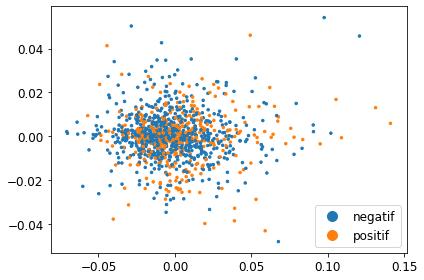

In [29]:
phate_op = phate.PHATE(t=10)
data_phate = phate_op.fit_transform(X)
phate.plot.scatter2d(data_phate, c=seq_df['type'])

<AxesSubplot: >

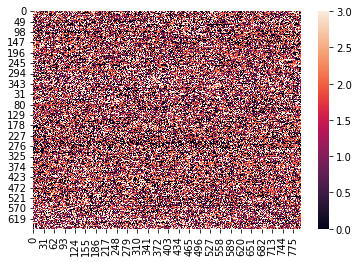

In [34]:
sb.heatmap(X)

In [32]:
dp[0]

array([2, 3, 3, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 0, 2,
       3, 3, 0, 3, 2, 1, 2, 1, 0, 1, 2, 1, 2, 3, 2, 1, 3, 1, 1, 1, 0, 3,
       3, 1, 2, 3, 3, 0, 3, 2, 3, 1, 0, 3, 2, 3, 3, 1, 3, 1, 1, 0, 2, 1,
       2, 1, 3, 3, 1, 2, 1, 0, 1, 2, 3, 1, 0, 0, 3, 1, 2, 1, 2, 3, 1, 1,
       2, 1, 1, 1, 3, 3, 3, 2, 2, 1, 0, 1, 3, 1, 1, 0, 2, 2, 1, 2, 1, 1,
       2, 3, 1, 1, 2, 1, 0, 3, 1, 1, 2, 1, 1, 1, 2, 0, 3, 1, 0, 3, 1, 2,
       3, 3, 3, 0, 1, 2, 0, 1, 0, 3, 3, 0, 3, 1, 0, 1, 3, 1, 1, 3, 1, 1,
       0, 2, 3, 1, 1, 1, 3, 3, 1, 2, 0, 0, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2,
       2, 2, 2, 0, 3, 2, 0, 3, 0, 3, 0, 1, 3, 3, 3, 3, 2, 2, 2, 1, 0, 1,
       1, 1, 2, 3, 2, 2, 0, 3, 1, 1, 0, 3, 3, 0, 2, 3, 3, 2, 1, 2, 0, 3,
       0, 2, 1, 2, 1, 1, 2, 3, 0, 1, 1, 2, 1, 3, 2, 3, 0, 2, 1, 1, 3, 1,
       1, 1, 0, 1, 1, 2, 2, 3, 3, 1, 1, 2, 1, 1, 1, 0, 0, 0, 3, 2, 3, 1,
       2, 3, 3, 3, 0, 2, 2, 0, 1, 0, 3, 3, 2, 3, 2,

In [ ]:
d1['train']['chr_21_neg_seq'].neg_df.to_csv('negative_examples.bed',sep='\t',header=False,index=False)
intervals.pos_df.to_csv('positive_examples.bed',sep='\t',header=False,index=False)

In [53]:
!make_tracks_file --trackFiles negative_examples.bed positive_examples.bed -o tracks.ini 
!pyGenomeTracks --tracks tracks.ini --region chr_21:9436792-15596465 --outFileName nice_image.png

Adding bed file: negative_examples.bed
Adding bed file: positive_examples.bed
INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [spacer]
INFO:pygenometracks.tracksClass:initialize 3. [negative_examples]
100%|████████████████████████████████████████| 20/20 [00:00<00:00, 32780.81it/s]
INFO:pygenometracks.tracksClass:initialize 4. [positive_examples]
*Warning, invalid strand valuefound 9437387 for line #chr_21	9436792	9437983	36	1191	9437387	9435637	9439137
:
1
 Setting strand to '.'
  0%|                                                    | 0/19 [00:00<?, ?it/s]*Warning, invalid strand valuefound 9437387 for line #chr_21	9436792	9437983	36	1191	9437387	9435637	9439137
:
2
 Setting strand to '.'
*Warning, invalid strand valuefound 9484017 for line #chr_21	9482858	9485177	376	2319	9484017	9482267	9485767
:
3
 Setting strand to '.'
*Warning, invalid strand valuefound 9826688 for line #chr_21	9825203	9828173	156	2970	9826688	9824938	9828438


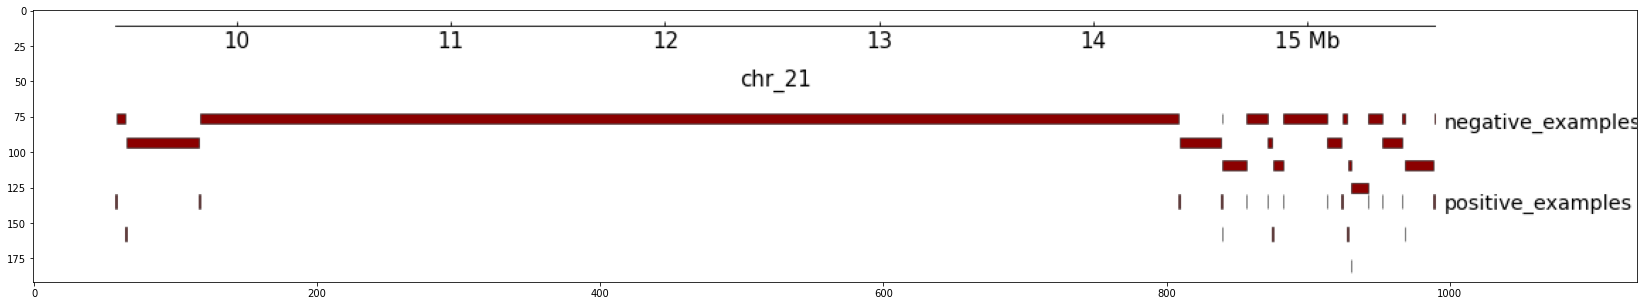

In [54]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (50, 5) # (w, h)

im = cv2.imread('nice_image.png')

plt.imshow(im)
plt.show()